# Inspect 4D images and masks, create 3D images, masks from it

In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *

import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np

from ipywidgets import interact
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.visualization.Visualize import plot_3d_vol, plot_4d_vol, plot_value_histogram, my_autopct
from src.data.Dataset import get_metadata_maybe, filter_4d_vol, copy_meta_and_save, create_3d_volumes_from_4d_files, describe_sitk, describe_volume, describe_path

Console_and_file_logger('3d_Data_generation', logging.INFO)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2020-07-31 12:37:58,828 INFO -------------------- Start --------------------
2020-07-31 12:37:58,828 INFO Working directory: /mnt/data/git/cardio.
2020-07-31 12:37:58,829 INFO Log file: ./logs/3d_Data_generation.log
2020-07-31 12:37:58,829 INFO Log level for console: INFO


# How many 3D files do we have?

In [3]:
img_path = 'data/raw/GCN/3D/*/'
len(glob.glob(os.path.join(img_path, '*img.nrrd')))

1030

In [2]:
images = sorted(glob.glob('/mnt/data/datasets/cardio/miccai_challange/Training-corrected/Labeled/**/*sa.nii.gz', recursive=True))
masks = sorted(glob.glob('/mnt/data/datasets/cardio/miccai_challange/Training-corrected/Labeled/**/*sa_gt.nii.gz', recursive=True))
logging.info(len(images))
logging.info(len(masks))

2020-06-29 14:50:41,928 INFO 150
2020-06-29 14:50:41,929 INFO 150


## Visualize 4D MRT volume - no filtering

In [12]:
@interact_manual
def load_4d_image(f_name=masks, plot_histogram=False):
    # clear figure memory
    plt.rcParams.update({'figure.max_open_warning': 40})
    plt.cla()
    plt.clf()
    logging.info(f_name)
    img = sitk.ReadImage(f_name)
    nda = sitk.GetArrayFromImage(img)
    descr = describe_volume(f_name, image=True, plot=plot_histogram)
    describe_sitk(img)
    [plot_3d_vol(vol) for vol in nda]
    
    return descr
    

interactive(children=(Dropdown(description='f_name', options=('/mnt/data/datasets/cardio/miccai_challange/Trai…

## Visualize 4D masks - filter segmented timesteps

In [13]:
#def load_4d_mask(f_name=sorted(glob.glob(os.path.join('/mnt/data/git/cardio/data/raw/gcn_05_2020/SAx/', '*mask.nrrd'))), plot_histogram=False):
@interact_manual
def load_4d_mask(f_name=masks, plot_histogram=False):
    logging.info(f_name)
    img = sitk.ReadImage(f_name)
    nda = sitk.GetArrayFromImage(img)

    describe_sitk(img)
    descr = describe_volume(f_name, image=True, plot=plot_histogram)
    nda_filtered, timesteps = filter_4d_vol(img)
    #plot_4d_vol(nda_filtered, timesteps)
    [plot_3d_vol(vol) for vol in nda_filtered]
    return descr



interactive(children=(Dropdown(description='f_name', options=('/mnt/data/datasets/cardio/miccai_challange/Trai…

## Visualize 4D Image & Mask

In [15]:
@interact
def show_4d_mask_and_image_interactive(path=masks):
    plt.cla()
    plt.clf()
    plt.rcParams.update({'font.size': 15})
    #logging.info(path)
    msk = sitk.ReadImage(path)
    clean_path = path.replace('_gt', '')
    #clean_path = clean_path.replace('mask', 'clean')
    img_clean = sitk.ReadImage(clean_path)
    #patient = path.split('0000-')[1].split('_volume')[0]
    #logging.info(patient)
    msk_nda = sitk.GetArrayFromImage(msk)
    img_nda = sitk.GetArrayFromImage(img_clean)
    #describe_sitk(msk)
    nda_filtered, timesteps = filter_4d_vol(msk_nda)
    #plot_4d_vol(img_nda[timesteps], timesteps, mask_4d=nda_filtered, save=True,f_name=patient,path='reports/4dvol')
    [plot_3d_vol(i, m) for i,m in zip(img_nda[timesteps], nda_filtered)]

    #plt.savefig('reports/4D_example_volume.pdf')

interactive(children=(Dropdown(description='path', options=('/mnt/data/datasets/cardio/miccai_challange/Traini…

## Create one plot of each 4D volume

In [45]:
for p in sorted(glob.glob(os.path.join('data/raw/GCN_2nd/import/SAx/', '*mask.nrrd'))):
    try:
        show_4d_mask_and_image_interactive(p)
    except Exception as e:
        logging.error('Failed with p: {}, error: {}'.format(p,str(e)))

I0512 17:40:38.483013 140571672446784 <ipython-input-43-f97a000111eb>:12]  911JV78_0200-61-10
I0512 17:40:38.537135 140571672446784 Dataset.py:645] (25, 16, 192, 156)
I0512 17:40:38.545012 140571672446784 Dataset.py:660] filtered timesteps: [3, 7, 11, 16, 22]
I0512 17:40:38.551264 140571672446784 Visualize.py:345] figure: 30 x 10
I0512 17:41:26.693424 140571672446784 <ipython-input-43-f97a000111eb>:12] 02Z1L14N_2006-11-09
I0512 17:41:26.703674 140571672446784 Dataset.py:645] (14, 10, 192, 138)
I0512 17:41:26.706856 140571672446784 Dataset.py:660] filtered timesteps: [2, 5, 7, 11, 13]
I0512 17:41:26.708111 140571672446784 Visualize.py:345] figure: 20 x 10
I0512 17:41:45.928756 140571672446784 <ipython-input-43-f97a000111eb>:12] 04NEJQUZ__200-70-31
I0512 17:41:46.068510 140571672446784 Dataset.py:645] (25, 16, 256, 256)
I0512 17:41:46.084316 140571672446784 Dataset.py:660] filtered timesteps: [5, 12, 16, 20, 23]
I0512 17:41:46.094317 140571672446784 Visualize.py:345] figure: 30 x 10
I051

<Figure size 432x288 with 0 Axes>

<Figure size 144x0 with 0 Axes>

<Figure size 720x0 with 0 Axes>

# Show the 4D images and check the labelled timesteps visually

In [16]:
from IPython.display import Image
path_to_png = 'reports/figures/gcn/ax_to_sax'
@interact
def show_png(i = (0, len(sorted(glob.glob(os.path.join(path_to_png,'*.png'))))-1)):
    f_name = sorted(glob.glob(os.path.join(path_to_png,'*.png')))[i]
    print(f_name)
    return Image(filename=f_name)

interactive(children=(IntSlider(value=80, description='i', max=161), Output()), _dom_classes=('widget-interact…

# Describe the dicom tags of the 4D nrrd files

In [3]:
# use dcmdump to get all hidden flags. sitk.Write with *.dcm works only with 3D/2D images, 
# dcmdump works only with *.dcm suffixes
@interact
def describe_4D_nrrds_interactive(f_name = sorted(glob.glob('/mnt/data/git/cardio/data/raw/gcn_05_2020/SAx_3D/*img.nrrd', recursive=True)), plot_histogram=False):
#def describe_4D_nrrds_interactive(f_name = sorted(glob.glob('/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/SAX_3D/*img.nrrd', recursive=True)), plot_histogram=False):
    import subprocess
    logging.info(f_name)
    temp = 'data/temp'
    ensure_dir(temp)
    sitk_img = sitk.ReadImage(f_name)
    describe_sitk(sitk_img)
    f_temp = os.path.abspath(os.path.join(temp,'temp.dcm'))
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()
    writer.SetFileName(f_temp)
    writer.Execute(sitk_img)
    result = subprocess.run(['dcmdump', '{}'.format(f_temp)], stdout=subprocess.PIPE)
    res = result.stdout.decode('utf-8')
    return res.split('\n')

interactive(children=(Dropdown(description='f_name', options=('/mnt/data/git/cardio/data/raw/gcn_05_2020/SAx_3…

In [5]:
# Define a folder
from ipyfilechooser import FileChooser
chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/'), '')
display(chooser)

FileChooser(path='/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86', filename='', show_hidden='False')

In [30]:
# print all tags from dcmdump, searchable by substrings
f_names = sorted(glob.glob(os.path.join(chooser.selected,  '**/*sa.nii.gz'), recursive=True))
@interact
def describe_4D_nrrds_interactive(f_name = (0,len(f_names)-1), search_str=''):
    f_name = f_names[f_name]
    logging.info(f_name)
    # hack to work with nrrd files
    temp = 'data/temp'
    ensure_dir(temp)
    sitk_img = sitk.ReadImage(f_name, sitk.sitkInt32)

    describe_sitk(sitk_img)
    f_temp = os.path.abspath(os.path.join(temp,'temp.dcm'))
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()
    writer.SetFileName(f_temp)
    writer.Execute(sitk_img)
    import subprocess
    result = subprocess.run(['dcmdump', '{}'.format(f_temp)], stdout=subprocess.PIPE)
    res = result.stdout.decode('utf-8')
    res= res.split('\n')
    res = [r for r in res if search_str in r.lower()]
    return res

interactive(children=(IntSlider(value=74, description='f_name', max=149), Text(value='', description='search_s…

In [ ]:
# print all tags from dcmdump, searchable by substrings
@interact
def describe_4D_nrrds_interactive(f_name = (0,len(sorted(glob.glob('data/raw/gcn_05_2020_sax_excl_ax_patients/SAX/*.nrrd', recursive=True)))-1), search_str=''):
    f_name = sorted(glob.glob('data/raw/gcn_05_2020_sax_excl_ax_patients/SAX/*.nrrd', recursive=True))[f_name]
    logging.info(f_name)
    import subprocess
    logging.info(f_name)
    temp = 'data/temp'
    ensure_dir(temp)
    sitk_img = sitk.ReadImage(f_name)
    describe_sitk(sitk_img)
    f_temp = os.path.abspath(os.path.join(temp,'temp.dcm'))
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()
    writer.SetFileName(f_temp)
    writer.Execute(sitk_img)
    result = subprocess.run(['dcmdump', '{}'.format(f_temp)], stdout=subprocess.PIPE)
    res = result.stdout.decode('utf-8')

    res= res.split('\n')
    res = [r for r in res if search_str in r.lower()]
    sitk_img = sitk.ReadImage(f_name)
    print(sitk_img.GetOrigin())
    res_dict = {}
    for tag in res:
        if tag.startswith('('):
            tags = tag.split()
            res_dict[tags[-1],tags[0]] = tags[2]
    res_df = pd.DataFrame(res_dict, index=[0])
    res_df.columns = pd.MultiIndex.from_tuples(res_df.columns)
    return res_df

interactive(children=(IntSlider(value=192, description='f_name', max=385), Text(value='', description='search_…

In [122]:
df = pd.concat([describe_4D_nrrds_interactive(i) for i in range(len(sorted(glob.glob('data/raw/gcn_05_2020_sax_excl_ax_patients/**/SAx**.nrrd', recursive=True))))])

2020-05-14 16:05:28,325 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522123580.dcm
2020-05-14 16:05:28,380 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522126581.dcm
2020-05-14 16:05:28,436 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522129582.dcm
2020-05-14 16:05:28,490 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)


2020-05-14 16:05:28,600 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522140585.dcm
2020-05-14 16:05:28,653 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522143586.dcm
2020-05-14 16:05:28,707 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522146587.dcm
2020-05-14 16:05:28,760 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)


2020-05-14 16:05:28,814 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522153589.dcm
2020-05-14 16:05:28,871 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522157590.dcm
2020-05-14 16:05:28,925 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522160591.dcm
2020-05-14 16:05:28,980 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)


2020-05-14 16:05:29,033 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522167593.dcm
2020-05-14 16:05:29,088 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522170594.dcm
2020-05-14 16:05:29,144 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522173595.dcm
2020-05-14 16:05:29,198 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)


2020-05-14 16:05:29,254 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522179597.dcm
2020-05-14 16:05:29,308 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522184598.dcm
2020-05-14 16:05:29,362 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522187599.dcm
2020-05-14 16:05:29,416 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)
(206.738726830749, -188.01528121241, 140.626171685097)


2020-05-14 16:05:29,470 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522629601.dcm
2020-05-14 16:05:29,523 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522631602.dcm
2020-05-14 16:05:29,577 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522634603.dcm
2020-05-14 16:05:29,630 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)


2020-05-14 16:05:29,684 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522642605.dcm
2020-05-14 16:05:29,738 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522645606.dcm
2020-05-14 16:05:29,792 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522648607.dcm
2020-05-14 16:05:29,846 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)


2020-05-14 16:05:29,900 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522654609.dcm
2020-05-14 16:05:29,954 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522657610.dcm
2020-05-14 16:05:30,008 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522660611.dcm
2020-05-14 16:05:30,062 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)


2020-05-14 16:05:30,117 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522668613.dcm
2020-05-14 16:05:30,171 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522671614.dcm
2020-05-14 16:05:30,224 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522675615.dcm
2020-05-14 16:05:30,278 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)


2020-05-14 16:05:30,332 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522681617.dcm
2020-05-14 16:05:30,385 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522684618.dcm
2020-05-14 16:05:30,439 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512522687619.dcm
2020-05-14 16:05:30,493 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)
(199.065509057312, -187.61660624751, 144.91601238334)


2020-05-14 16:05:30,547 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525807621.dcm
2020-05-14 16:05:30,601 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525810622.dcm
2020-05-14 16:05:30,654 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525814623.dcm
2020-05-14 16:05:30,708 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)


2020-05-14 16:05:30,761 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525821625.dcm
2020-05-14 16:05:30,814 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525825626.dcm
2020-05-14 16:05:30,867 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525828627.dcm
2020-05-14 16:05:30,923 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)


2020-05-14 16:05:30,979 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525835629.dcm
2020-05-14 16:05:31,037 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525839630.dcm
2020-05-14 16:05:31,094 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525842631.dcm
2020-05-14 16:05:31,154 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)


2020-05-14 16:05:31,215 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525848633.dcm
2020-05-14 16:05:31,271 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525851634.dcm
2020-05-14 16:05:31,325 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525856635.dcm
2020-05-14 16:05:31,380 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)


2020-05-14 16:05:31,434 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525862637.dcm
2020-05-14 16:05:31,488 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525865638.dcm
2020-05-14 16:05:31,542 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512525868639.dcm
2020-05-14 16:05:31,596 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)
(191.39228365448, -187.21793175944, 149.205853081582)


2020-05-14 16:05:31,649 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530529641.dcm
2020-05-14 16:05:31,703 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530532642.dcm
2020-05-14 16:05:31,757 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530535643.dcm
2020-05-14 16:05:31,810 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)


2020-05-14 16:05:31,865 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530542645.dcm
2020-05-14 16:05:31,919 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530545646.dcm
2020-05-14 16:05:31,972 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530548647.dcm
2020-05-14 16:05:32,026 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)


2020-05-14 16:05:32,081 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530556649.dcm
2020-05-14 16:05:32,136 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530559650.dcm
2020-05-14 16:05:32,189 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530562651.dcm
2020-05-14 16:05:32,242 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)


2020-05-14 16:05:32,295 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530568653.dcm
2020-05-14 16:05:32,349 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530571654.dcm
2020-05-14 16:05:32,402 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530575655.dcm
2020-05-14 16:05:32,456 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)


2020-05-14 16:05:32,510 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530581657.dcm
2020-05-14 16:05:32,564 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530585658.dcm
2020-05-14 16:05:32,618 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512530589659.dcm
2020-05-14 16:05:32,671 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)
(183.719065881042, -186.81925727137, 153.495693779824)


2020-05-14 16:05:32,724 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532846661.dcm
2020-05-14 16:05:32,778 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532850662.dcm
2020-05-14 16:05:32,831 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532853663.dcm
2020-05-14 16:05:32,885 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)


2020-05-14 16:05:32,938 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532860665.dcm
2020-05-14 16:05:32,992 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532864666.dcm
2020-05-14 16:05:33,045 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532867667.dcm
2020-05-14 16:05:33,098 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)


2020-05-14 16:05:33,152 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532873669.dcm
2020-05-14 16:05:33,206 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532876670.dcm
2020-05-14 16:05:33,259 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532881671.dcm
2020-05-14 16:05:33,313 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)


2020-05-14 16:05:33,367 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532887673.dcm
2020-05-14 16:05:33,420 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532890674.dcm
2020-05-14 16:05:33,474 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532893675.dcm
2020-05-14 16:05:33,531 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)


2020-05-14 16:05:33,586 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532900677.dcm
2020-05-14 16:05:33,639 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532904678.dcm
2020-05-14 16:05:33,695 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512532907679.dcm
2020-05-14 16:05:33,748 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)
(176.04584047821, -186.42058278331, 157.785534954903)


2020-05-14 16:05:33,802 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533553681.dcm
2020-05-14 16:05:33,856 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533556682.dcm
2020-05-14 16:05:33,910 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533559683.dcm
2020-05-14 16:05:33,964 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)


2020-05-14 16:05:34,020 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533565685.dcm
2020-05-14 16:05:34,076 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533568686.dcm
2020-05-14 16:05:34,133 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533573687.dcm
2020-05-14 16:05:34,191 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)


2020-05-14 16:05:34,248 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533579689.dcm
2020-05-14 16:05:34,303 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533582690.dcm
2020-05-14 16:05:34,358 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533585691.dcm
2020-05-14 16:05:34,412 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)


2020-05-14 16:05:34,467 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533592693.dcm
2020-05-14 16:05:34,522 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533595694.dcm
2020-05-14 16:05:34,577 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533598695.dcm
2020-05-14 16:05:34,630 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)


2020-05-14 16:05:34,684 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533606697.dcm
2020-05-14 16:05:34,737 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533609698.dcm
2020-05-14 16:05:34,790 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512533612699.dcm
2020-05-14 16:05:34,843 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)
(168.372622704773, -186.02190829524, 162.075376070378)


2020-05-14 16:05:34,896 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540764701.dcm
2020-05-14 16:05:34,950 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540767702.dcm
2020-05-14 16:05:35,004 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540770703.dcm
2020-05-14 16:05:35,058 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)


2020-05-14 16:05:35,112 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540778705.dcm
2020-05-14 16:05:35,165 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540781706.dcm
2020-05-14 16:05:35,219 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540784707.dcm
2020-05-14 16:05:35,273 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)


2020-05-14 16:05:35,327 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540790709.dcm
2020-05-14 16:05:35,382 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540795710.dcm
2020-05-14 16:05:35,436 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540798711.dcm
2020-05-14 16:05:35,490 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)


2020-05-14 16:05:35,544 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540804713.dcm
2020-05-14 16:05:35,600 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540807714.dcm
2020-05-14 16:05:35,656 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540810715.dcm
2020-05-14 16:05:35,713 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)


2020-05-14 16:05:35,770 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540818717.dcm
2020-05-14 16:05:35,826 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540821718.dcm
2020-05-14 16:05:35,881 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512540825719.dcm
2020-05-14 16:05:35,936 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)
(160.699397301941, -185.62323380717, 166.365217305062)


2020-05-14 16:05:35,991 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541475721.dcm
2020-05-14 16:05:36,046 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541478722.dcm
2020-05-14 16:05:36,099 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541481723.dcm
2020-05-14 16:05:36,152 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)


2020-05-14 16:05:36,206 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541489725.dcm
2020-05-14 16:05:36,260 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541492726.dcm
2020-05-14 16:05:36,313 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541495727.dcm
2020-05-14 16:05:36,367 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)


2020-05-14 16:05:36,420 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541501729.dcm
2020-05-14 16:05:36,474 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541504730.dcm
2020-05-14 16:05:36,529 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541507731.dcm
2020-05-14 16:05:36,582 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)


2020-05-14 16:05:36,637 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541514733.dcm
2020-05-14 16:05:36,691 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541518734.dcm
2020-05-14 16:05:36,745 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541521735.dcm
2020-05-14 16:05:36,799 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)


2020-05-14 16:05:36,852 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541528737.dcm
2020-05-14 16:05:36,905 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541531738.dcm
2020-05-14 16:05:36,959 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512541534739.dcm
2020-05-14 16:05:37,013 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)
(153.026179528503, -185.22455979594, 170.655058480141)


2020-05-14 16:05:37,069 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544764741.dcm
2020-05-14 16:05:37,125 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544767742.dcm
2020-05-14 16:05:37,181 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544770743.dcm
2020-05-14 16:05:37,241 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)


2020-05-14 16:05:37,301 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544778745.dcm
2020-05-14 16:05:37,357 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544781746.dcm
2020-05-14 16:05:37,412 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544784747.dcm
2020-05-14 16:05:37,469 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)


2020-05-14 16:05:37,523 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544792749.dcm
2020-05-14 16:05:37,577 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544795750.dcm
2020-05-14 16:05:37,631 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544798751.dcm
2020-05-14 16:05:37,685 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)


2020-05-14 16:05:37,740 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544804753.dcm
2020-05-14 16:05:37,793 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544807754.dcm
2020-05-14 16:05:37,847 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544812755.dcm
2020-05-14 16:05:37,901 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)


2020-05-14 16:05:37,961 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544818757.dcm
2020-05-14 16:05:38,018 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544821758.dcm
2020-05-14 16:05:38,071 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512544825759.dcm
2020-05-14 16:05:38,124 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)
(145.352954125671, -184.82588530787, 174.944899178384)


2020-05-14 16:05:38,178 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545434761.dcm
2020-05-14 16:05:38,233 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545437762.dcm
2020-05-14 16:05:38,290 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545440763.dcm
2020-05-14 16:05:38,347 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)


2020-05-14 16:05:38,404 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545448765.dcm
2020-05-14 16:05:38,464 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545451766.dcm
2020-05-14 16:05:38,526 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545454767.dcm


(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)


2020-05-14 16:05:38,597 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545457768.dcm
2020-05-14 16:05:38,656 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545460769.dcm
2020-05-14 16:05:38,710 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545464770.dcm
2020-05-14 16:05:38,763 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)


2020-05-14 16:05:38,868 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545473773.dcm
2020-05-14 16:05:38,922 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545478774.dcm
2020-05-14 16:05:38,978 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545481775.dcm
2020-05-14 16:05:39,036 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)


2020-05-14 16:05:39,098 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545487777.dcm
2020-05-14 16:05:39,152 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545490778.dcm
2020-05-14 16:05:39,210 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512545493779.dcm
2020-05-14 16:05:39,267 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)
(137.679736352234, -184.4272108198, 179.234739876626)


2020-05-14 16:05:39,322 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553143781.dcm
2020-05-14 16:05:39,377 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553146782.dcm
2020-05-14 16:05:39,432 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553150783.dcm
2020-05-14 16:05:39,487 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)


2020-05-14 16:05:39,543 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553157785.dcm
2020-05-14 16:05:39,598 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553160786.dcm
2020-05-14 16:05:39,654 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553164787.dcm
2020-05-14 16:05:39,710 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)


2020-05-14 16:05:39,767 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553170789.dcm
2020-05-14 16:05:39,826 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553175790.dcm
2020-05-14 16:05:39,879 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553178791.dcm
2020-05-14 16:05:39,933 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)


2020-05-14 16:05:39,987 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553184793.dcm
2020-05-14 16:05:40,041 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553187794.dcm
2020-05-14 16:05:40,095 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553190795.dcm
2020-05-14 16:05:40,148 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)


2020-05-14 16:05:40,201 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553198797.dcm
2020-05-14 16:05:40,255 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553201798.dcm
2020-05-14 16:05:40,307 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553204799.dcm
2020-05-14 16:05:40,360 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)
(130.006514764099, -184.02853633174, 183.524580574868)


2020-05-14 16:05:40,413 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553857801.dcm
2020-05-14 16:05:40,467 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553860802.dcm
2020-05-14 16:05:40,521 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553864803.dcm
2020-05-14 16:05:40,574 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)


2020-05-14 16:05:40,631 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553871805.dcm
2020-05-14 16:05:40,685 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553875806.dcm
2020-05-14 16:05:40,741 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553878807.dcm
2020-05-14 16:05:40,799 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)


2020-05-14 16:05:40,864 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553884809.dcm
2020-05-14 16:05:40,919 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553887810.dcm
2020-05-14 16:05:40,975 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553890811.dcm
2020-05-14 16:05:41,031 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)


2020-05-14 16:05:41,084 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553898813.dcm
2020-05-14 16:05:41,137 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553901814.dcm
2020-05-14 16:05:41,190 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553904815.dcm
2020-05-14 16:05:41,243 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)


2020-05-14 16:05:41,297 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553910817.dcm
2020-05-14 16:05:41,352 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553914818.dcm
2020-05-14 16:05:41,407 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512553917819.dcm
2020-05-14 16:05:41,475 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)
(122.333293175964, -183.62986160525, 187.814423180459)


2020-05-14 16:05:41,536 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560475821.dcm
2020-05-14 16:05:41,590 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560478822.dcm
2020-05-14 16:05:41,645 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560481823.dcm
2020-05-14 16:05:41,699 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)


2020-05-14 16:05:41,753 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560487825.dcm
2020-05-14 16:05:41,806 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560492826.dcm
2020-05-14 16:05:41,860 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560495827.dcm
2020-05-14 16:05:41,913 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)


2020-05-14 16:05:41,967 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560501829.dcm
2020-05-14 16:05:42,026 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560504830.dcm
2020-05-14 16:05:42,079 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560507831.dcm
2020-05-14 16:05:42,133 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)


2020-05-14 16:05:42,186 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560515833.dcm
2020-05-14 16:05:42,240 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560518834.dcm
2020-05-14 16:05:42,293 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560521835.dcm
2020-05-14 16:05:42,347 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)


2020-05-14 16:05:42,402 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560528837.dcm
2020-05-14 16:05:42,456 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560532838.dcm
2020-05-14 16:05:42,509 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512560535839.dcm
2020-05-14 16:05:42,562 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)
(114.66007158783, -183.23118711718, 192.104263878701)


2020-05-14 16:05:42,616 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561159841.dcm
2020-05-14 16:05:42,670 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561162842.dcm
2020-05-14 16:05:42,723 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561165843.dcm
2020-05-14 16:05:42,777 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)


2020-05-14 16:05:42,831 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561171845.dcm
2020-05-14 16:05:42,884 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561175846.dcm
2020-05-14 16:05:42,938 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561178847.dcm
2020-05-14 16:05:42,991 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)


2020-05-14 16:05:43,046 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561185849.dcm
2020-05-14 16:05:43,099 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561189850.dcm
2020-05-14 16:05:43,163 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561192851.dcm
2020-05-14 16:05:43,216 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)


2020-05-14 16:05:43,269 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561198853.dcm
2020-05-14 16:05:43,322 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561201854.dcm
2020-05-14 16:05:43,376 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561204855.dcm
2020-05-14 16:05:43,429 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/

(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)


2020-05-14 16:05:43,483 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561212857.dcm
2020-05-14 16:05:43,537 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561215858.dcm
2020-05-14 16:05:43,590 INFO /mnt/data/datasets/cardio/GCN/temp/4A8MPQF4200503151212491/SAx_4A8MPQF4200503151212491.3.46.670589.11.0.0.11.4.2.0.5167.5.1236.2005031512124768000/1.3.46.670589.11.0.0.11.4.2.0.5167.5.5284.2005031512513262064/1.3.46.670589.11.0.0.11.4.2.0.5167.5.1252.2005031512561218859.dcm


(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)
(106.986849999695, -182.83251262912, 196.394102669594)


In [135]:
df


FileMetaInformationGroupLength FileMetaInformationVersion  \
                      (0002,0000)                (0002,0001)   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
..                            ...                        ...   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206                      00\01   
0                             206  

In [108]:
# check how many different origins we have for one volume, this should be the number of timesteps
# number of dicoms / timesteps should be an integer, otherwise the volumes might be distorted
@interact_manual
def calculate_timesteps_of_dicom_files_interact(path_ = sorted(glob.glob('/mnt/data/datasets/cardio/GCN/temp/**/**/**/'))):
    from src.data.Extract_segments_v3 import get_timesteps
    dicoms = [sitk.ReadImage(img) for img in sorted(glob.glob(os.path.join(path_, '*.dcm')))]
    origins = [img.GetOrigin() for idx, img in enumerate(dicoms)]
    counter = Counter(origins)
    steps = counter[next(iter(counter))]
    print('found {} dicoms'.format(len(dicoms)))
    print('found {} timesteps, according to the ordigins'.format(steps))
    print('found {} z slices per timestep, number of dicoms fit: {}'.format(len(dicoms)/steps, (len(dicoms)/steps).is_integer()))

    i = iter(counter)
    for o in i:
        print('found: {} slices with origin: {}'.format(counter[o], o))


interactive(children=(Dropdown(description='path_', options=('/mnt/data/datasets/cardio/GCN/temp/4A8MPQF420050…

## Describe ACDC img/msk properties

In [20]:
@interact
def describe_4D_acdc_nrrds_interactive(f_name= glob.glob(os.path.join('data/raw/ACDC/original/all/', '**/*.nii.gz'), recursive = True), plot_histogram=False):
    # describe ACDC nii.gz files
    
    #f_name = 'data/raw/ACDC/small/patient001/patient001_frame01.nii.gz'
    descr = describe_volume(f_name, image=True, plot=plot_histogram)
    return descr

interactive(children=(Dropdown(description='f_name', options=('data/raw/ACDC/original/all/patient050/patient05…

In [3]:
# select by path, show images and masks
@interact
def load_3d_volumes(file_=sorted(glob.glob(os.path.join('data/raw/ACDC/3D/**/','*msk.nrrd')))):
    logging.info(file_)
    
    mask = sitk.ReadImage(file_)
    mask_nda = sitk.GetArrayFromImage(mask)
    img = sitk.ReadImage(file_.replace('msk', 'img'))
    img_nda = sitk.GetArrayFromImage(img)
    vis(img, mask)

interactive(children=(Dropdown(description='file_', options=(), value=None), Output()), _dom_classes=('widget-…

## Visualize image & mask - can read 2D and 3D data

In [13]:
# select by path, show images and masks
temp = None
@interact
def load_3d_volumes(file_=sorted(glob.glob(os.path.join('data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_ISO/','*msk.nrrd'))),slice_by=(1,11), path='data/temp/ax_to_sax/'):
    from src.visualization.Visualize import show_2D_or_3D
    global temp
    ensure_dir(path)
    logging.info(file_)
    p, f = os.path.split(file_)
    mask = sitk.ReadImage(file_)
    mask_nda = sitk.GetArrayFromImage(mask)
    img = sitk.ReadImage(file_.replace('msk', 'img'))
    img_nda = sitk.GetArrayFromImage(img)
    temp = mask_nda
    show_2D_or_3D(img_nda[::slice_by], mask_nda[::slice_by])
    plt.savefig(os.path.join(path, '{}.png'.format(f.replace('.nrrd',''))))

interactive(children=(Dropdown(description='file_', options=('data/raw/gcn_05_2020_ax_sax_86/AX_to_SAX_3D_ISO/…

In [15]:
files  = sorted(glob.glob(os.path.join('data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/','*msk.nrrd')))
p = 'data/temp/ax/'
for f in files:
    load_3d_volumes(file_=f,slice_by=6, path=p)
    plt.close('all')

2020-07-01 10:43:15,268 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd
2020-07-01 10:43:19,860 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd
2020-07-01 10:43:23,920 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0PTV75MP_2005-06-27_ED_msk.nrrd
2020-07-01 10:43:27,449 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0PTV75MP_2005-06-27_ES_msk.nrrd
2020-07-01 10:43:31,178 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0RPELLU8_2007-02-13_ED_msk.nrrd
2020-07-01 10:43:32,780 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0RPELLU8_2007-02-13_ES_msk.nrrd
2020-07-01 10:43:35,791 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-11YU3CUF_2007-12-10_ED_msk.nrrd
2020-07-01 10:43:38,504 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-11YU3CUF_2007-12-10_ES_msk.nrrd
2020-07-01 10:43:39,846 INFO data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-13JLP3HN_2007-05-22_ED_msk.nrrd
2020-07-01 10:43:42,871 INFO data/raw

In [21]:
# select file, show only masks
@interact
def load_3d_volumes(file_=sorted(glob.glob(os.path.join('data/raw/GCN/3D/**/','*msk.nrrd')))):
    from src.visualization.Visualize import show_2D_or_3D
    logging.info(file_)
    img = sitk.ReadImage(file_)
    nda = sitk.GetArrayFromImage(img)
    show_2D_or_3D(nda)

interactive(children=(Dropdown(description='file_', options=('data/raw/GCN/3D/test/0019-1EMMCVKN-2006-06-29__t…

In [80]:
# inspect files from the kfold dataframes
# slicer for selection
df = pd.read_csv('data/raw/miccai2020/2d_dataset.csv')

@interact
def load_3d_volumes(selected=(0,len(sorted(df.x_path.values))-1, 1)):
    from src.visualization.Visualize import show_2D_or_3D
    files_=sorted(df.x_path.values)
    file_ = files_[selected]
    logging.info(file_)
    img = sitk.ReadImage(file_)
    nda = sitk.GetArrayFromImage(img)
    mask = sitk.ReadImage(file_.replace('img', 'msk'))
    describe_sitk(img)
    show_2D_or_3D(nda, mask)

interactive(children=(IntSlider(value=6567, description='selected', max=13135), Output()), _dom_classes=('widg…

In [22]:
# slicer for selection
@interact
def load_3d_volumes(selected=(0,len(sorted(glob.glob(os.path.join('data/raw/GCN/3D/**/*msk.nrrd')))), 1)):
    from src.visualization.Visualize import show_2D_or_3D
    files_=sorted(glob.glob(os.path.join('data/raw/GCN/3D/**/*msk.nrrd')))
    file_ = files_[selected]
    logging.info(file_)
    img = sitk.ReadImage(file_)
    nda = sitk.GetArrayFromImage(img)
    show_2D_or_3D(nda)

interactive(children=(IntSlider(value=515, description='selected', max=1030), Output()), _dom_classes=('widget…

## Describe 3D img/msk properties and plot histogram

In [56]:
@interact
def describe_3D_nrrds_interactive(f_name = glob.glob('data/raw/miccai2020/3D_filtered/*.nrrd'), plot_histogram=False):
    
    is_image = True
    logging.info(f_name)
    
    # use different histogram plotting for images and masks
    if f_name[-8:-5] == 'msk':
        is_image = False
    
    descr = describe_volume(f_name, image=is_image, plot=plot_histogram)
    return descr

interactive(children=(Dropdown(description='f_name', options=('data/raw/miccai2020/3D_filtered/J4J9W6_sa_t11_m…

## Describe img/msk properties for a tetra path (create a dataframe from results)

## Describe 4D GCN dataset

In [2]:
paths = ['data/raw/gcn_05_2020_sax_excl_ax_patients/SAX/']
dataframes_4d = [describe_path(path=path, dataset='GCN', plot_histogram=False) for path in paths]

df_4d = pd.concat(dataframes_4d)

2020-07-31 12:39:46,848 INFO Using GCN dataset
2020-07-31 12:39:46,863 INFO describing path: data/raw/gcn_05_2020_sax_excl_ax_patients/SAX/


106.86970308048804

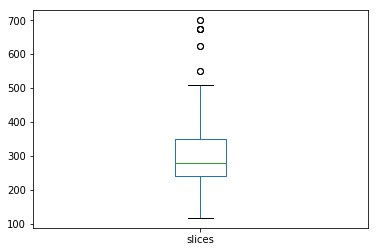

In [3]:
df_4d['slices'].plot(kind='box')
df_4d['slices'].min()
df_4d['slices'].max()
df_4d['slices'].mean()
df_4d['slices'].std(ddof=1)

In [4]:
df_4d.shape

(386, 45)

In [5]:
df_4d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 45 columns):
.50-quantle                386 non-null float64
.75-quantile               386 non-null float64
.99-quantile               386 non-null float64
CardiacNumberOfImages      386 non-null object
InstitutionAddress         386 non-null object
InstitutionName            386 non-null object
LargestImagePixelValue     386 non-null int64
MagneticFieldStrength      386 non-null float64
Manufacturer               386 non-null object
ManufacturerModelName      386 non-null object
PatientAge                 386 non-null object
PatientBirthDate           386 non-null object
PatientID                  386 non-null object
PatientPosition            386 non-null object
PatientSex                 386 non-null object
PatientSize                386 non-null object
PatientWeight              386 non-null object
ReferringPhysicianName     386 non-null object
SeriesDescription          386 non-null object

In [6]:
df_4d['x'] = df_4d['x-axis'] * df_4d['x-spacing']
df_4d['y'] = df_4d['y-axis'] * df_4d['y-spacing']
df_4d['z'] = df_4d['z-axis'] * df_4d['z-spacing']
df_4d['t'] = df_4d['t-axis']

# Plot the physical sizes (number of pixel x pixelsize in mm) of the volumes per axis

2020-07-31 12:43:28,247 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:28,266 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:28,299 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:28,316 WARNING No handles with labels found to put in legend.


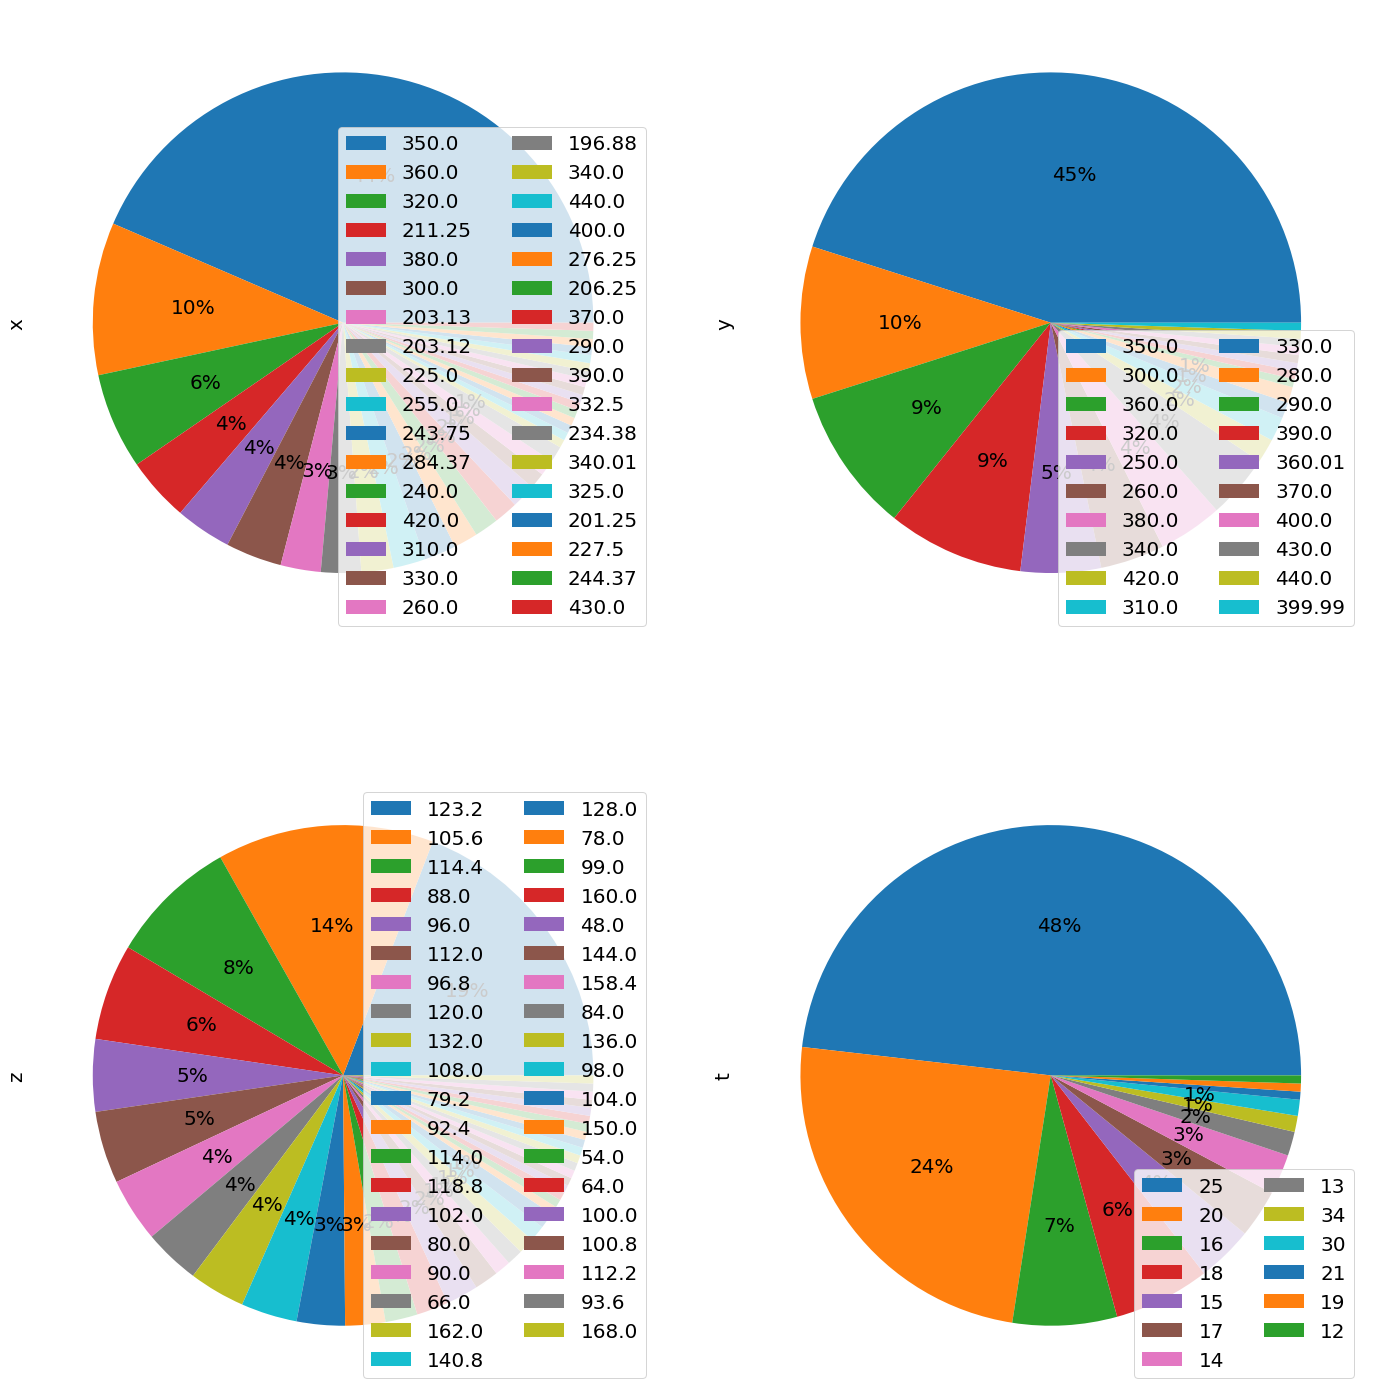

In [7]:
### show all available resolutions for x, y, z and t for the tetra-dataset
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
df_4d[['x']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,0], autopct=my_autopct)
df_4d[['y']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,1], autopct=my_autopct)
df_4d[['z']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,0], autopct=my_autopct)
df_4d[['t']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,1], autopct=my_autopct)
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
axes[0,0].legend(loc=4, ncol=2, labels=df_4d[['x']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[0,1].legend(loc=4, ncol=2, labels=df_4d[['y']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,0].legend(loc=4, ncol=2, labels=df_4d[['z']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,1].legend(loc=4, ncol=2, labels=df_4d[['t']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
plt.tight_layout()
plt.savefig('reports/gcn2_2020_physical_4d.pdf')

# Plot the resolutions per axis

2020-07-31 12:43:35,926 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:35,937 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:36,018 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:36,034 WARNING No handles with labels found to put in legend.


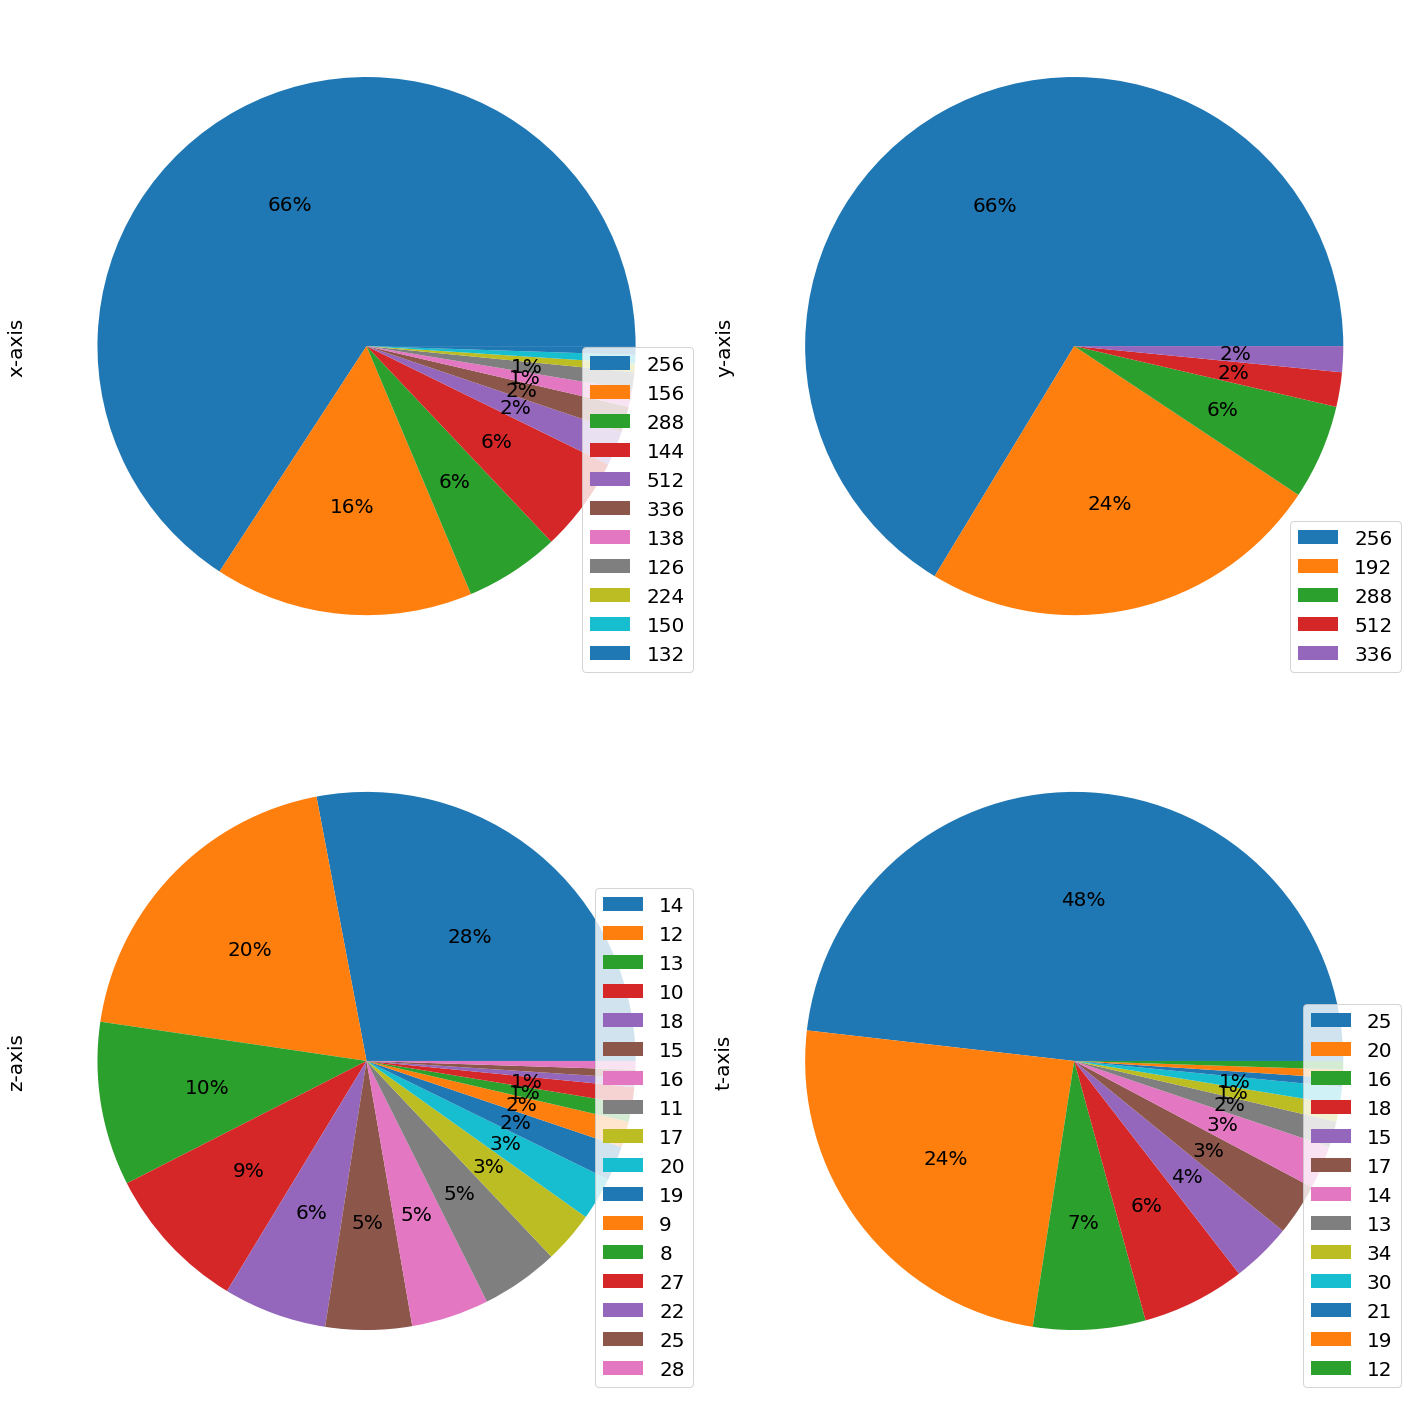

In [8]:
# show all available resolutions for x, y, z and t for the tetra-dataset
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
df_4d[['x-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,0], autopct=my_autopct)
df_4d[['y-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,1], autopct=my_autopct)
df_4d[['z-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,0], autopct=my_autopct)
df_4d[['t-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,1], autopct=my_autopct)
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
axes[0,0].legend(loc=4, labels=df_4d[['x-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[0,1].legend(loc=4, labels=df_4d[['y-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,0].legend(loc=4, labels=df_4d[['z-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,1].legend(loc=4, labels=df_4d[['t-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
plt.tight_layout()
plt.savefig('reports/gcn2_2020_resolution_4d.pdf')

# Plot the volume spacings per axis

2020-07-31 12:43:42,204 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:42,242 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:42,261 WARNING No handles with labels found to put in legend.
2020-07-31 12:43:42,282 WARNING No handles with labels found to put in legend.


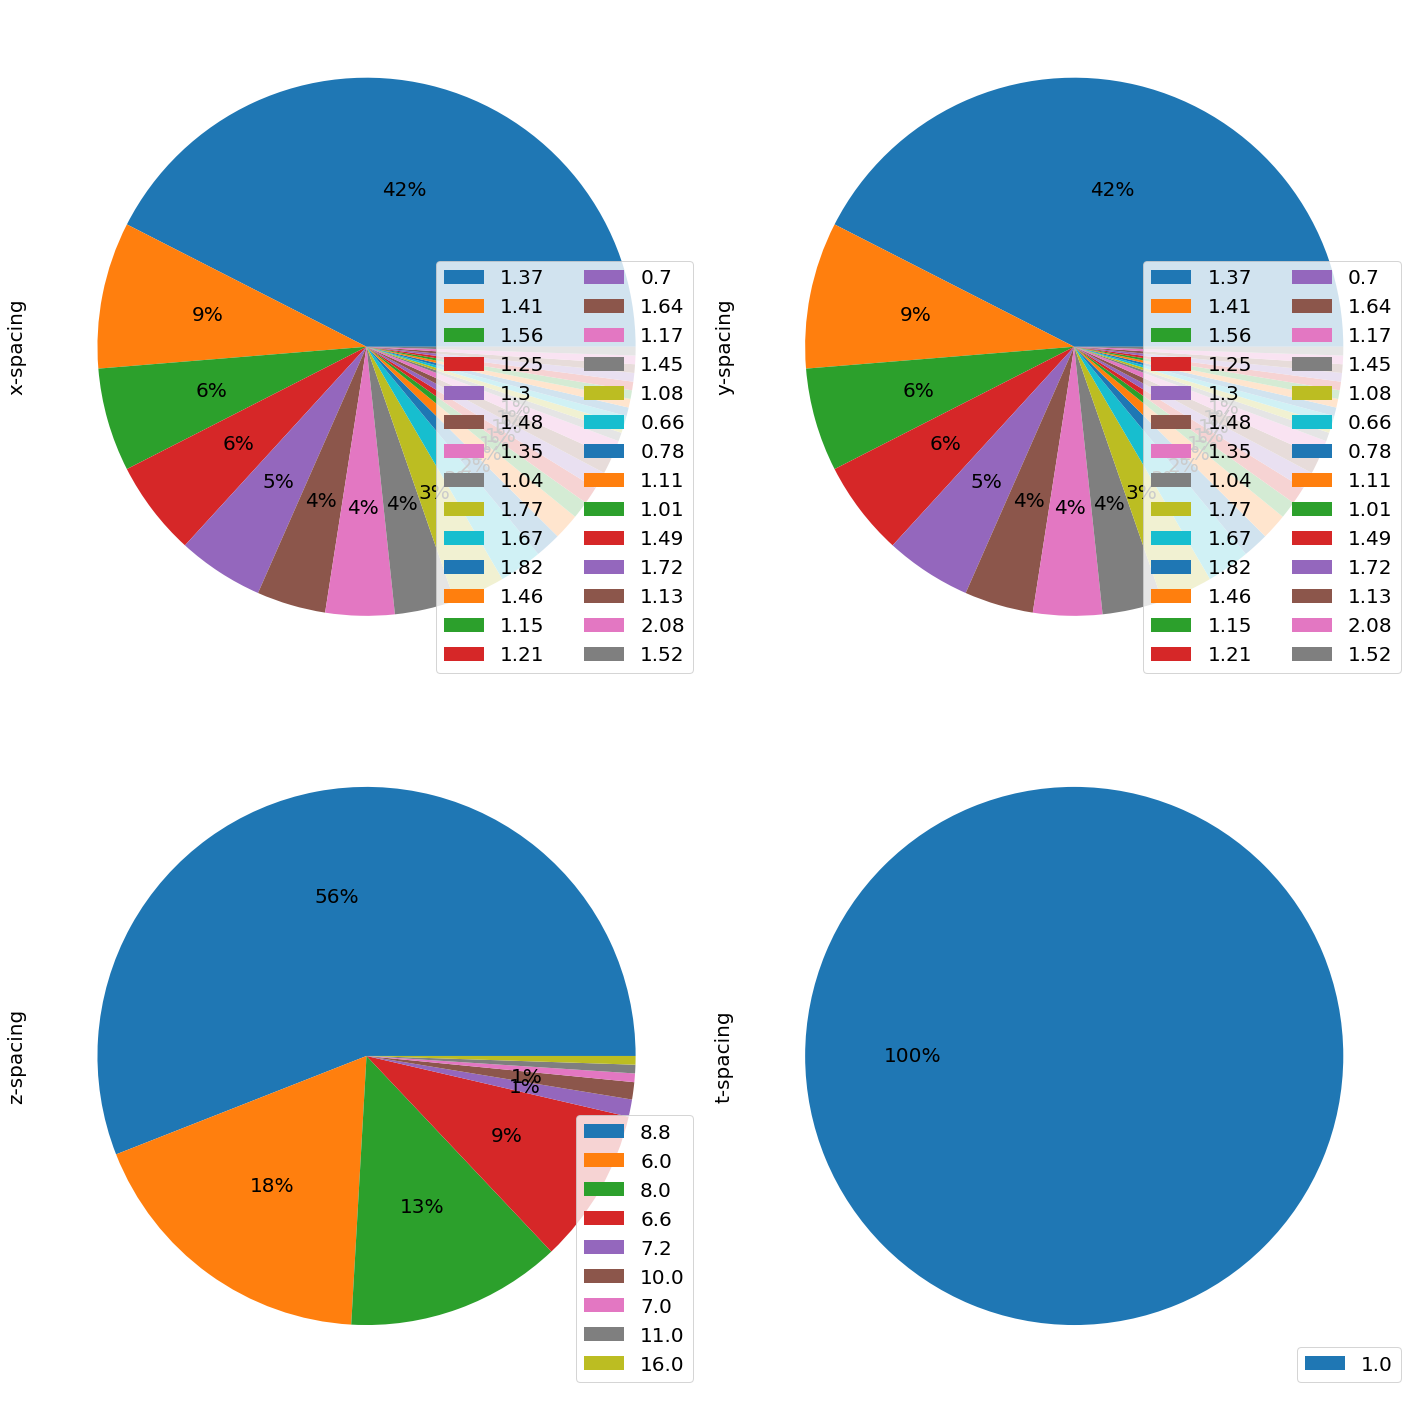

In [9]:
# show all available spacings for x, y, z and t for the tetra-dataset
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
plt.rcParams.update({'font.size': 20})
df_4d[['x-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,0], autopct=my_autopct)
df_4d[['y-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,1], autopct=my_autopct)
df_4d[['z-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,0], autopct=my_autopct)
df_4d[['t-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,1], autopct=my_autopct)
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
axes[0,0].legend(loc=4, ncol=2, labels=df_4d[['x-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[0,1].legend(loc=4, ncol=2, labels=df_4d[['y-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,0].legend(loc=4, labels=df_4d[['z-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,1].legend(loc=4, labels=df_4d[['t-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
plt.tight_layout()
plt.savefig('reports/gcn2_2020_spacing_4d.pdf')

#ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.05),
 #         fancybox=True, shadow=True, ncol=2, prop=fontP, labels=df_4d[['resolution3d']].apply(pd.value_counts).index)

In [10]:
df_temp = df_4d[df_4d['image']==True]
df_temp.shape

(193, 49)

In [11]:
# save dataframe as as cvs export
df_temp.to_csv('reports/data_descriptions/GCN_05_2020_excl_ax_4d_export.csv', index=False, sep=';')

In [32]:
print(df_temp['x-axis'].mean())
print(df_temp['x-axis'].std())
print(df_temp['y-axis'].mean())
print(df_temp['y-axis'].std())
print(df_temp['z-axis'].mean())
print(df_temp['z-axis'].std())

print(df_temp['x-spacing'].mean())
print(df_temp['x-spacing'].std())
print(df_temp['y-spacing'].mean())
print(df_temp['y-spacing'].std())
print(df_temp['z-spacing'].mean())
print(df_temp['z-spacing'].std())

238.5181347150259
62.95220518908973
248.78756476683938
49.743105162688146
13.927461139896373
3.19585054533491
1.378884829530843
0.18658302591896517
1.378884773012708
0.18658321692781743
8.018652934239368
1.3062607236413817


# Describe 4D ACDC dataset

In [32]:
paths = ['data/raw/ACDC/original/train', 'data/raw/ACDC/original/val'] # test directory is not included because we dont use it (no labels given)
dataframes_4d = [describe_path(path=path, dataset='ACDC', wildcard='**/*4d.nii.gz', plot_histogram=False) for path in paths]
df_acdc_4d = pd.concat(dataframes_4d)

2020-02-15 10:12:10,368 INFO Using wildcard description: **/*4d.nii.gz
2020-02-15 10:12:10,393 INFO describing path: data/raw/ACDC/original/train
2020-02-15 10:12:37,787 INFO Using wildcard description: **/*4d.nii.gz
2020-02-15 10:12:37,793 INFO describing path: data/raw/ACDC/original/val


# Describe Miccai2020 data

In [69]:
paths = ['data/raw/miccai2020/3D_filtered']
dataframes_4d = [describe_path(path=path, dataset='ACDC', wildcard='*img.nrrd', plot_histogram=False) for path in paths]
df_acdc_4d = pd.concat(dataframes_4d)

2020-05-26 16:21:50,550 INFO Using wildcard description: *img.nrrd
2020-05-26 16:21:50,553 INFO describing path: data/raw/miccai2020/3D_filtered


In [70]:
df_acdc_4d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 45 columns):
.50-quantle                300 non-null float64
.75-quantile               300 non-null float64
.99-quantile               300 non-null float64
CardiacNumberOfImages      300 non-null object
InstitutionAddress         300 non-null object
InstitutionName            300 non-null object
LargestImagePixelValue     300 non-null int64
MagneticFieldStrength      300 non-null object
Manufacturer               300 non-null object
ManufacturerModelName      300 non-null object
PatientAge                 300 non-null object
PatientBirthDate           300 non-null object
PatientID                  300 non-null object
PatientPosition            300 non-null object
PatientSex                 300 non-null object
PatientSize                300 non-null object
PatientWeight              300 non-null object
ReferringPhysicianName     300 non-null object
SeriesDescription          300 non-null object


In [71]:
df_acdc_4d['x'] = df_acdc_4d['x-axis'] * df_acdc_4d['x-spacing']
df_acdc_4d['y'] = df_acdc_4d['y-axis'] * df_acdc_4d['y-spacing']
df_acdc_4d['z'] = df_acdc_4d['z-axis'] * df_acdc_4d['z-spacing']
df_acdc_4d['t'] = df_acdc_4d['t-axis']

# physical size

2020-05-26 16:22:13,566 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:13,592 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:13,617 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:13,626 WARNING No handles with labels found to put in legend.


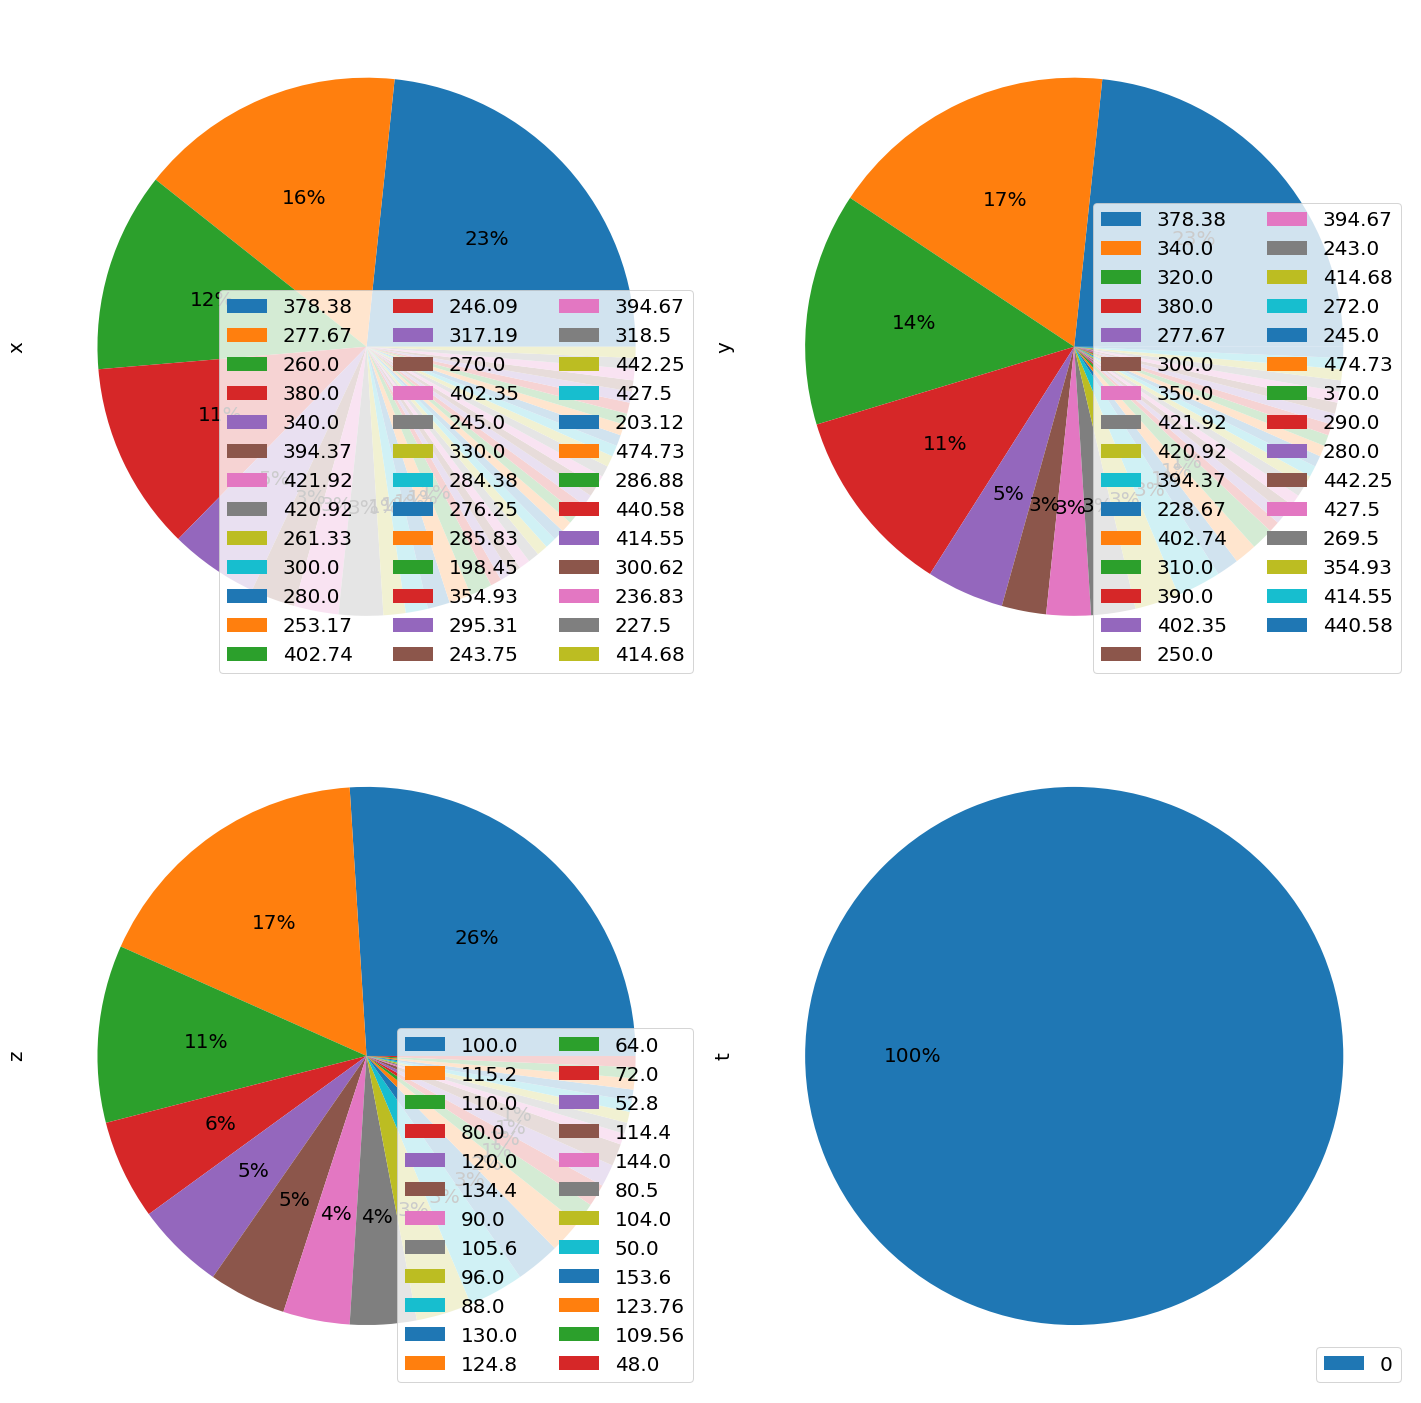

In [72]:
### show all available resolutions for x, y, z and t for the tetra-dataset
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
df_acdc_4d[['x']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,0], autopct=my_autopct)
df_acdc_4d[['y']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,1], autopct=my_autopct)
df_acdc_4d[['z']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,0], autopct=my_autopct)
df_acdc_4d[['t']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,1], autopct=my_autopct)
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
axes[0,0].legend(loc='lower right', ncol=3, labels=df_acdc_4d[['x']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[0,1].legend(loc=4, ncol=2, labels=df_acdc_4d[['y']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,0].legend(loc=4, ncol=2, labels=df_acdc_4d[['z']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,1].legend(loc=4, ncol=2, labels=df_acdc_4d[['t']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
plt.tight_layout()
plt.savefig('reports/miccai2020_physical_4d.pdf')

2020-05-26 16:22:30,342 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:30,357 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:30,372 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:30,380 WARNING No handles with labels found to put in legend.


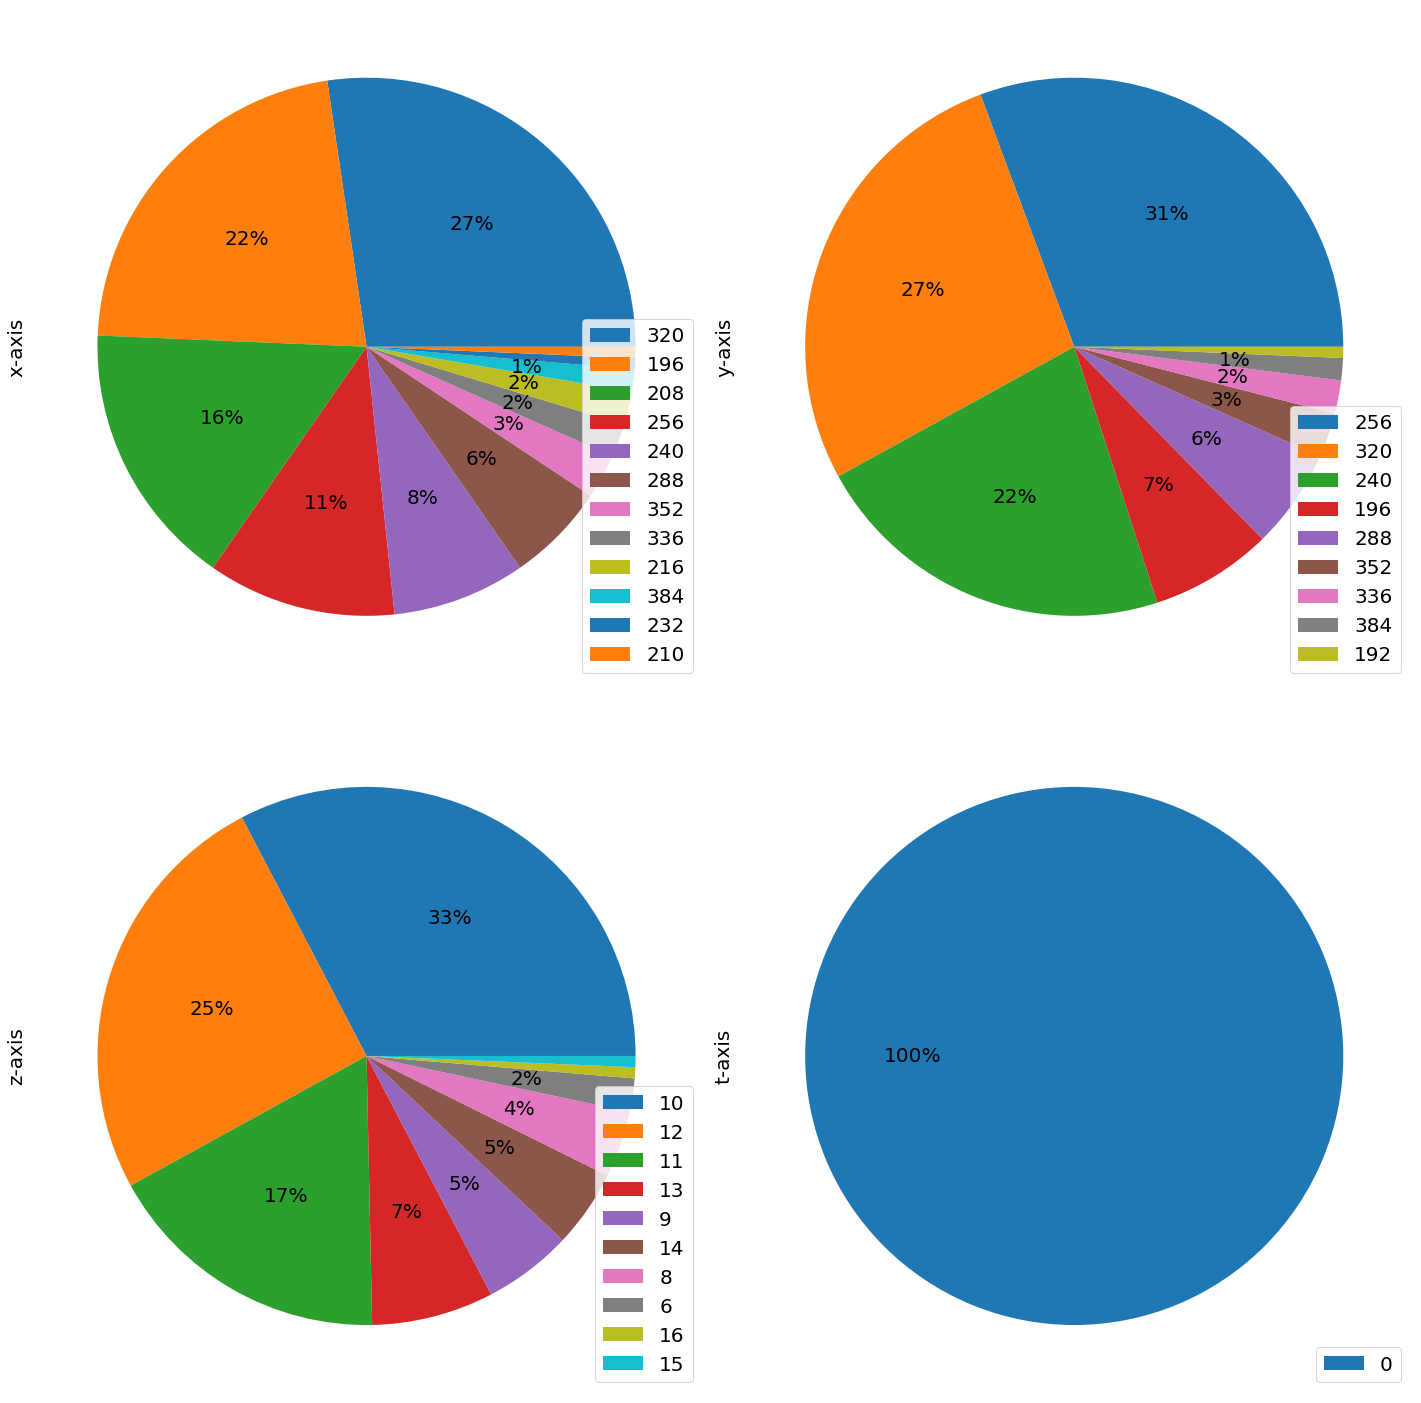

In [73]:
# show all available resolutions for x, y, z and t for the ACDC-dataset
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
plt.rcParams.update({'font.size': 20})
df_acdc_4d[['x-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,0], autopct=my_autopct)
df_acdc_4d[['y-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,1], autopct=my_autopct)
df_acdc_4d[['z-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,0], autopct=my_autopct)
df_acdc_4d[['t-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,1], autopct=my_autopct)
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
axes[0,0].legend(loc=4, labels=df_acdc_4d[['x-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[0,1].legend(loc=4, labels=df_acdc_4d[['y-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,0].legend(loc=4, labels=df_acdc_4d[['z-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,1].legend(loc=4, labels=df_acdc_4d[['t-axis']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
plt.tight_layout()
plt.savefig('reports/miccai2020_resolutions.pdf')

2020-05-26 16:22:46,764 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:46,786 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:46,799 WARNING No handles with labels found to put in legend.
2020-05-26 16:22:46,807 WARNING No handles with labels found to put in legend.


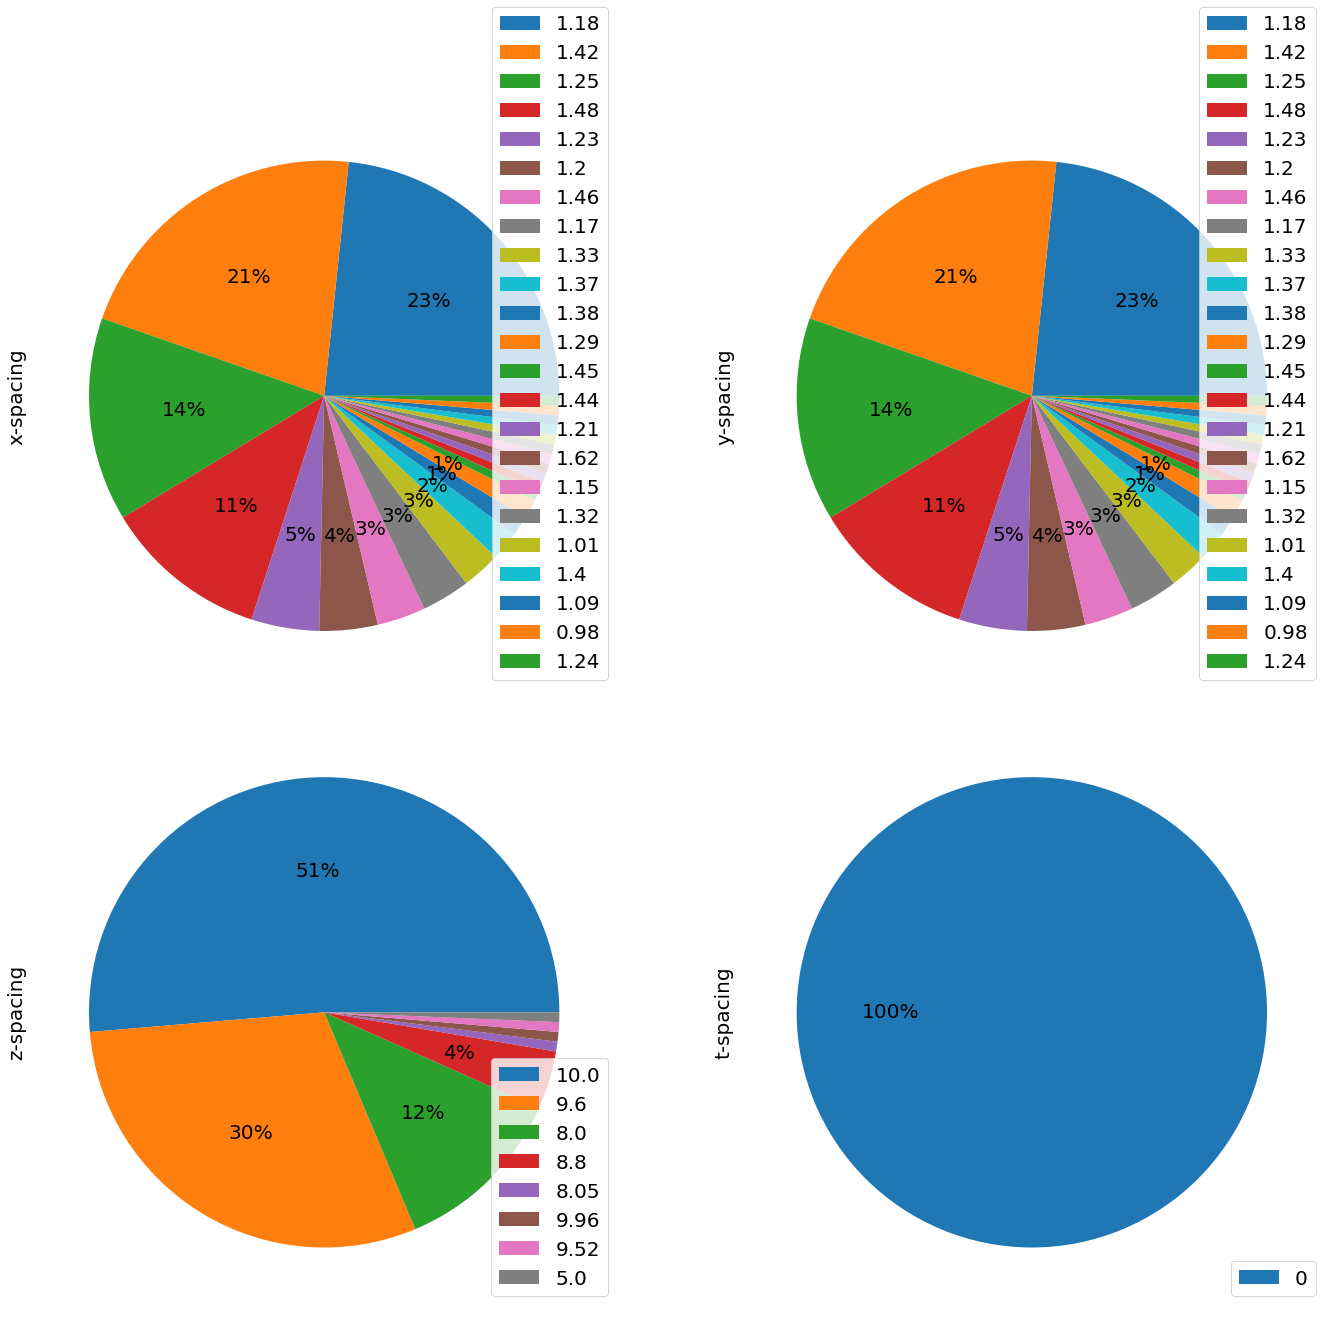

In [74]:
# show all available spacings for x, y, z and t for the ACDC-dataset
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
plt.rcParams.update({'font.size': 20})
df_acdc_4d[['x-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,0], autopct=my_autopct)
df_acdc_4d[['y-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[0,1], autopct=my_autopct)
df_acdc_4d[['z-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,0], autopct=my_autopct)
df_acdc_4d[['t-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=axes[1,1], autopct=my_autopct)
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
axes[0,0].legend(loc=4, labels=df_acdc_4d[['x-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[0,1].legend(loc=4, labels=df_acdc_4d[['y-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,0].legend(loc=4, labels=df_acdc_4d[['z-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
axes[1,1].legend(loc=4, labels=df_acdc_4d[['t-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).index)
plt.tight_layout()
plt.savefig('reports/miccai2020_spacings.pdf')

In [25]:
# create a new columns with x * y as categorical field
df_acdc_4d['resolution3d'] = [str(x) + 'x' + str(y) + 'x' + str(z) for x,y,z in zip(df_acdc_4d['x-axis'], df_acdc_4d['y-axis'], df_acdc_4d['z-axis'])]

2020-01-22 15:26:40,570 WARNING No handles with labels found to put in legend.


57


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda810d0e80>],
      dtype=object)

Text(0, 0.5, '')

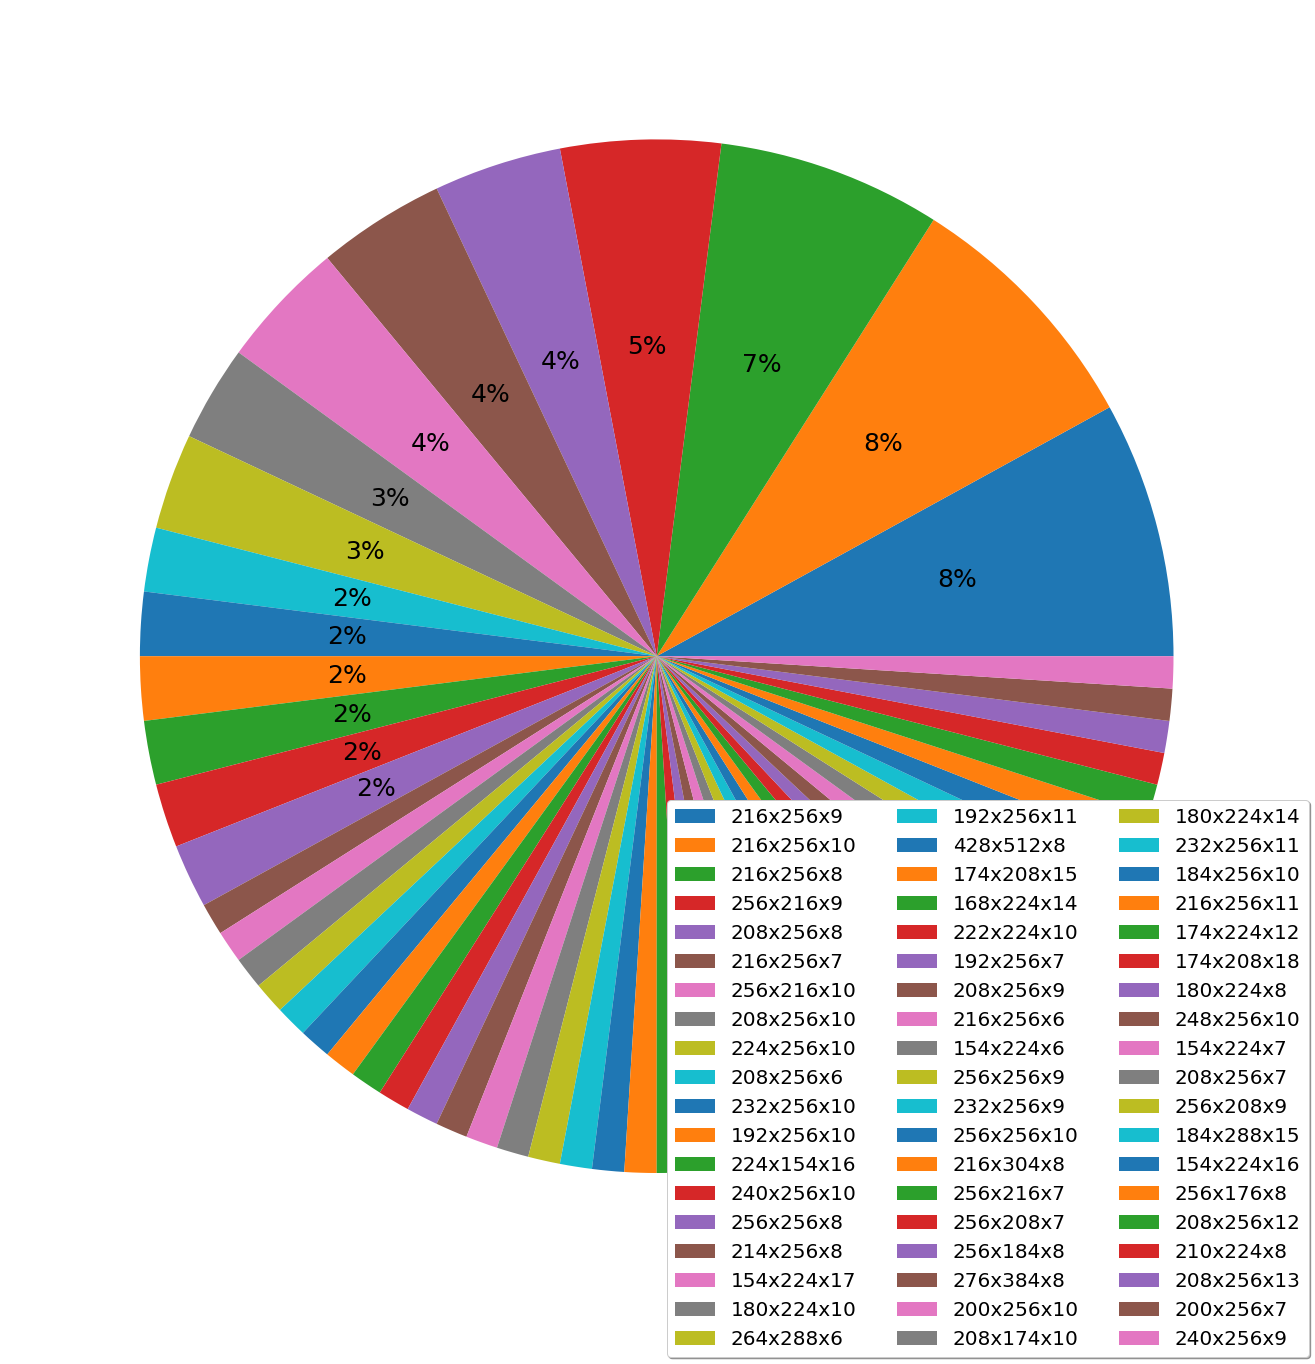

In [26]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size(20)

print(len(df_acdc_4d['resolution3d'].fillna(0).unique()))
plt.rcParams.update({'font.size':25})
fig, ax = plt.subplots(1, figsize=(20,20))
df_acdc_4d[['resolution3d']].apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=ax, autopct=my_autopct)
# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop=fontP, labels=df_acdc_4d[['resolution3d']].apply(pd.value_counts).index)
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('reports/acdc_resolutions3d.pdf', bbox_inches="tight")

In [27]:
# remove the spacing for the t axis, which is always 1
df_acdc_4d['spacing'] = df_acdc_4d['spacing'].apply(lambda x : x[:-1] if (len(x)>3) else x)
# round each spacing to 2 decimal digits
df_acdc_4d['spacing'] = df_acdc_4d['spacing'].apply(lambda x : (round(x[0], 2), round(x[1], 2), round(x[2], 2)))

2020-01-22 15:29:10,322 WARNING No handles with labels found to put in legend.


23


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda80ed1470>],
      dtype=object)

Text(0, 0.5, '')

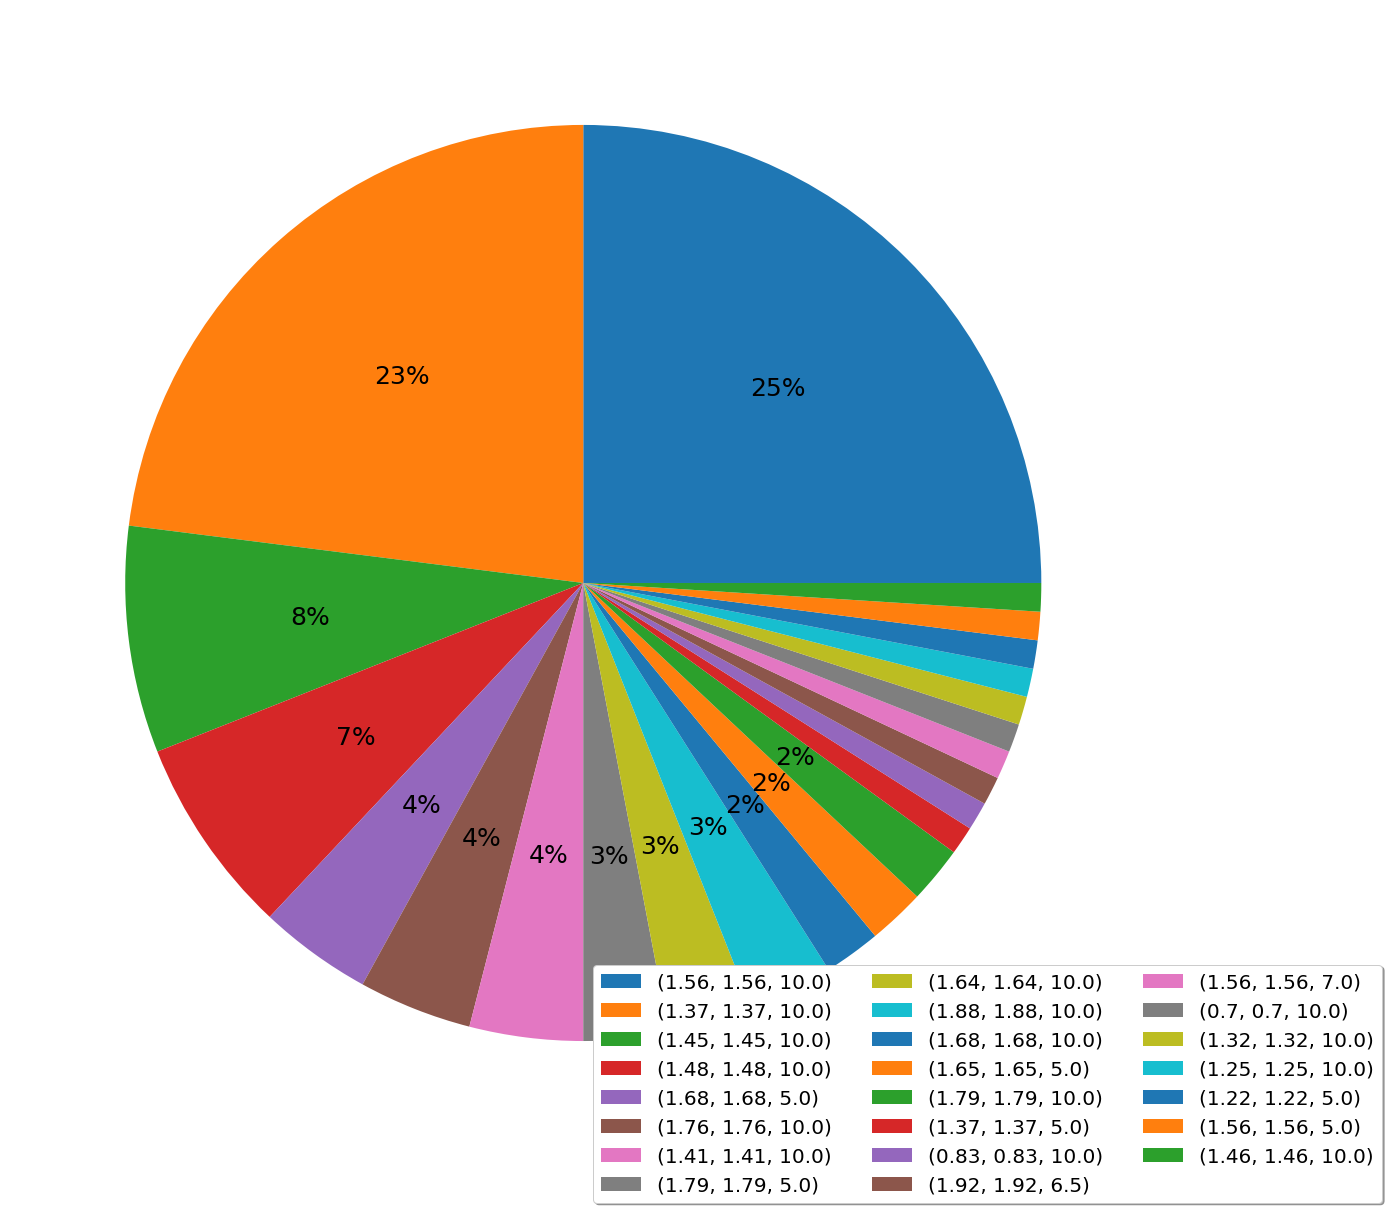

In [28]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size(20)
print(len(df_acdc_4d['spacing'].fillna(0).unique()))
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(1, figsize=(20,20))

df_acdc_4d[['spacing']].apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=ax, autopct=my_autopct)
ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop=fontP, labels=df_acdc_4d[['spacing']].apply(pd.value_counts).index)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=df_4d[['spacing']].apply(pd.value_counts).index)
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('reports/acdc_spacings3d.pdf', bbox_inches="tight")

# Piechart of the Y-axis shape and spacing

<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc78d3e2198>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

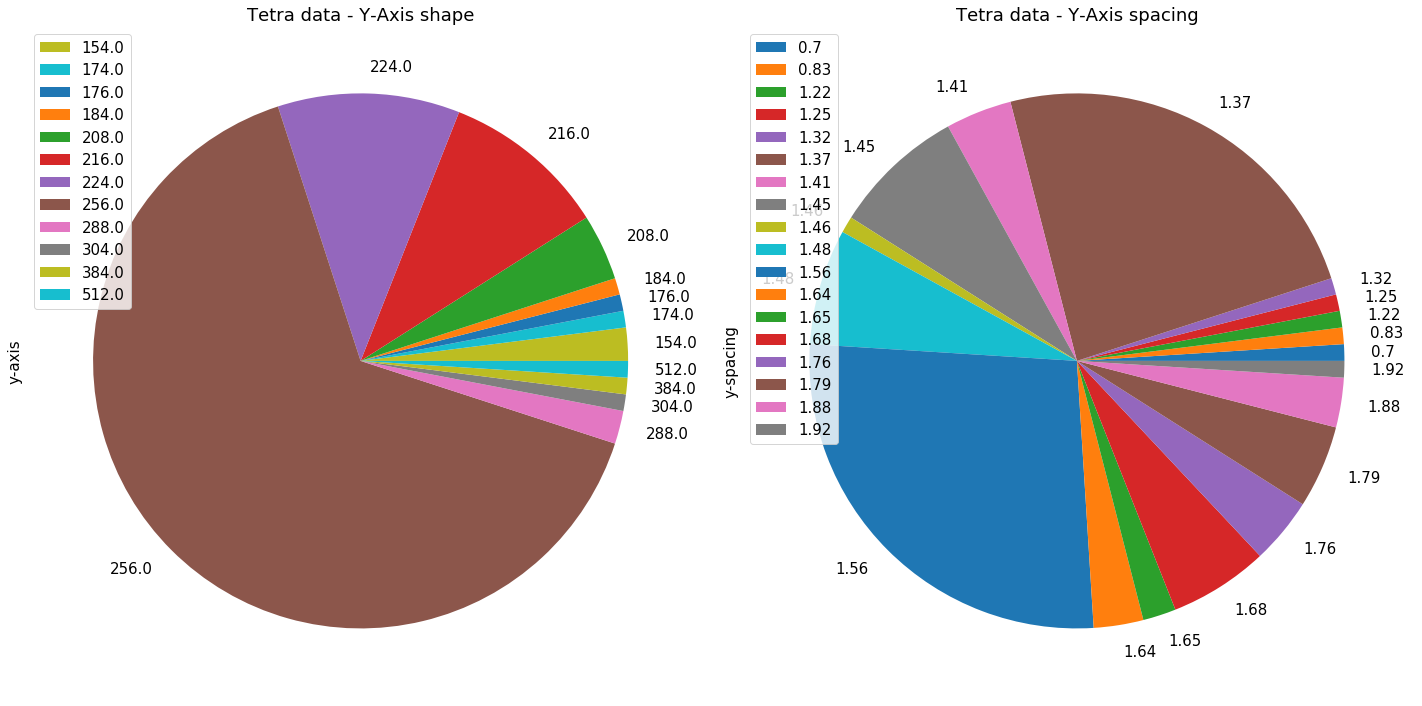

In [46]:

plt.figure()
df_acdc_4d[['y-axis', 'y-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['Tetra data - Y-Axis shape', 'Tetra data - Y-Axis spacing'])
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
plt.tight_layout()

# Piechart of the X-axis shape and spacing

<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc78d0b2fd0>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

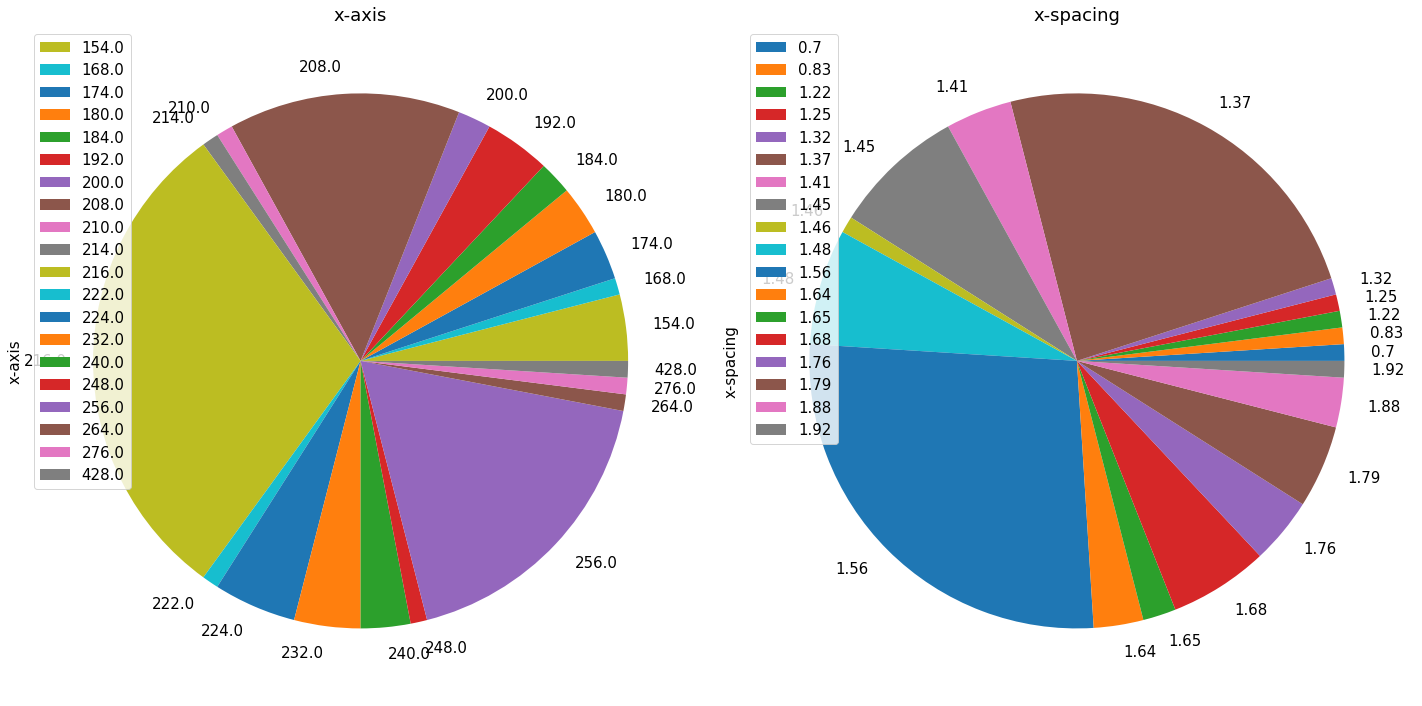

In [47]:

plt.figure()
df_acdc_4d[['x-axis', 'x-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['x-axis', 'x-spacing'])
plt.tight_layout()

# Piechart of the Z-axis

<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc78cf06588>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

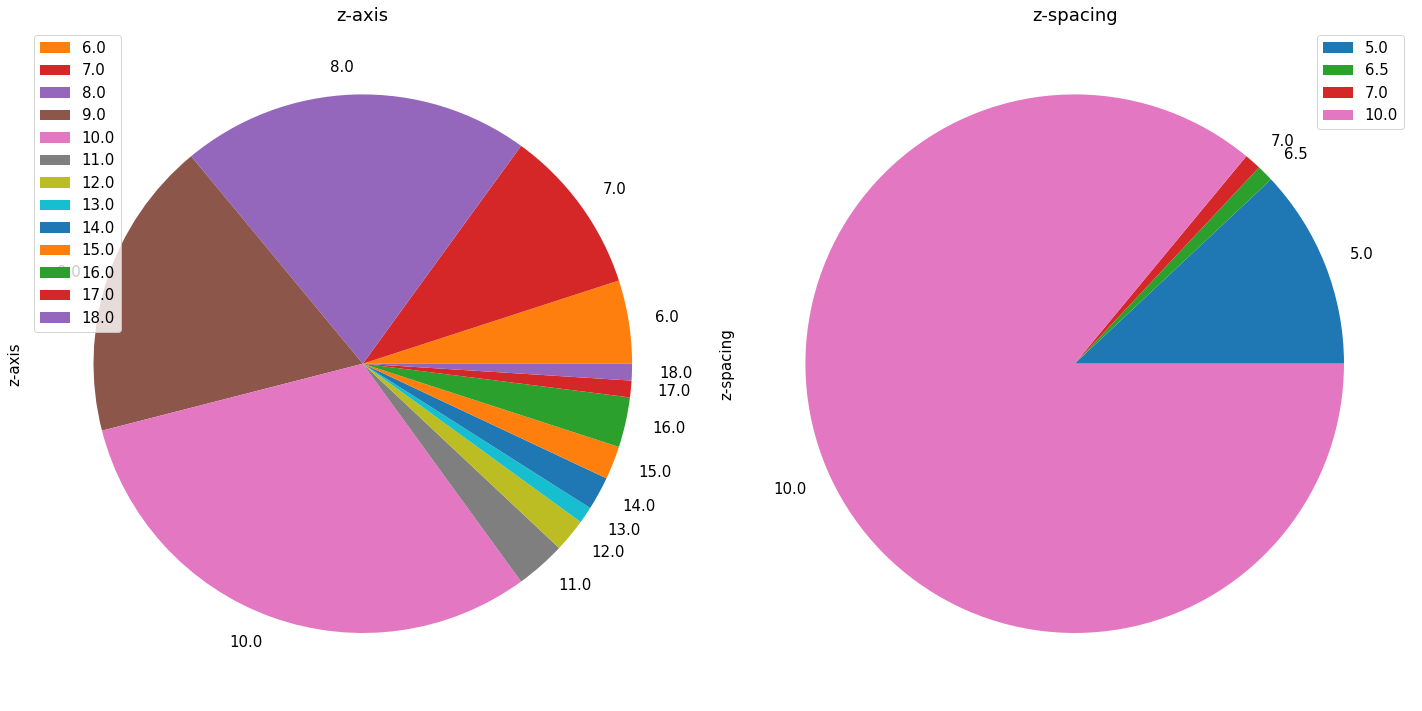

In [48]:

plt.figure()
df_acdc_4d[['z-axis', 'z-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['z-axis', 'z-spacing'])
plt.tight_layout()

# Piechart of the 3d resolution

In [7]:
# create a new columns with x * y as categorical field
df_4d['resolution3d'] = [str(x) + 'x' + str(y) + 'x' + str(z) for x,y,z in zip(df_4d['x-axis'], df_4d['y-axis'], df_4d['z-axis'])]

In [24]:
def my_autopct(pct):
    return ('%1.0f%%'% pct) if pct > 1 else ''

2020-01-12 13:33:03,668 WARNING No handles with labels found to put in legend.


51


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcab2ec9ef0>],
      dtype=object)

Text(0, 0.5, '')

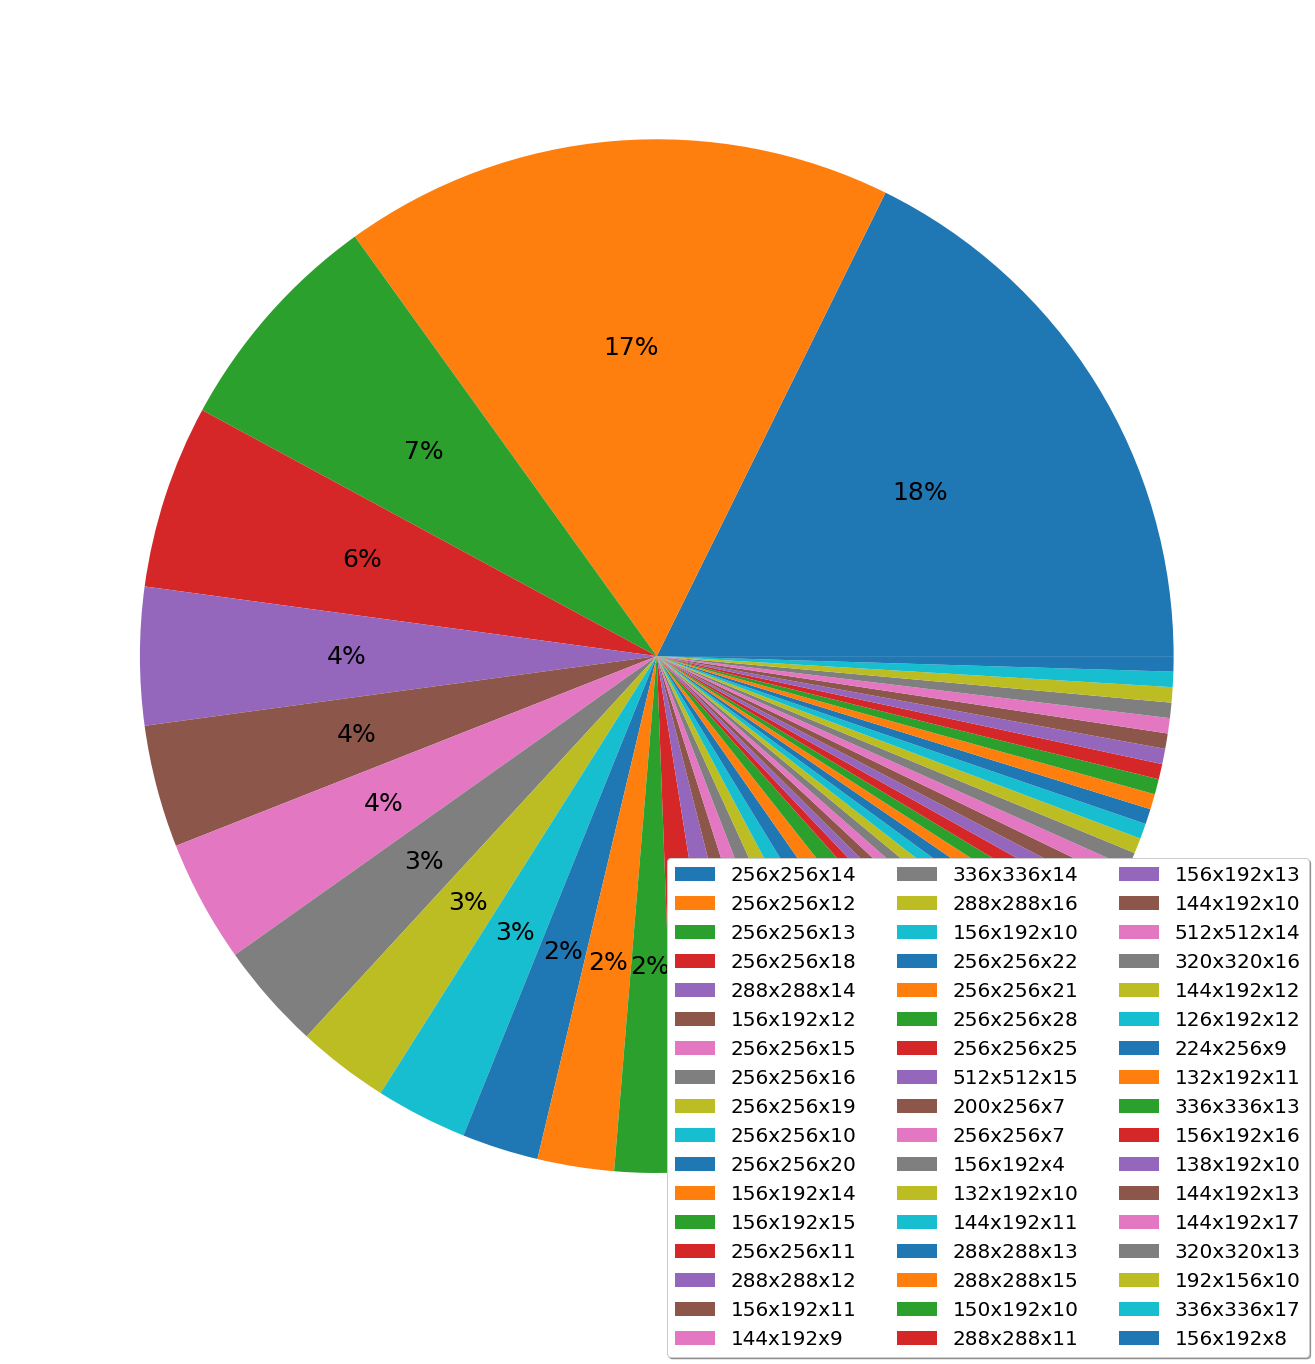

In [53]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size(20)

print(len(df_4d['resolution3d'].fillna(0).unique()))
plt.rcParams.update({'font.size':25})
fig, ax = plt.subplots(1, figsize=(20,20))
df_4d[['resolution3d']].apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=ax, autopct=my_autopct)
# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop=fontP, labels=df_4d[['resolution3d']].apply(pd.value_counts).index)
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('reports/gcn_resolutions.pdf', bbox_inches="tight")



In [28]:
# remove the spacing for the t axis, which is always 1
df_4d['spacing'] = df_4d['spacing'].apply(lambda x : x[:-1] if (len(x)>3) else x)
# round each spacing to 2 decimal digits
df_4d['spacing'] = df_4d['spacing'].apply(lambda x : (round(x[0], 2), round(x[1], 2), round(x[2], 2)))

2020-01-12 13:33:14,923 WARNING No handles with labels found to put in legend.


50


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcab2d9d1d0>],
      dtype=object)

Text(0, 0.5, '')

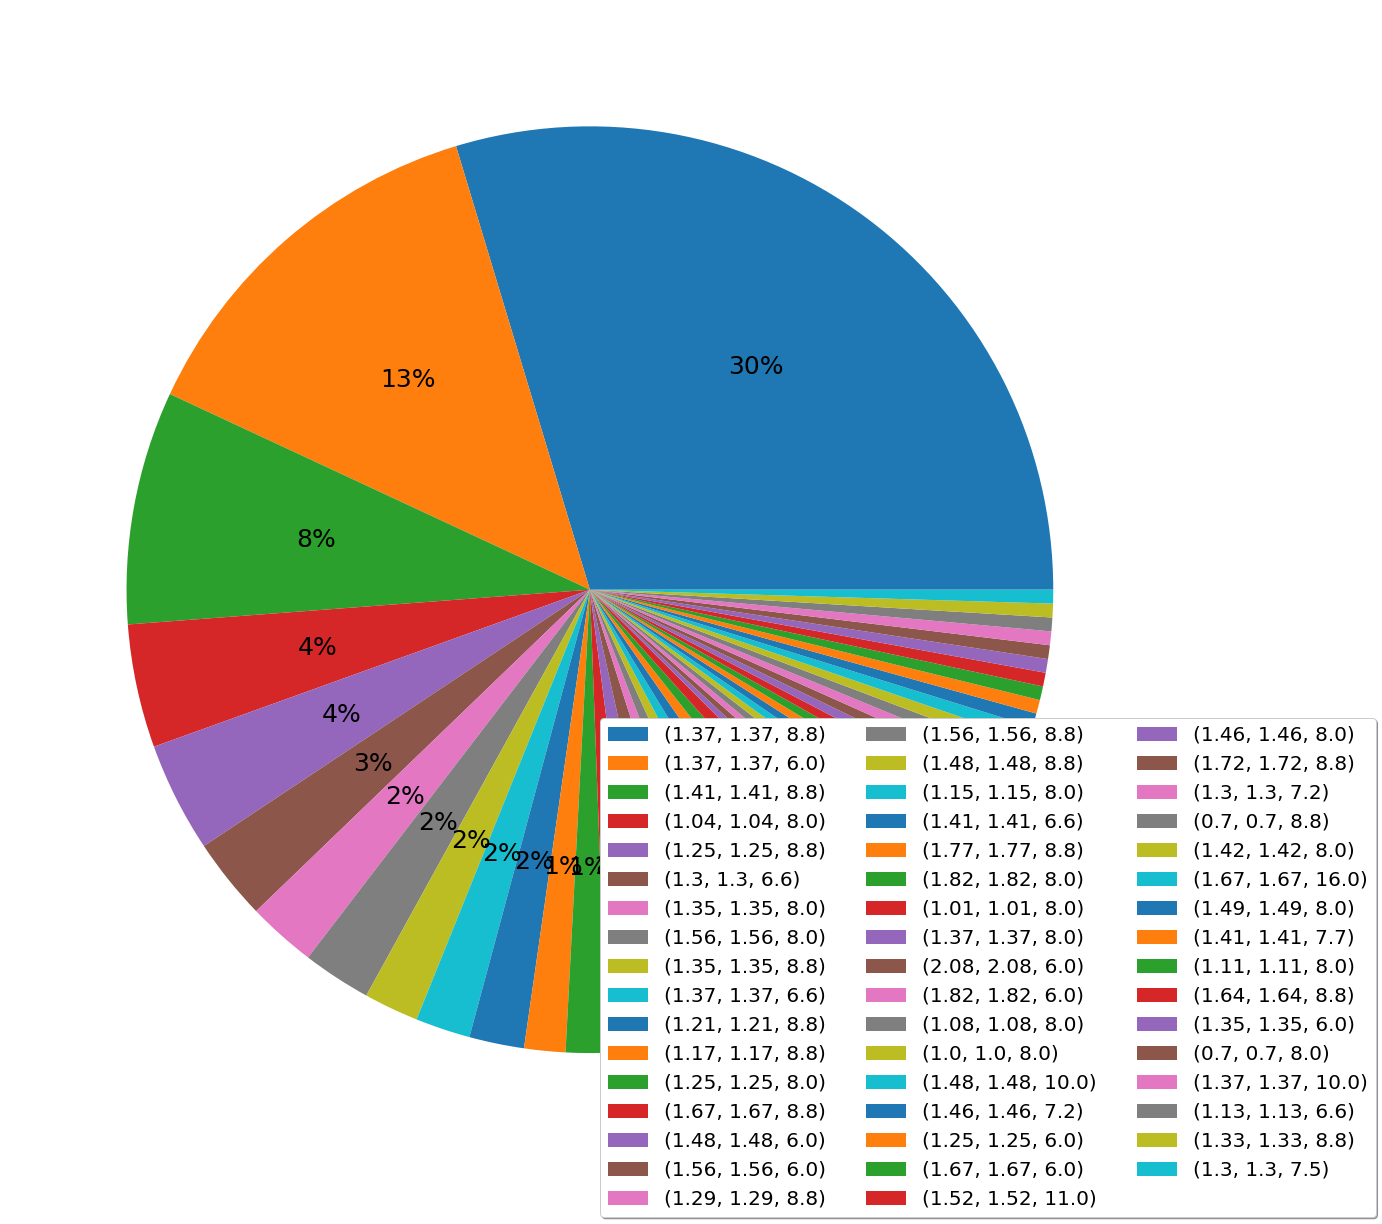

In [54]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size(20)
print(len(df_4d['spacing'].fillna(0).unique()))
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(1, figsize=(20,20))

#df_4d[['spacing']].apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['Tetra data - X-/y-/ and Z-spacing'], legend=False)
df_4d[['spacing']].apply(pd.value_counts).plot(kind='pie', subplots=True, labels=None, ax=ax, autopct=my_autopct)
ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop=fontP, labels=df_4d[['spacing']].apply(pd.value_counts).index)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=df_4d[['spacing']].apply(pd.value_counts).index)
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('reports/gcn_spacings.pdf', bbox_inches="tight")

In [52]:
plt.rcParams.update({'font.size': 20})

## Describe 3D Nrrd dataset

In [26]:
#paths = ['data/processed/train', 'data/processed/test', 'data/processed/val']
paths = ['data/raw/GCN/3D/train', 'data/raw/GCN/3D/val', 'data/raw/GCN/3D/test']
dataset = 'GCN'
reports_folder = 'reports/tetra_3d_train_histogram'
ensure_dir(reports_folder)

In [27]:
dataframes = [describe_path(path=path, dataset=dataset, plot_histogram=False) for path in paths]

df = pd.concat(dataframes)

for frame, path in zip(dataframes, paths):
    frame.to_csv(os.path.join(reports_folder, os.path.basename(path)) + '.csv', sep=";", index=False)
df_tetra = dataframes[0]
logging.info('shape: {}'.format(df[df['image']==True].shape))

2020-01-07 12:03:20,243 INFO Using GCN dataset
2020-01-07 12:03:20,249 INFO describing path: data/raw/GCN/3D/train
2020-01-07 12:03:44,196 INFO Using GCN dataset
2020-01-07 12:03:44,199 INFO describing path: data/raw/GCN/3D/val
2020-01-07 12:03:48,197 INFO Using GCN dataset
2020-01-07 12:03:48,200 INFO describing path: data/raw/GCN/3D/test
2020-01-07 12:03:52,458 INFO shape: (1030, 45)


In [28]:
# load previous dataframes
dataframes = []
for path in paths:
    dataframes.append(pd.read_csv(os.path.join(reports_folder, os.path.basename(path)) + '.csv', sep=";"))
df = df = pd.concat(dataframes)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060 entries, 0 to 269
Data columns (total 45 columns):
.50-quantle                2060 non-null float64
.75-quantile               2060 non-null float64
.99-quantile               2060 non-null float64
CardiacNumberOfImages      2060 non-null object
InstitutionAddress         1930 non-null object
InstitutionName            2050 non-null object
LargestImagePixelValue     2060 non-null int64
MagneticFieldStrength      2060 non-null float64
Manufacturer               2060 non-null object
ManufacturerModelName      2060 non-null object
PatientAge                 2060 non-null object
PatientBirthDate           2010 non-null float64
PatientID                  2060 non-null object
PatientPosition            2060 non-null object
PatientSex                 2040 non-null object
PatientSize                2060 non-null object
PatientWeight              2060 non-null object
ReferringPhysicianName     1628 non-null object
SeriesDescription         

# Piechart of the Y-axis shape and spacing

<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd16f4208>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

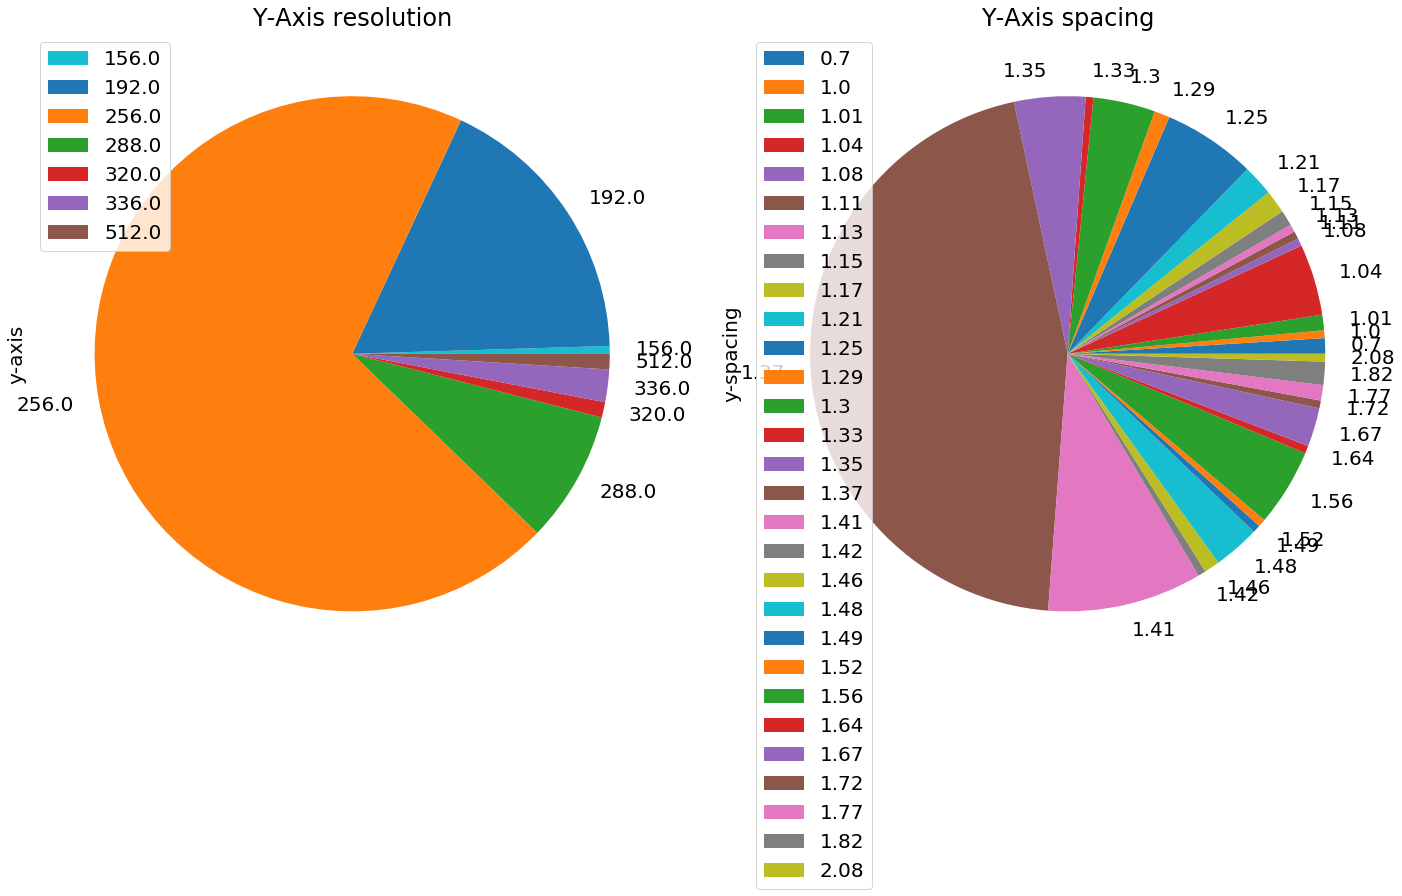

In [30]:

plt.figure()
df[['y-axis', 'y-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['Y-Axis resolution', 'Y-Axis spacing'])
#plt.title('Tetra data - Shape and spacing on the Y-Axis')
plt.tight_layout()

# Piechart of the X-axis shape and spacing

<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd143f2b0>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

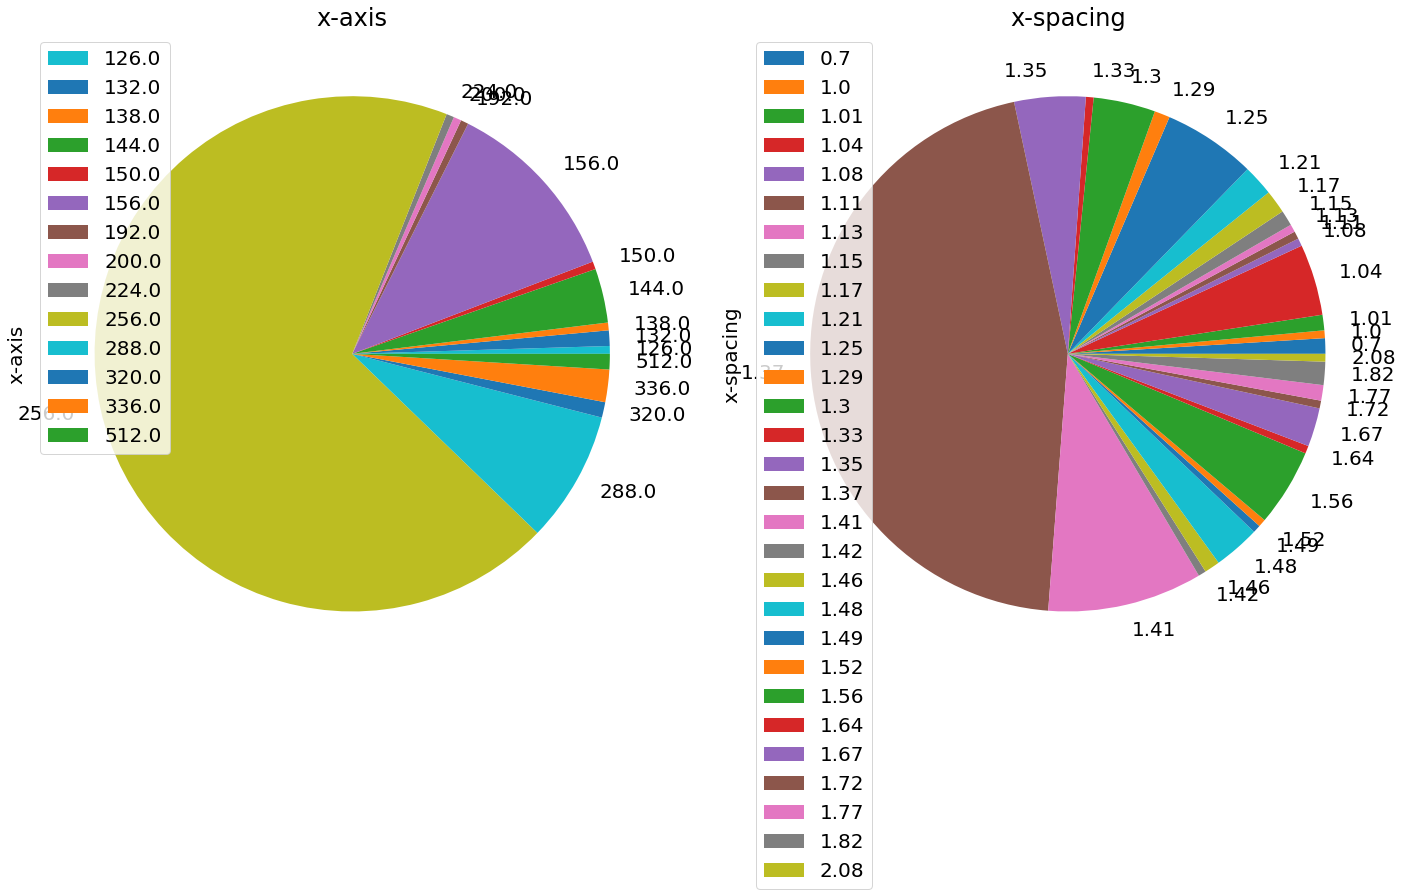

In [31]:

plt.figure()
df[['x-axis', 'x-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['x-axis', 'x-spacing'])
plt.tight_layout()

# Piechart of the Z-axis

<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd12a3dd8>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

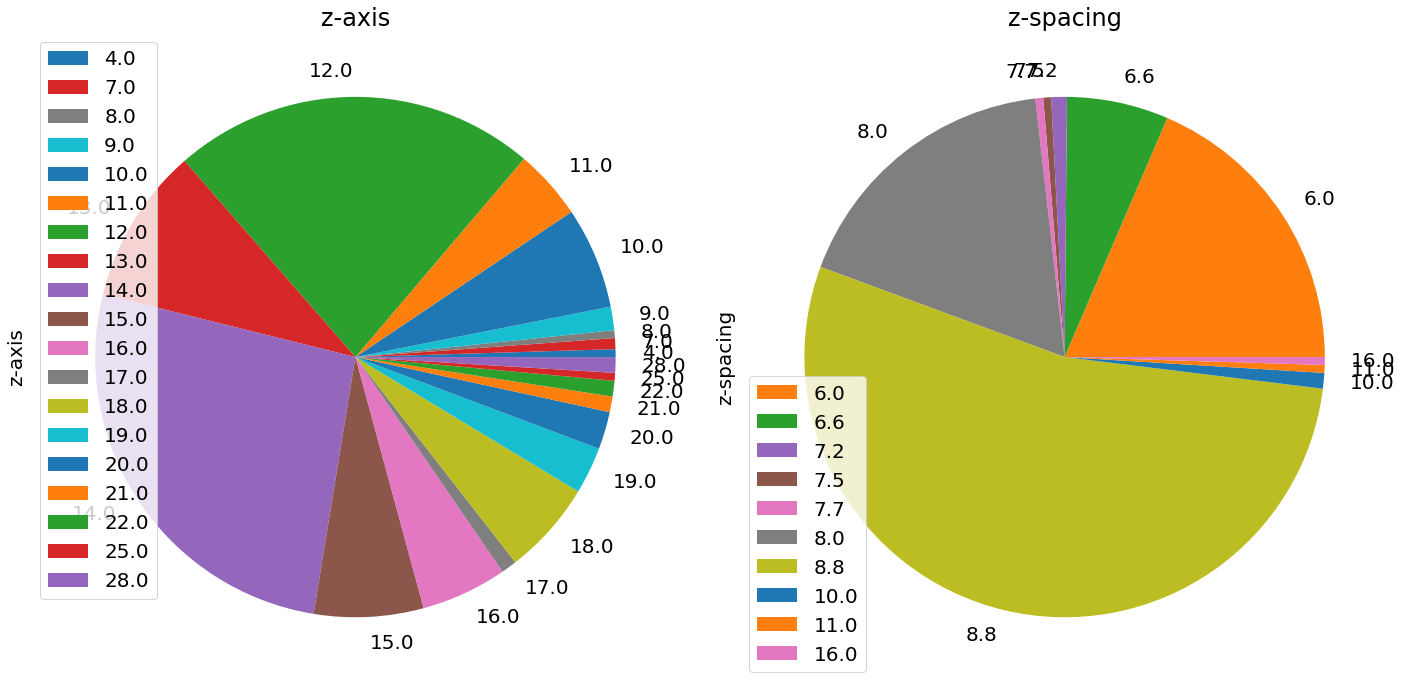

In [32]:

plt.figure()
df[['z-axis', 'z-spacing']].apply(lambda x : round(x,2)).apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['z-axis', 'z-spacing'])
plt.tight_layout()

# Piechart of the spacing

55


<Figure size 432x288 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd11b5c18>],
      dtype=object)

<Figure size 432x288 with 0 Axes>

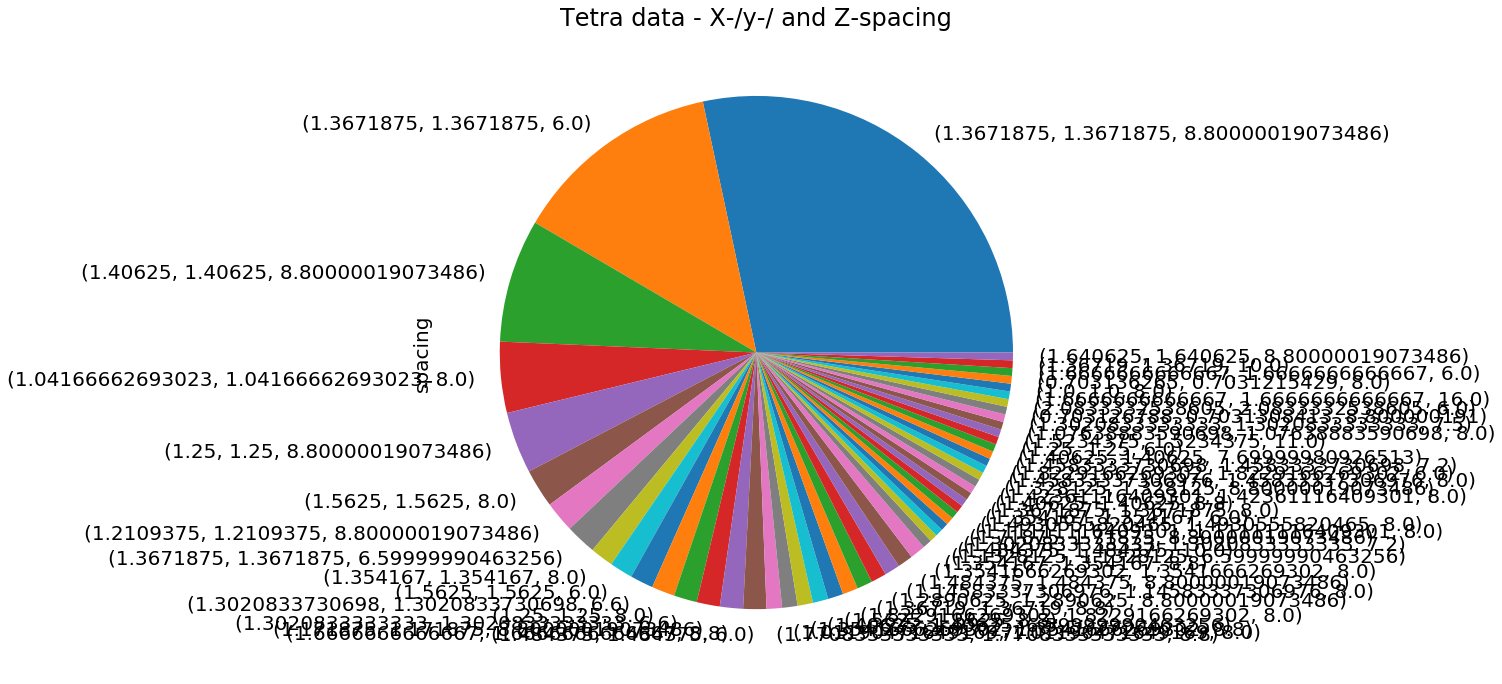

In [33]:
print(len(df['spacing'].fillna(0).unique()))

plt.figure()
df[['spacing']].apply(pd.value_counts).plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['Tetra data - X-/y-/ and Z-spacing'], legend=False)
plt.tight_layout()

## Plot mean image values and max to find volumes with very low intensity

# Scatterplot histogram median values for tetra dataset

Text(0.5, 1.0, 'Median pixel value - GCN')

Pixel mean: 214.60
Pixel std: 090.30


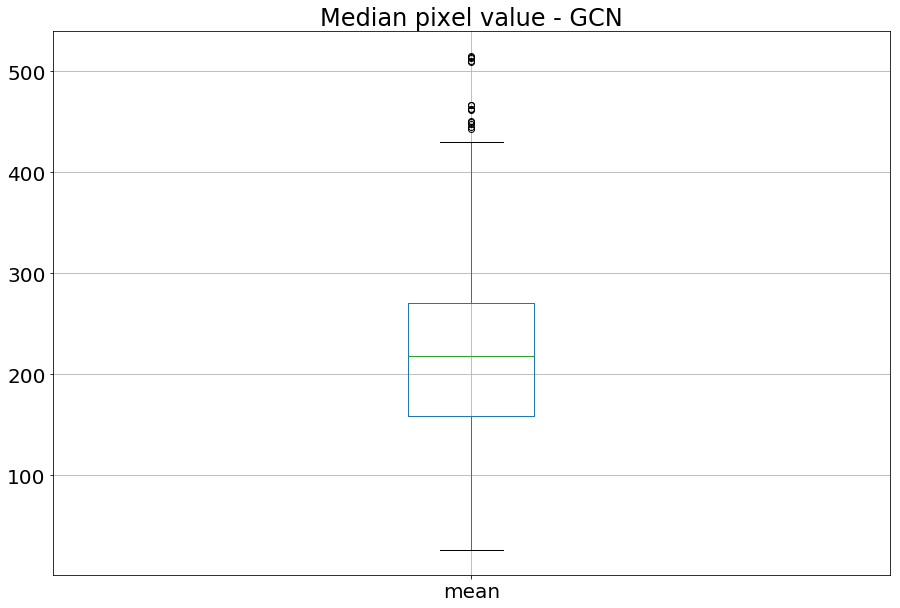

In [34]:
temp_df = df[df['image']==True]['mean']
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Median pixel value - GCN')
print('Pixel mean: {:06.2f}'.format(temp_df.mean()))
print('Pixel std: {:06.2f}'.format(temp_df.std()))
temp_df.plot.box(grid=True, use_index=True,ax=ax)

Text(0.5, 1.0, 'Mean pixel distribution - GCN')

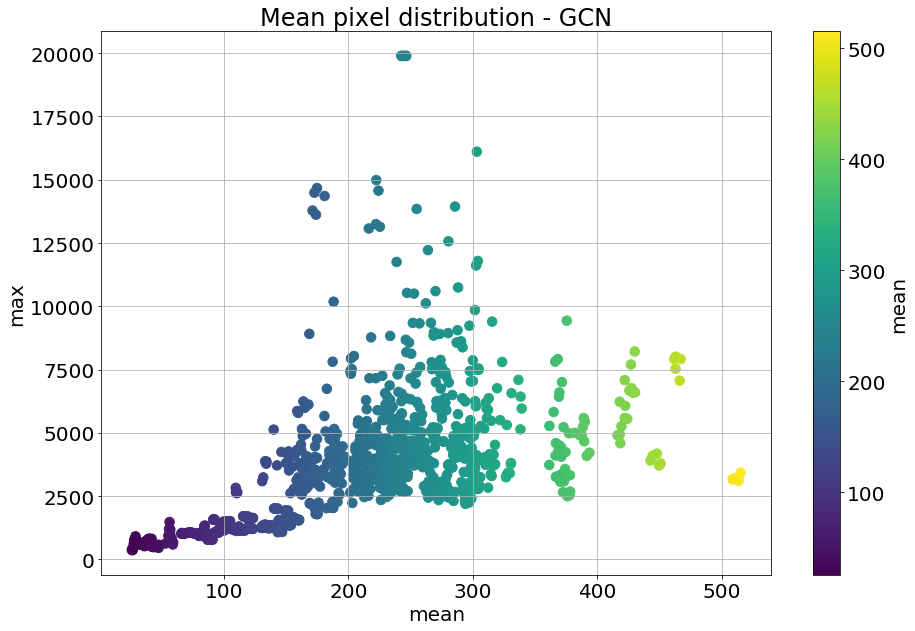

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Mean pixel distribution - GCN')
df[df['image']==True].plot.scatter(x='mean', y='max', c='mean', colormap='viridis', grid=True, use_index=True,ax=ax, s=90)

## Describe img/msk properties for ACDC dataset (create a dataframe from results)

2020-03-11 14:19:34,344 INFO Using acdc dataset
2020-03-11 14:19:34,372 INFO describing path: data/raw/ACDC/original/train


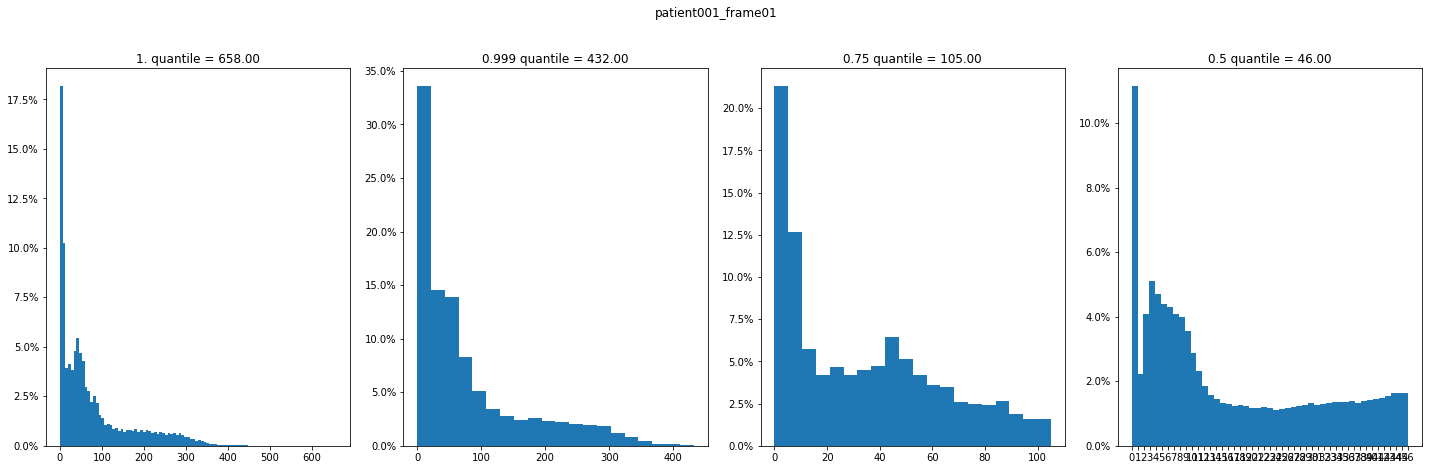

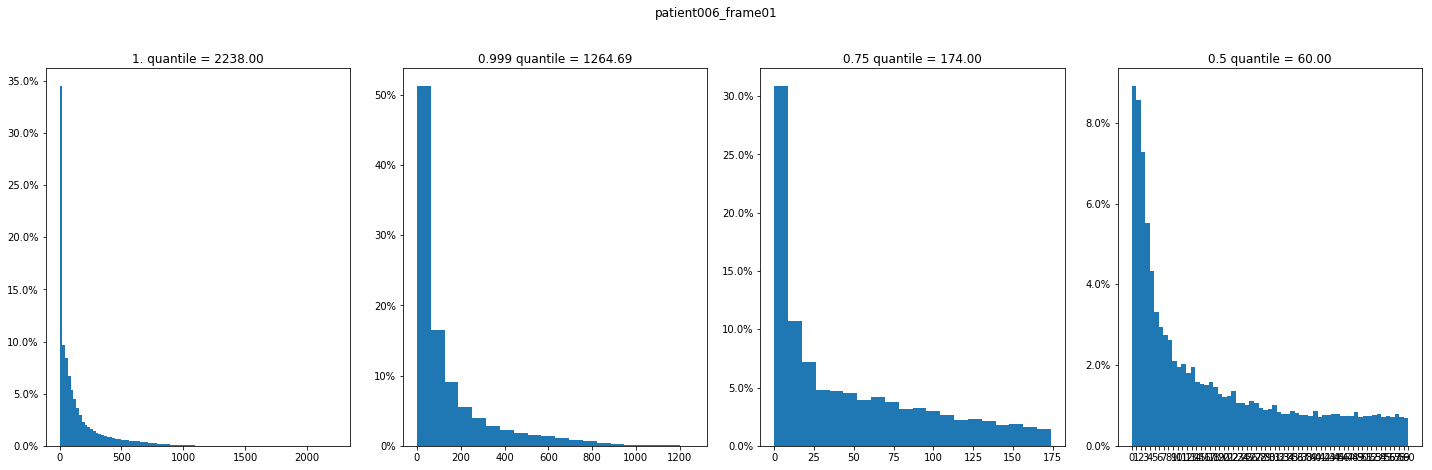

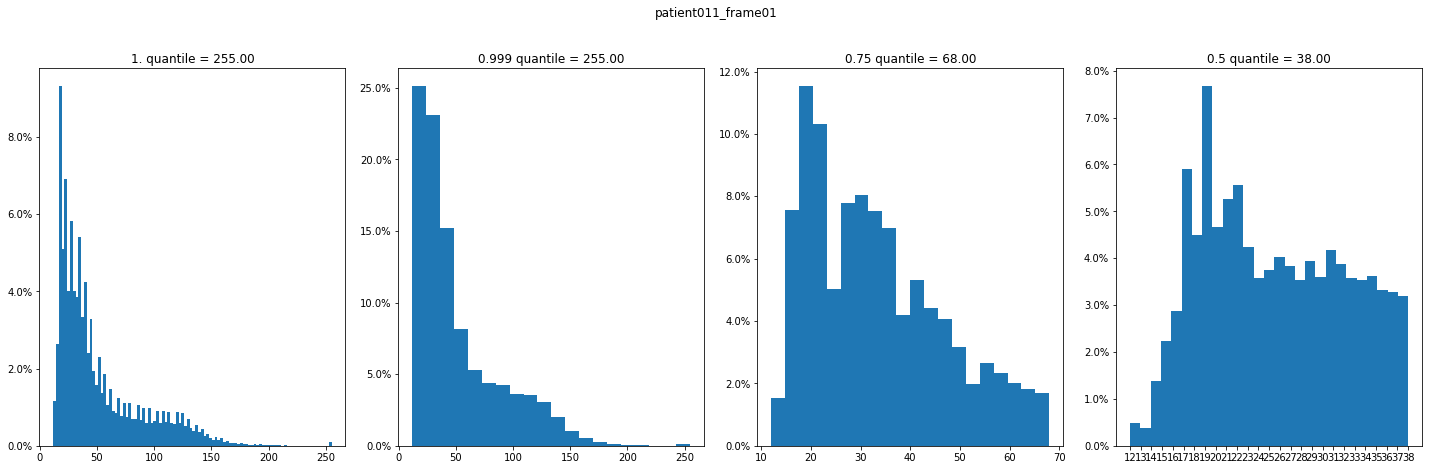

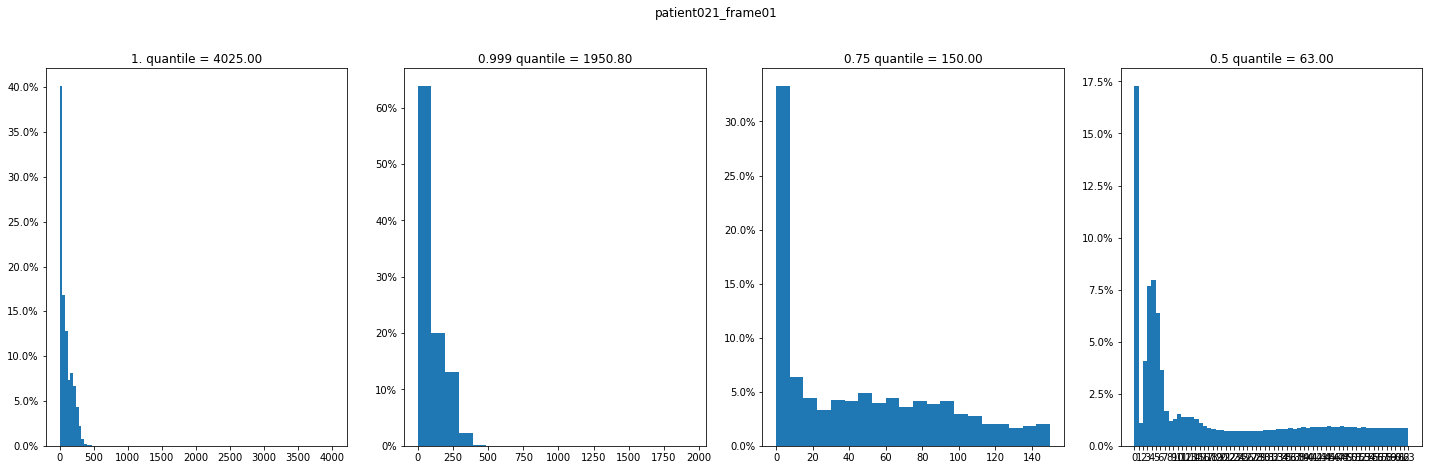

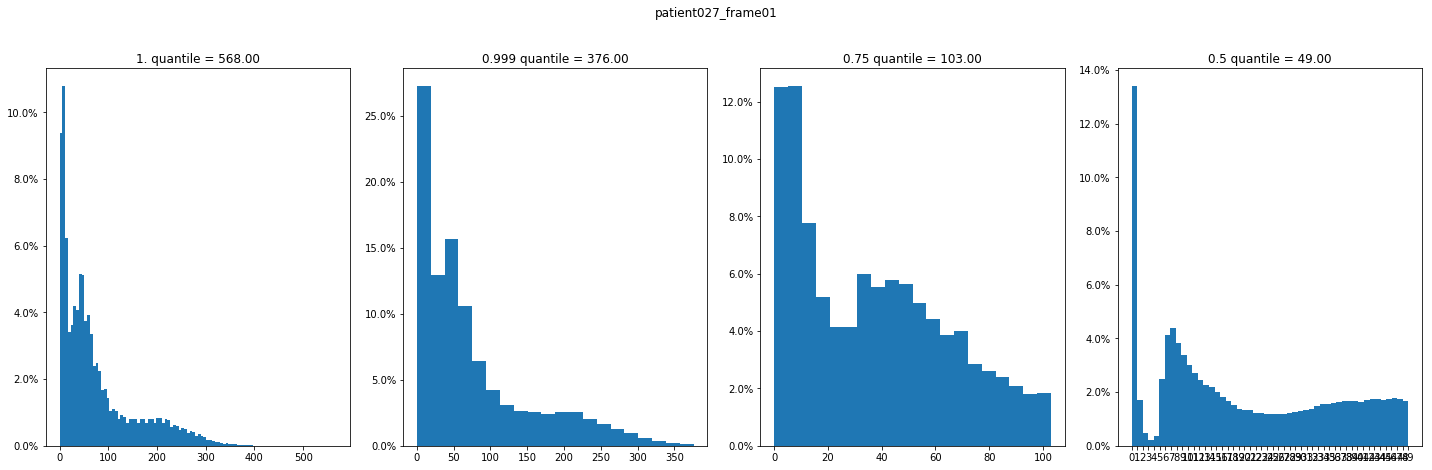

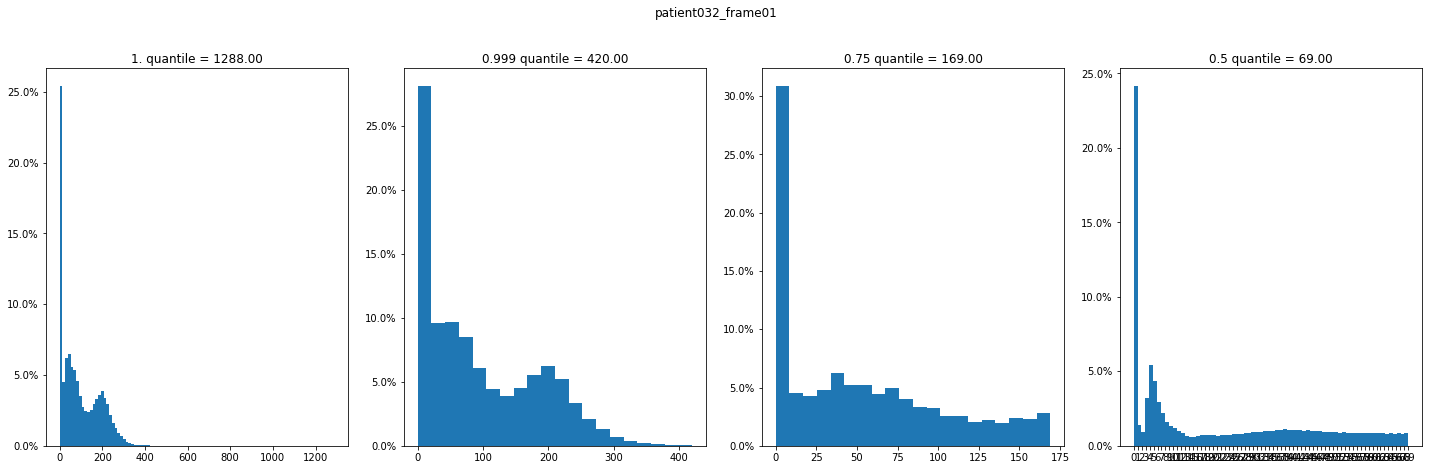

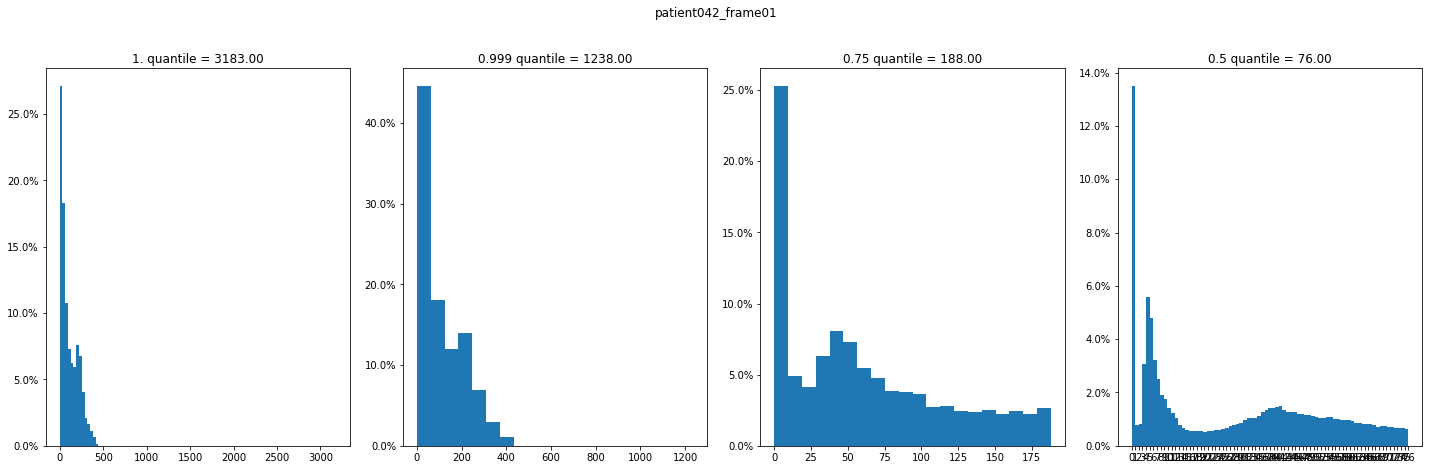

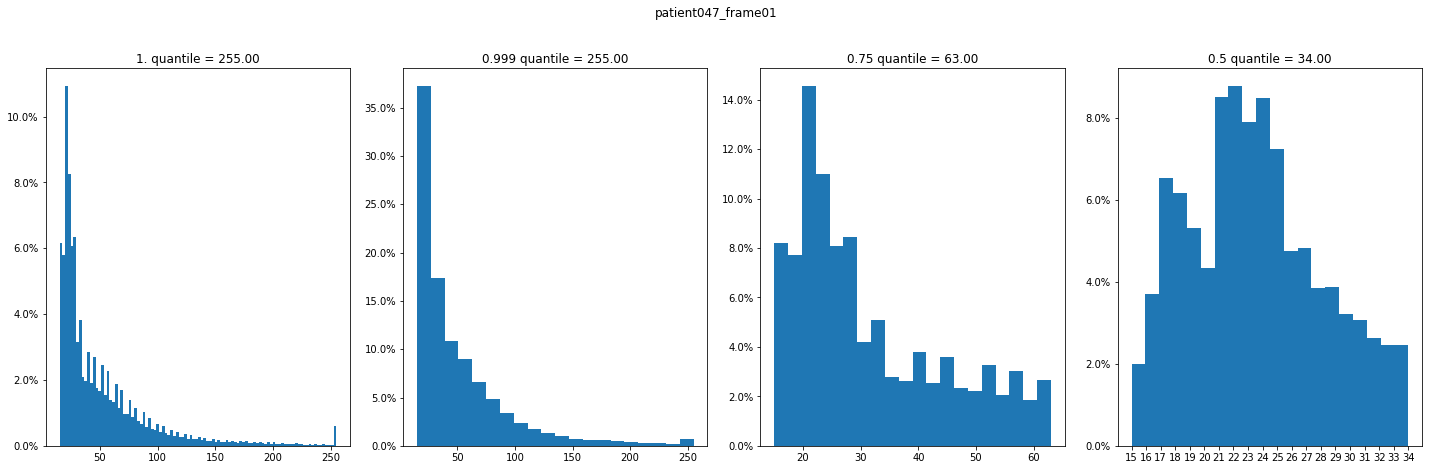

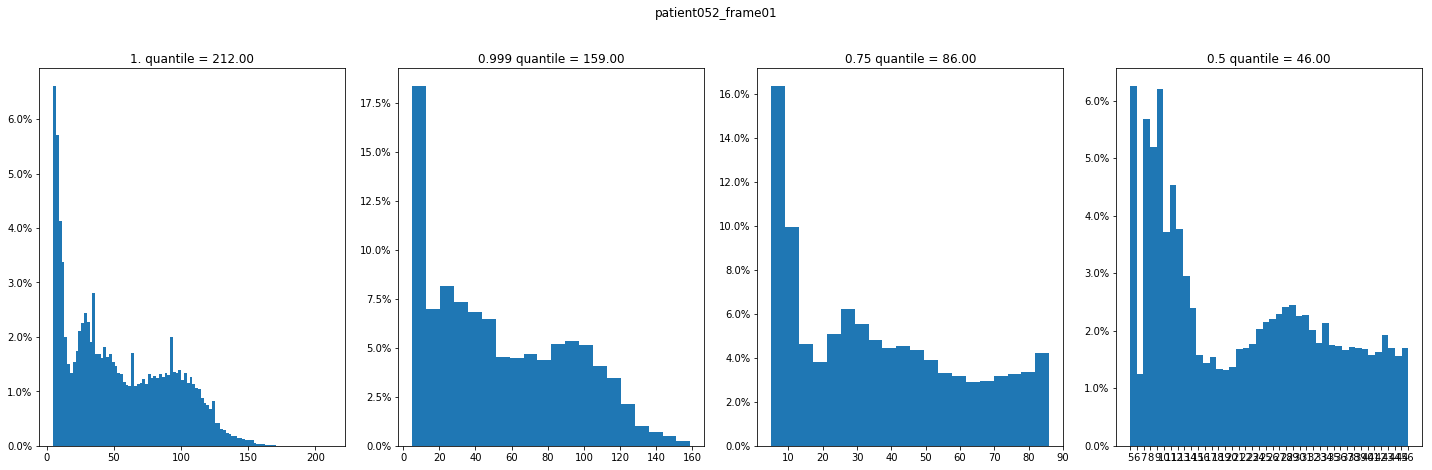

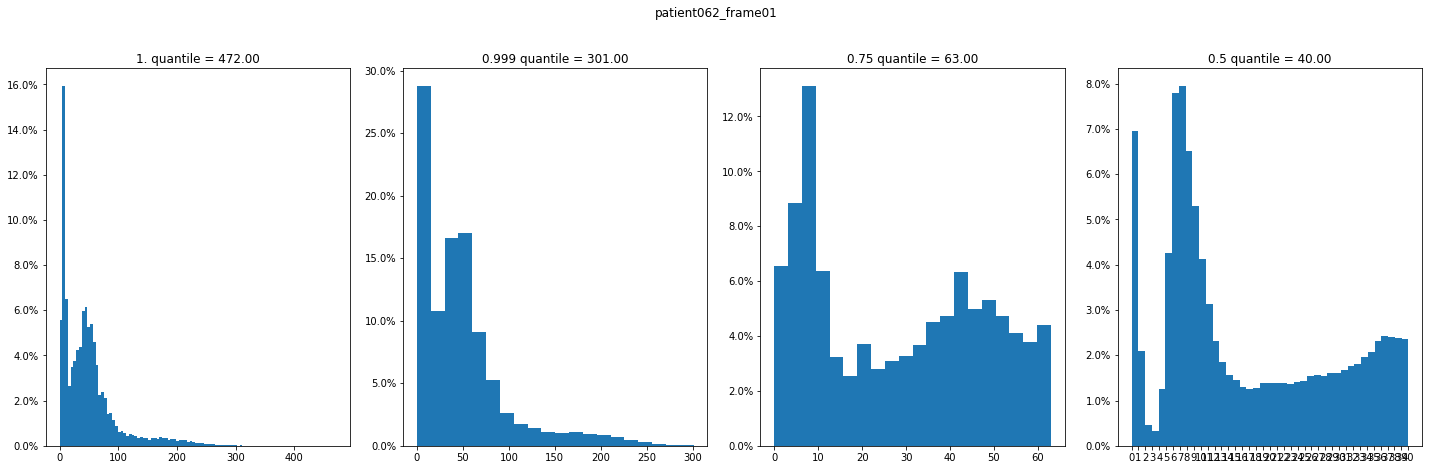

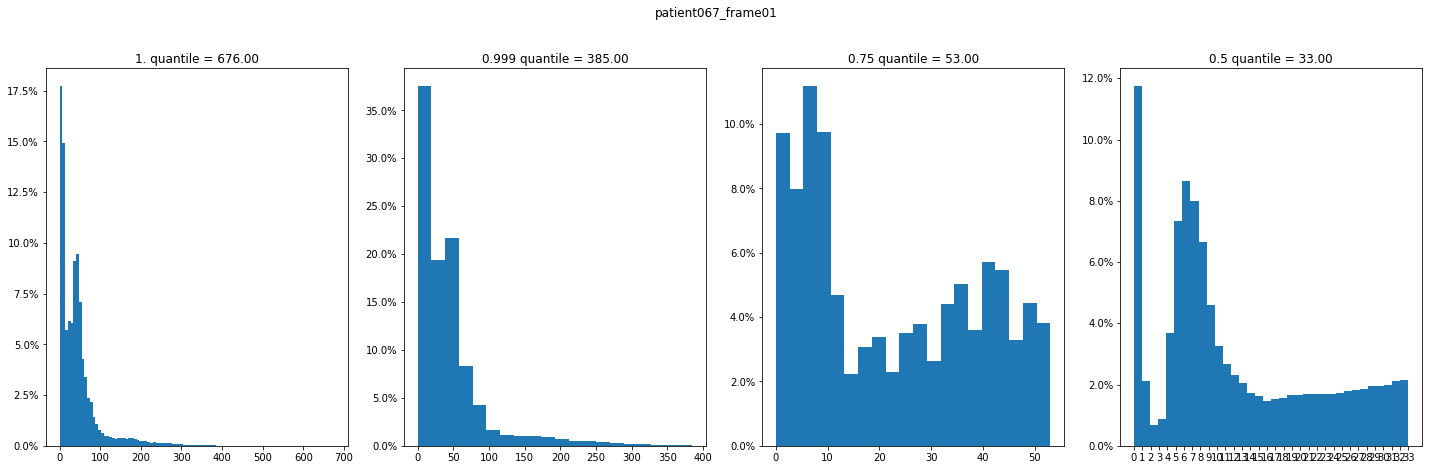

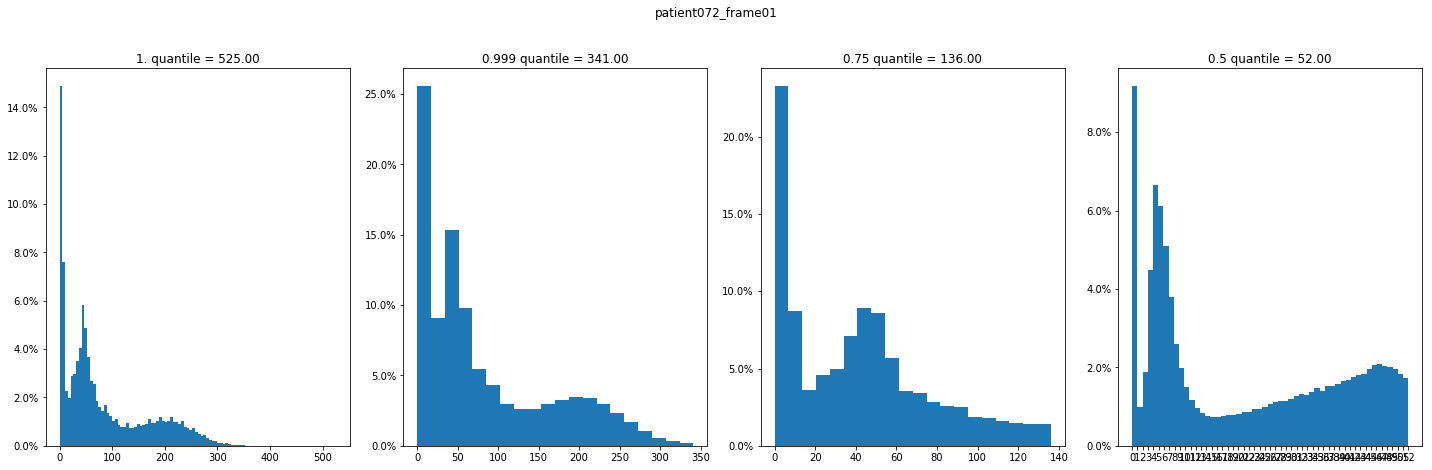

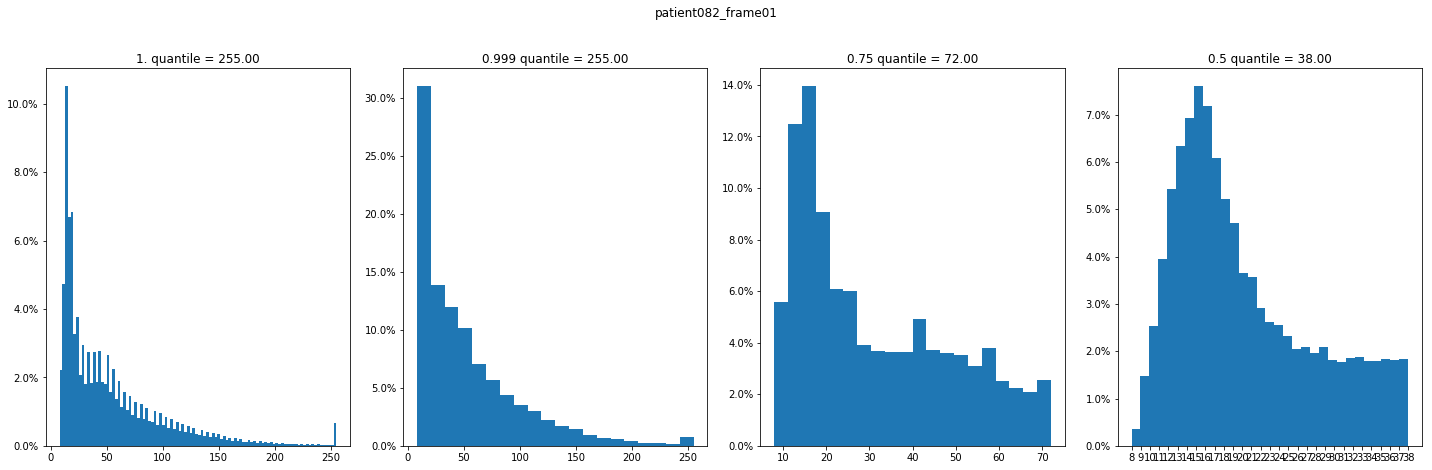

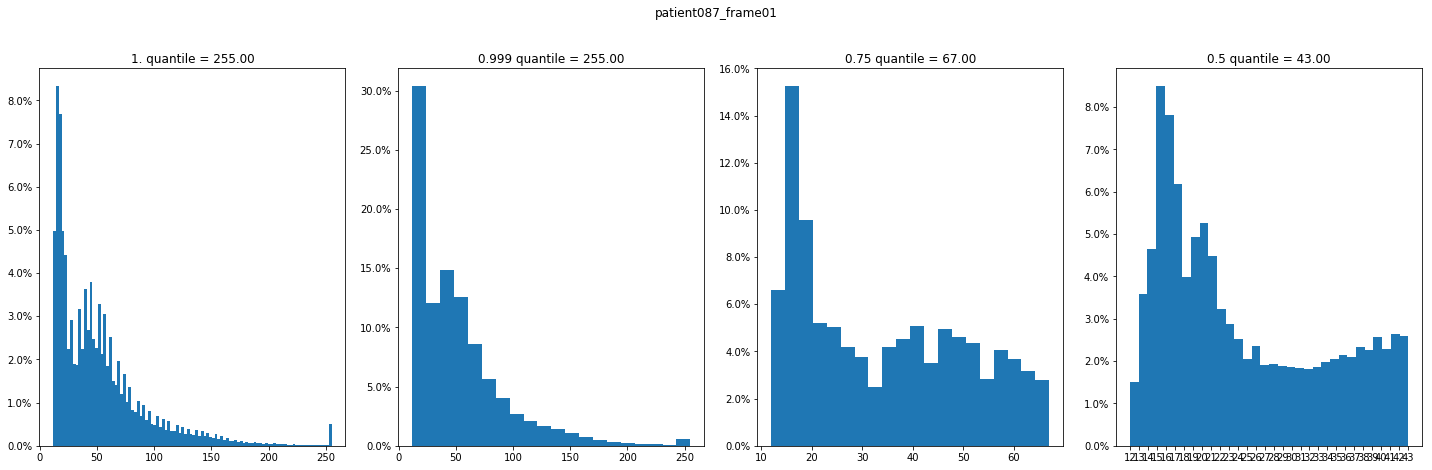

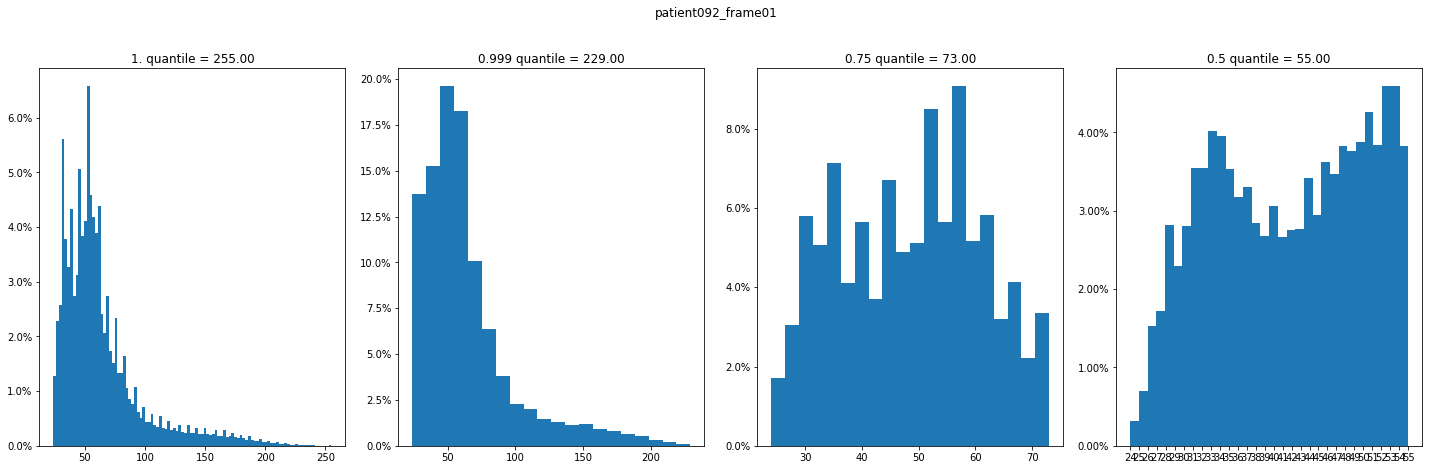

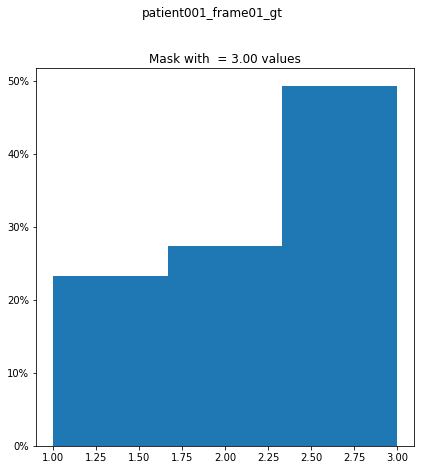

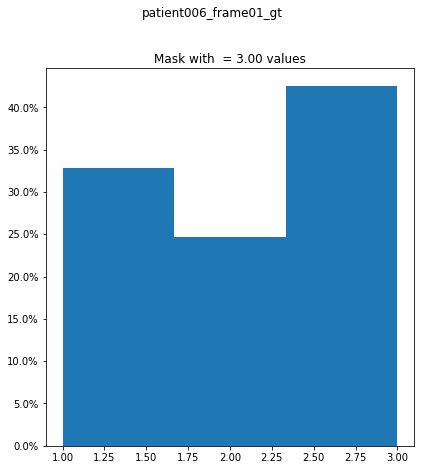

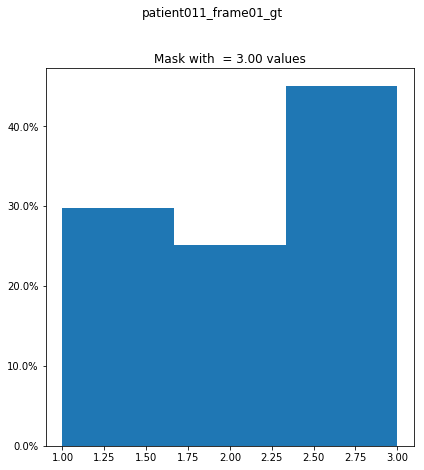

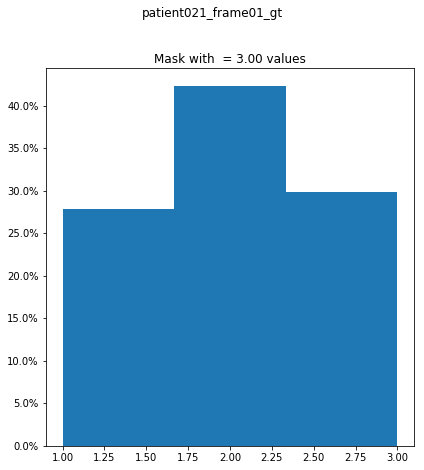

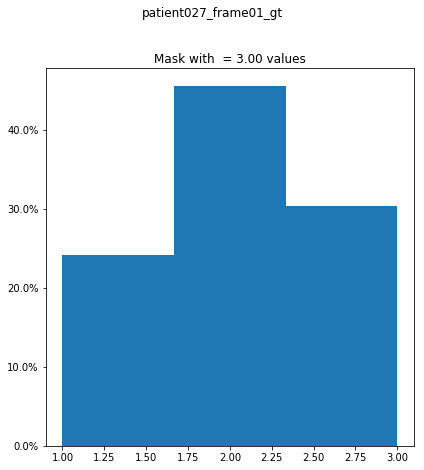

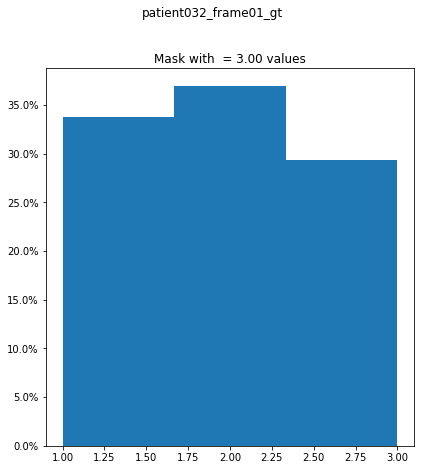

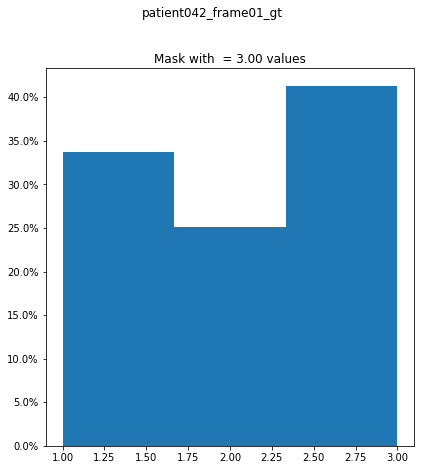

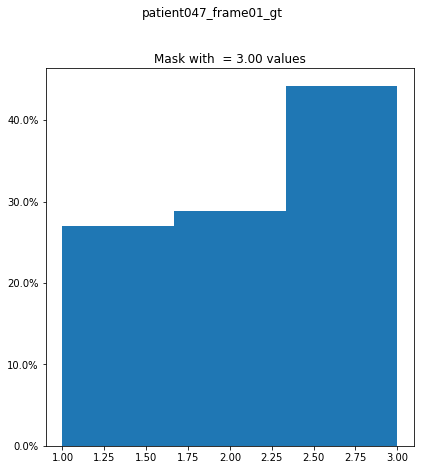

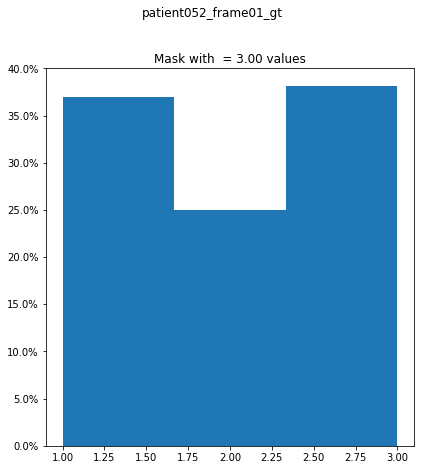

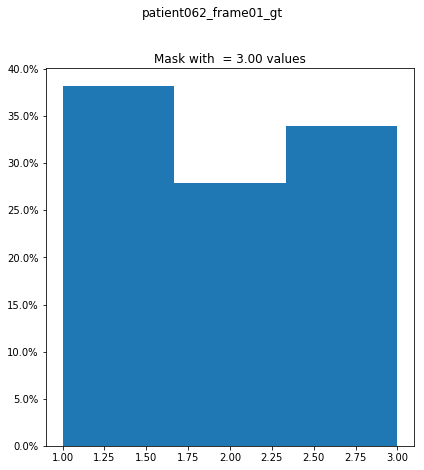

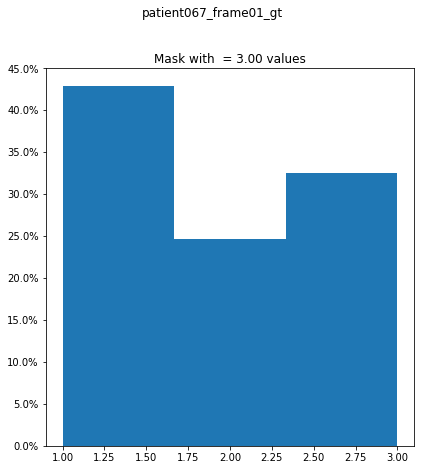

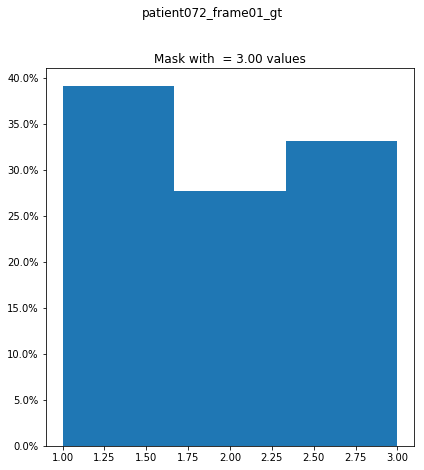

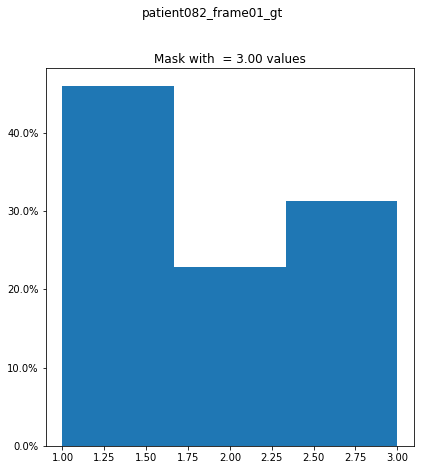

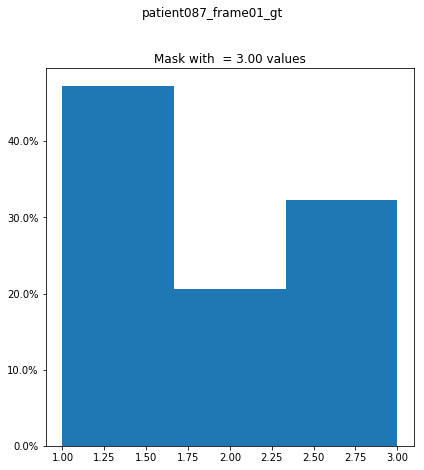

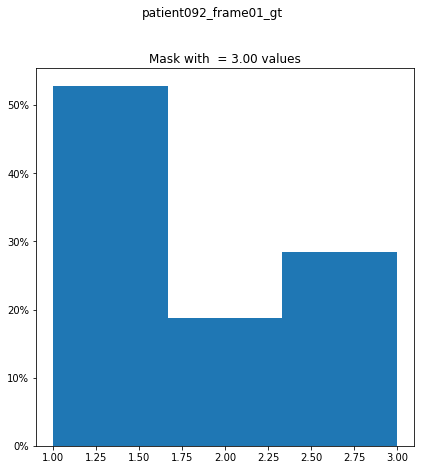

NameError: name 'df_' is not defined

In [2]:
#paths = ['data/processed/train',  'data/processed/val']
#paths = ['data/raw/tetra/3D/train/images']
paths = ['data/raw/ACDC/original/train']
dataset = 'ACDC'
reports_folder = 'reports/acdc_3d_train_histogram'
wildcard = '**/*4d.nii.gz'
ensure_dir(reports_folder)

dataframes = [describe_path(path, dataset) for path in paths]

for frame, path in zip(dataframes, paths):
    frame.to_csv(os.path.join(reports_folder, os.path.basename(path)) + '.csv', sep=";", index=False)
df_acdc = dataframes[0]
logging.info('shape: {}'.format(df_[df_['image']==True].shape))

In [ ]:
temp_df = df_acdc[df_acdc['image']==True]['mean']

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Mean pixel value - ACDC')
print('Pixel mean: {:06.2f}'.format(temp_df.mean()))
print('Pixel std: {:06.2f}'.format(temp_df.std()))

temp_df.plot.box(grid=True, use_index=True,ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Mean pixel distribution - ACDC')
df_acdc[df_acdc['image']==True].plot.scatter(x='mean', y='max', c='mean', colormap='viridis', grid=True, use_index=True,ax=ax,s=90)

## Filter volumes with X, Y, T, Z or sum of slices smaller than ...

In [22]:
df_ = df_4d
@interact
def show_volumes(column=['x-axis', 'y-axis', 't-axis', 'z-axis','slices'], x=(1,300,1)):
    filtered = df_[df_[column] > x]
    logging.info('Found: {} of {}'.format(filtered.shape, df_.shape))
    return filtered.head()

interactive(children=(Dropdown(description='column', options=('x-axis', 'y-axis', 't-axis', 'z-axis', 'slices'…

## Search for volumes with only one slice masked

In [106]:
# search for 3D volumes with less than 3 masked slices
to_be_checked = []
for f in sorted(glob.glob('data/raw/GCN/3D/**/*msk.nrrd')):
    #logging.info('check: {}'.format(f))
    img = sitk.ReadImage(f)
    nda = sitk.GetArrayFromImage(img)
    masked = 0
    for z in range(nda.shape[0]):
        if nda[z].max() > 0:
            masked = masked + 1
    if masked <= 3:
        logging.info('less than 3 masked slices: {}'.format(f))
        to_be_checked.append(f)
        #plot_3d_vol(nda)
        #plt.show()



2019-12-04 14:28:51,530 INFO less than 3 masked slices: data/raw/GCN/3D/train/0419-L1ACV3UE-2006-07-11__t6_msk.nrrd


In [ ]:
len(to_be_checked)

In [ ]:
# visualize volumes with one slice masked
@interact
def load_3d_volumes(selected=(0,len(to_be_checked), 1)):
    file_ = to_be_checked[selected]
    logging.info(file_)
    img = sitk.ReadImage(file_)
    nda = sitk.GetArrayFromImage(img)
    plot_3d_vol(nda)

In [ ]:
# check on volume if at least one needs to be checked
if len(to_be_checked) > 0:
    f_ = to_be_checked[0]
    slice_threshold = 2
    img = sitk.ReadImage(f_)
    nda_3d = sitk.GetArrayFromImage(img)
    masked_slices = 0
    for slice in nda_3d: # check how many slices are masked
        if slice.max() > 0:
            masked_slices += 1
    if masked_slices > slice_threshold:
        print('True')

# ACDC

## Get image statistics from ACDC data

In [4]:
# get all acdc 3d volume filenames
acdc_files = sorted(glob.glob(os.path.join('data/raw/ACDC/original/all/**/*4d.nii.gz')))
len(acdc_files)

100

## Spacing

In [5]:
def get_spacing(file):
    return sitk.ReadImage(file).GetSpacing()
df_acdc_spacing = pd.DataFrame([get_spacing(f) for f in acdc_files], columns=['x', 'y', 'z', 't'])

T-spacing mean: 01.00
T-spacing std: 00.00
Z-spacing mean: 09.34
Z-spacing std: 01.67
X-spacing mean: 01.51
X-spacing std: 00.19
Y-spacing mean: 01.51
Y-spacing std: 00.19


z       AxesSubplot(0.125,0.125;0.168478x0.755)
x    AxesSubplot(0.327174,0.125;0.168478x0.755)
y    AxesSubplot(0.529348,0.125;0.168478x0.755)
t    AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

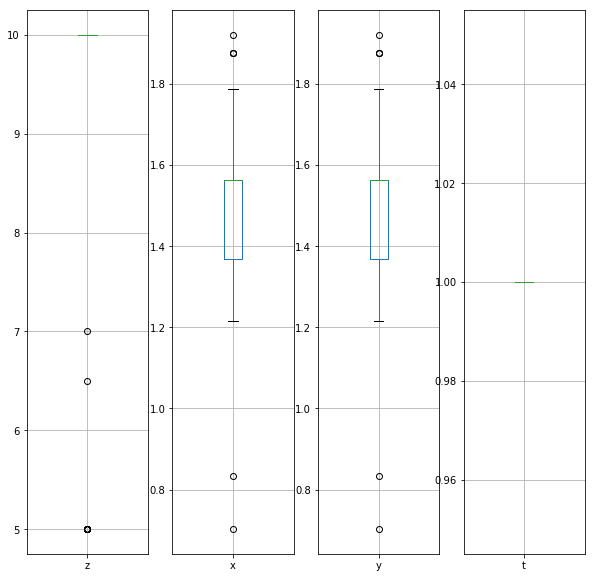

In [6]:
print('T-spacing mean: {:05.2f}'.format(df_acdc_spacing['t'].mean()))
print('T-spacing std: {:05.2f}'.format(df_acdc_spacing['t'].std()))
print('Z-spacing mean: {:05.2f}'.format(df_acdc_spacing['z'].mean()))
print('Z-spacing std: {:05.2f}'.format(df_acdc_spacing['z'].std()))
print('X-spacing mean: {:05.2f}'.format(df_acdc_spacing['x'].mean()))
print('X-spacing std: {:05.2f}'.format(df_acdc_spacing['x'].std()))
print('Y-spacing mean: {:05.2f}'.format(df_acdc_spacing['y'].mean()))
print('Y-spacing std: {:05.2f}'.format(df_acdc_spacing['y'].std()))

df_acdc_spacing[['z', 'x', 'y', 't']].plot(kind='box',subplots=True, grid=True, figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6934166e10>,
      dtype=object)

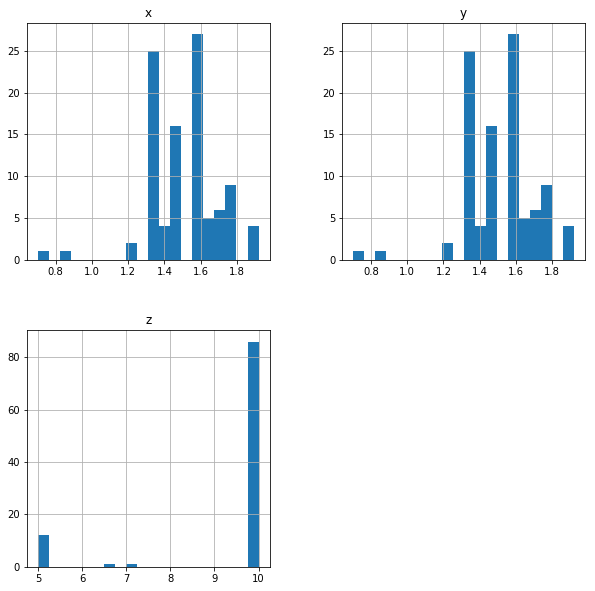

In [7]:
df_acdc_spacing[['z','x', 'y']].hist(grid=True, bins=20, figsize=(10,10))

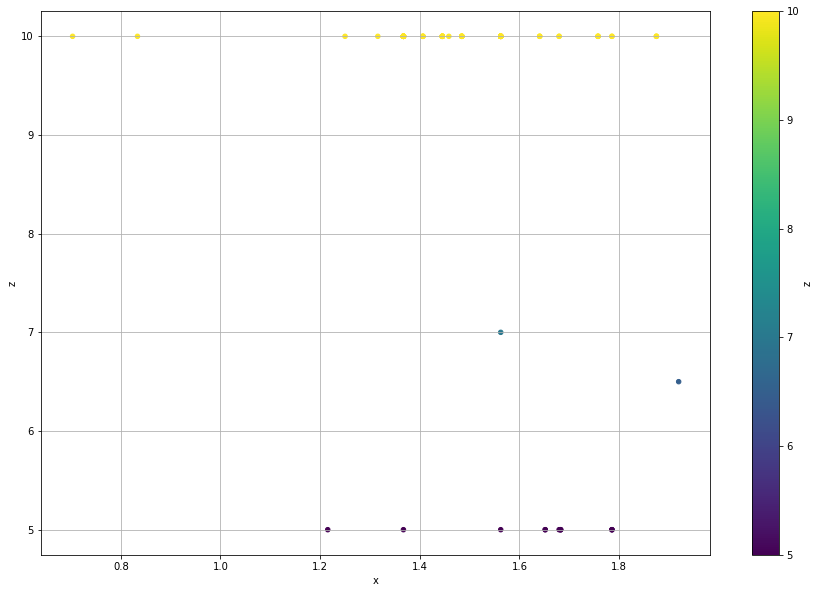

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
df_acdc_spacing.plot.scatter(x='x',y='z',c='z',colormap='viridis', grid=True, use_index=True, ax=ax)

# Shape

In [14]:
def get_shape(file):
    return sitk.GetArrayViewFromImage(sitk.ReadImage(file)).shape
df_acdc_shapes = pd.DataFrame([get_shape(f) for f in acdc_files], columns=['t', 'z', 'y', 'x'])

Z-resolution mean: 018.00
Z-resolution std: 002.40
X-resolution mean: 428.00
X-resolution std: 034.04
Y-resolution mean: 512.00
Y-resolution std: 039.44
T-resolution mean: 035.00
T-resolution std: 006.08


Text(0.5, 1.0, 'resolutions - ACDC')

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/pandas/plotting/_core.py:1798: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


t       AxesSubplot(0.125,0.125;0.168478x0.755)
z    AxesSubplot(0.327174,0.125;0.168478x0.755)
x    AxesSubplot(0.529348,0.125;0.168478x0.755)
y    AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

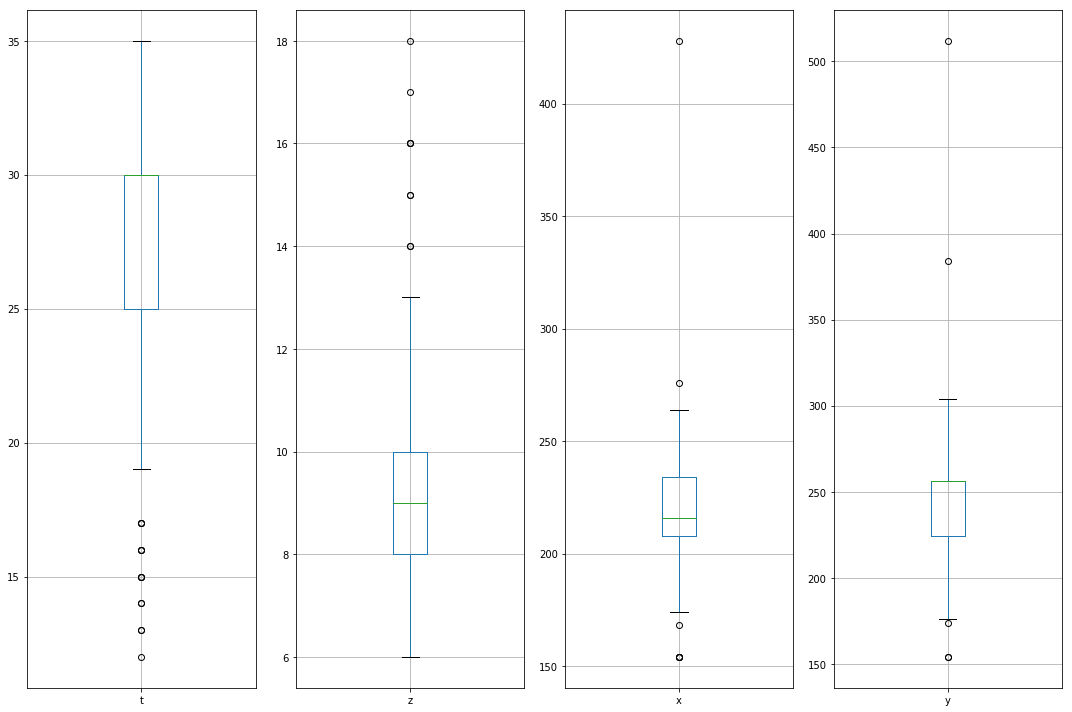

In [19]:
print('Z-resolution mean: {:06.2f}'.format(df_acdc_shapes['z'].max()))
print('Z-resolution std: {:06.2f}'.format(df_acdc_shapes['z'].std()))
print('X-resolution mean: {:06.2f}'.format(df_acdc_shapes['x'].max()))
print('X-resolution std: {:06.2f}'.format(df_acdc_shapes['x'].std()))
print('Y-resolution mean: {:06.2f}'.format(df_acdc_shapes['y'].max()))
print('Y-resolution std: {:06.2f}'.format(df_acdc_shapes['y'].std()))
print('T-resolution mean: {:06.2f}'.format(df_acdc_shapes['t'].max()))
print('T-resolution std: {:06.2f}'.format(df_acdc_shapes['t'].std()))
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('resolutions - ACDC')
df_acdc_shapes[['t', 'z', 'x', 'y']].plot(kind='box',subplots=True, grid=True, ax=ax)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
df_acdc_shapes[['z','x', 'y']].hist(grid=True, bins=20, ax=ax)

In [ ]:
# few are squared shaped
fig, ax = plt.subplots()
df_acdc_shapes.plot.scatter(x='x',y='y',c='z',colormap='viridis', grid=True, use_index=True, figsize=(15,10), ax=ax)

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
df_acdc_shapes.plot.scatter(x='x',y='z',c='z',colormap='viridis', grid=True, use_index=True, ax=ax1)

In [ ]:
# create a new columns with x * y as categorical field
df_acdc_shapes['resolution'] = [str(x) + 'x' + str(y) for x,y in zip(df_acdc_shapes['x'], df_acdc_shapes['y'])]

In [ ]:
df_acdc_shapes['resolution'].value_counts().plot(kind='bar', figsize=(20,10))

## Size (shape x spacing)

In [ ]:
df_acdc_size = df_acdc_shapes[['x', 'y', 'z']] * df_acdc_spacing[['x', 'y', 'z']]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Volume sizes in mm')
df_acdc_size[['z','x', 'y']].hist(grid=True, bins=20, ax=ax)

In [ ]:
print('Z-size mean: {:06.2f}'.format(df_acdc_size['z'].mean()))
print('Z-size std: {:06.2f}'.format(df_acdc_size['z'].std()))
print('X-size mean: {:06.2f}'.format(df_acdc_size['x'].mean()))
print('X-size std: {:06.2f}'.format(df_acdc_size['x'].std()))
print('Y-size mean: {:06.2f}'.format(df_acdc_size['y'].mean()))
print('Y-size std: {:06.2f}'.format(df_acdc_size['y'].std()))
fig, ax = plt.subplots(figsize=(15,10))
df_acdc_size[['z', 'x', 'y']].plot(kind='box',subplots=True, grid=True, ax=ax)
plt.tight_layout()

In [ ]:
df_acdc_z =pd.DataFrame(columns=['z_size', 'z_shape', 'z_spacing'])
df_acdc_z['z_size'] = df_acdc_size['z']
df_acdc_z['z_shape'] = df_acdc_shapes['z']
df_acdc_z['z_spacing'] = df_acdc_spacing['z']

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
df_acdc_z.plot.scatter(x='z_size',y='z_spacing',c='z_shape',colormap='viridis', grid=True, use_index=True, ax=ax1, s=90)

fig, ax1 = plt.subplots(figsize=(15,10))
df_acdc_z.plot.scatter(x='z_size',y='z_shape',c='z_spacing',colormap='viridis', grid=True, use_index=True, ax=ax1, s=90)

# TETRA

## Define a path to inspect spacing, shape and physical size (shape * spacing)

In [37]:
files = sorted(glob.glob(os.path.join('data/raw/GCN/3D/**/*img.nrrd')))
len(files)

1030

## Get the spacing of all masked 3D volumes

In [38]:
def get_spacing(file):
    return sitk.ReadImage(file).GetSpacing()
df_spacing = pd.DataFrame([get_spacing(f) for f in files], columns=['x', 'y', 'z'])

## Boxplot X, Y, Z spacing

Z-spacing mean: 08.80
Z-spacing std: 01.27
X-spacing mean: 01.37
X-spacing std: 00.17
Y-spacing mean: 01.37
Y-spacing std: 00.17


z       AxesSubplot(0.125,0.125;0.227941x0.755)
x    AxesSubplot(0.398529,0.125;0.227941x0.755)
y    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

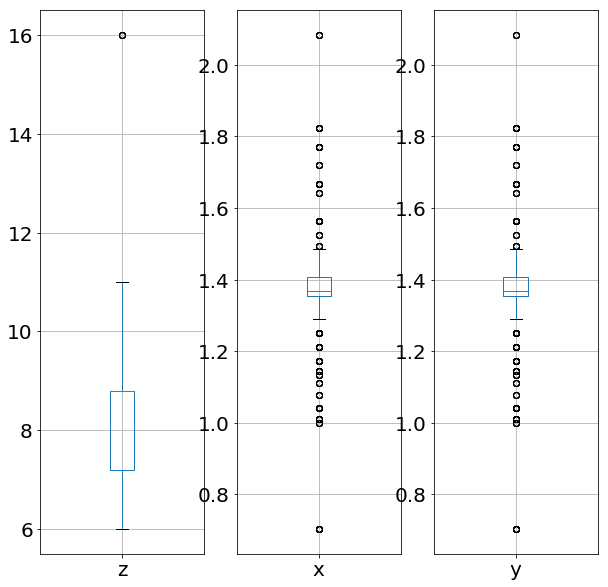

In [39]:
print('Z-spacing mean: {:05.2f}'.format(df_spacing['z'].median()))
print('Z-spacing std: {:05.2f}'.format(df_spacing['z'].std()))
print('X-spacing mean: {:05.2f}'.format(df_spacing['x'].median()))
print('X-spacing std: {:05.2f}'.format(df_spacing['x'].std()))
print('Y-spacing mean: {:05.2f}'.format(df_spacing['y'].median()))
print('Y-spacing std: {:05.2f}'.format(df_spacing['y'].std()))
df_spacing[['z', 'x', 'y']].plot(kind='box',subplots=True, grid=True, figsize=(10,10))
plt.savefig('reports/gcn_spacing_boxplot.pdf')

## Distribution of X, Y, Z spacing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd0e62048>,
      dtype=object)

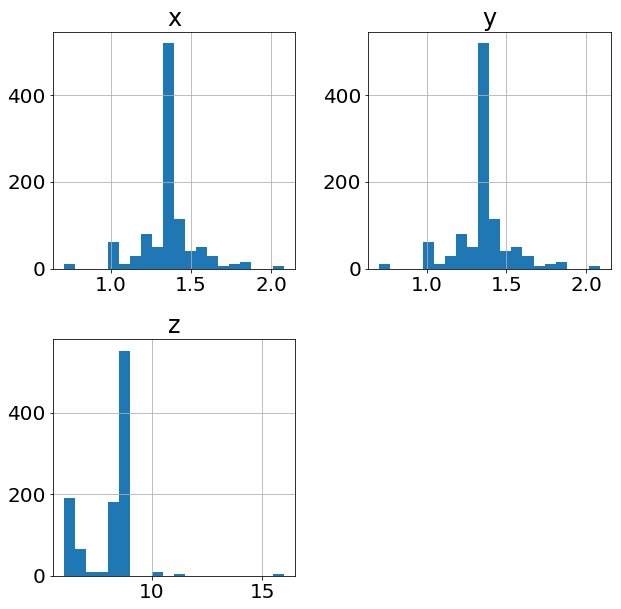

In [40]:
df_spacing[['z','x', 'y']].hist(grid=True, bins=20, figsize=(10,10))

## Scatterplot spacing (x vs y, colormap = z)

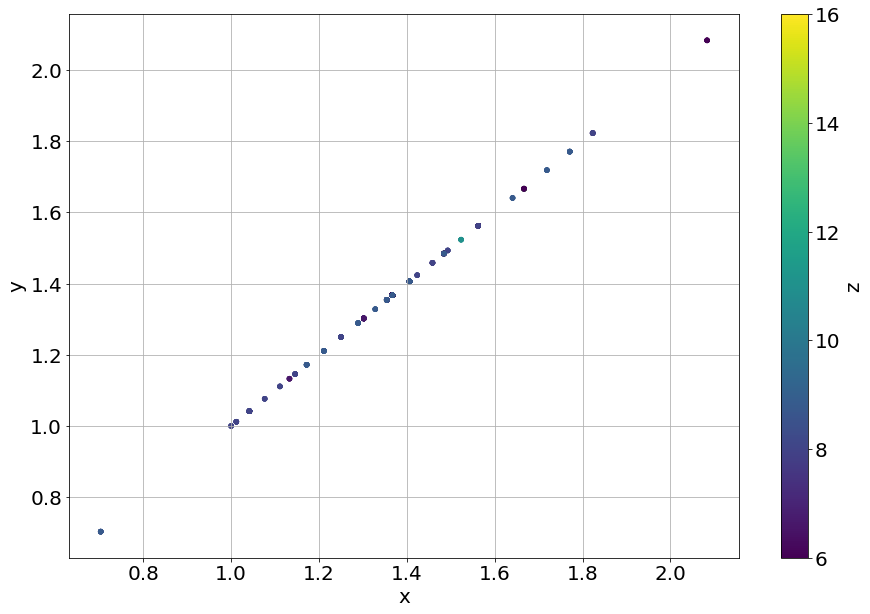

In [41]:
# x spacing == y spacing
fig, ax = plt.subplots(figsize=(15,10))
df_spacing.plot.scatter(x='x',y='y',c='z',colormap='viridis', grid=True, use_index=True, ax=ax)

## Scatterplot spacing (x vs z, colormap = z)

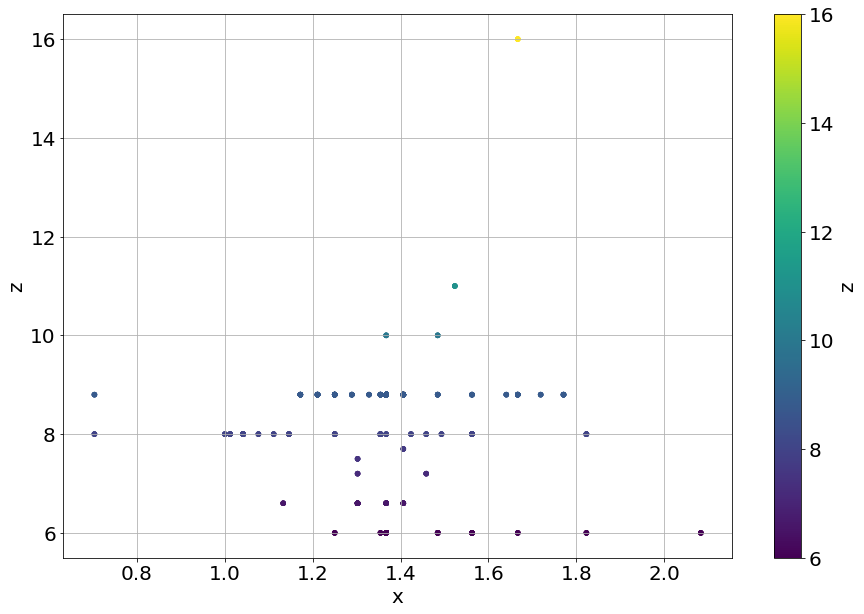

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
df_spacing.plot.scatter(x='x',y='z',c='z',colormap='viridis', grid=True, use_index=True, ax=ax)

## Get the shape of all masked 3D volumes

In [43]:
def get_shape(file):
    return sitk.GetArrayViewFromImage(sitk.ReadImage(file)).shape
df_shapes = pd.DataFrame([get_shape(f) for f in files], columns=['z', 'y', 'x'])

## Boxplot X, Y, Z resolution

Z-shape mean: 013.93
Z-shape std: 003.20
X-shape mean: 244.17
X-shape std: 052.42
Y-shape mean: 251.65
Y-shape std: 040.52


Text(0.5, 1.0, 'Shape distribution')

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/pandas/plotting/_core.py:1798: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


z       AxesSubplot(0.125,0.125;0.227941x0.755)
x    AxesSubplot(0.398529,0.125;0.227941x0.755)
y    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

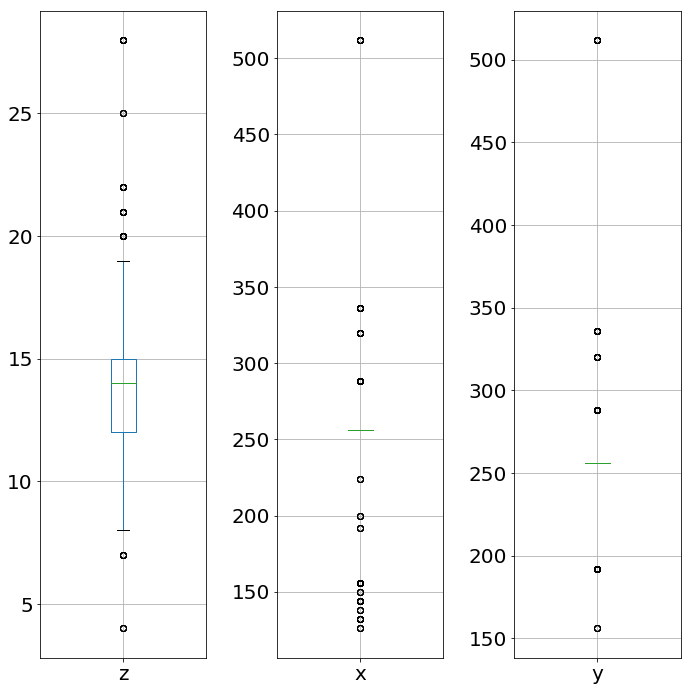

In [44]:
print('Z-shape mean: {:06.2f}'.format(df_shapes['z'].mean()))
print('Z-shape std: {:06.2f}'.format(df_shapes['z'].std()))
print('X-shape mean: {:06.2f}'.format(df_shapes['x'].mean()))
print('X-shape std: {:06.2f}'.format(df_shapes['x'].std()))
print('Y-shape mean: {:06.2f}'.format(df_shapes['y'].mean()))
print('Y-shape std: {:06.2f}'.format(df_shapes['y'].std()))
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Shape distribution')
df_shapes[['z', 'x', 'y']].plot(kind='box',subplots=True, grid=True, ax=ax)
#plt.title('Tetra data - 3D image resolutions')
plt.tight_layout()
plt.savefig('reports/gcn_resolution_boxplot.pdf')

## Which z shape should be choosen?

In [45]:
# cover most z slices, cut as less as possible, 85 % do have a smaller z shape than 16
np.quantile(df_shapes['z'], q=.85)

17.0

In [46]:
# inverse the quantile, 85 % do have a greater z shape than 12
np.quantile(df_shapes['z']*-1, q=.85)

-12.0

In [47]:
# 85 % of the 3d volumes do have a smaller z-shape than 16
# maybe use 16 as cropping value
(100/len(df_shapes['z'])) * (len(df_shapes[df_shapes['z']<=16]))

84.5631067961165

In [48]:
# create a new columns with x * y as categorical field
df_shapes['resolution'] = [str(x) + 'x' + str(y) for x,y in zip(df_shapes['x'], df_shapes['y'])]

## Distribution of X, Y, Z shapes

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3291: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd09aa0f0>,
      dtype=object)

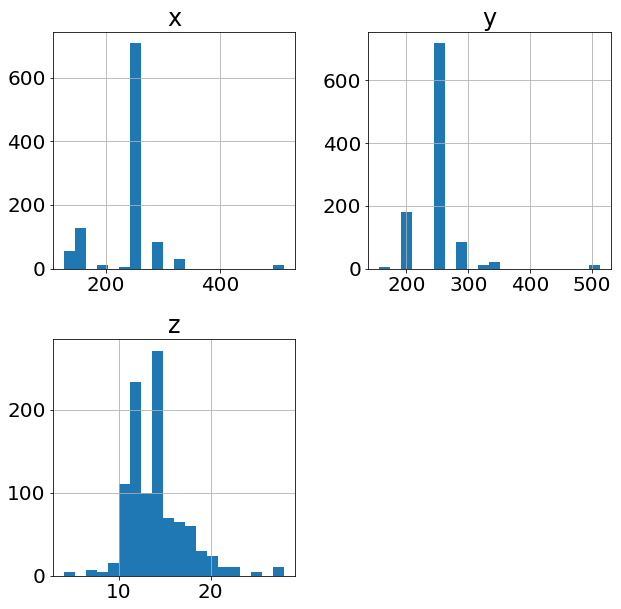

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
df_shapes[['z','x', 'y']].hist(grid=True, bins=20, ax=ax)

## Histogram of the combined X,Y shape

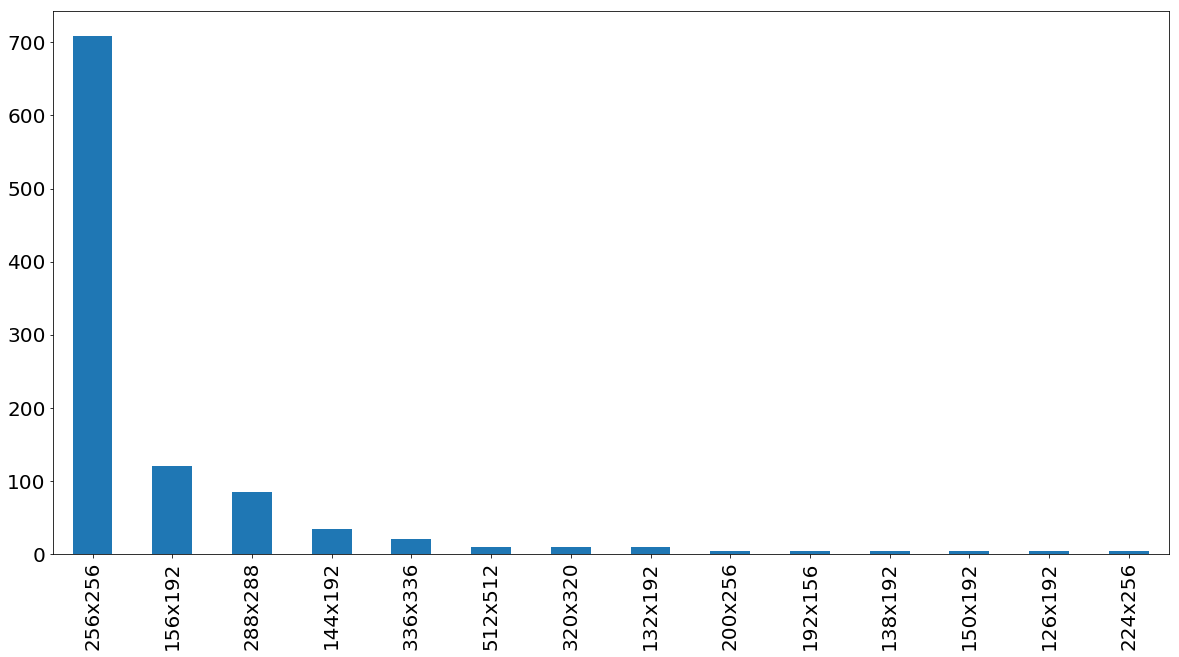

In [50]:
df_shapes['resolution'].value_counts().plot(kind='bar', figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd0763208>],
      dtype=object)

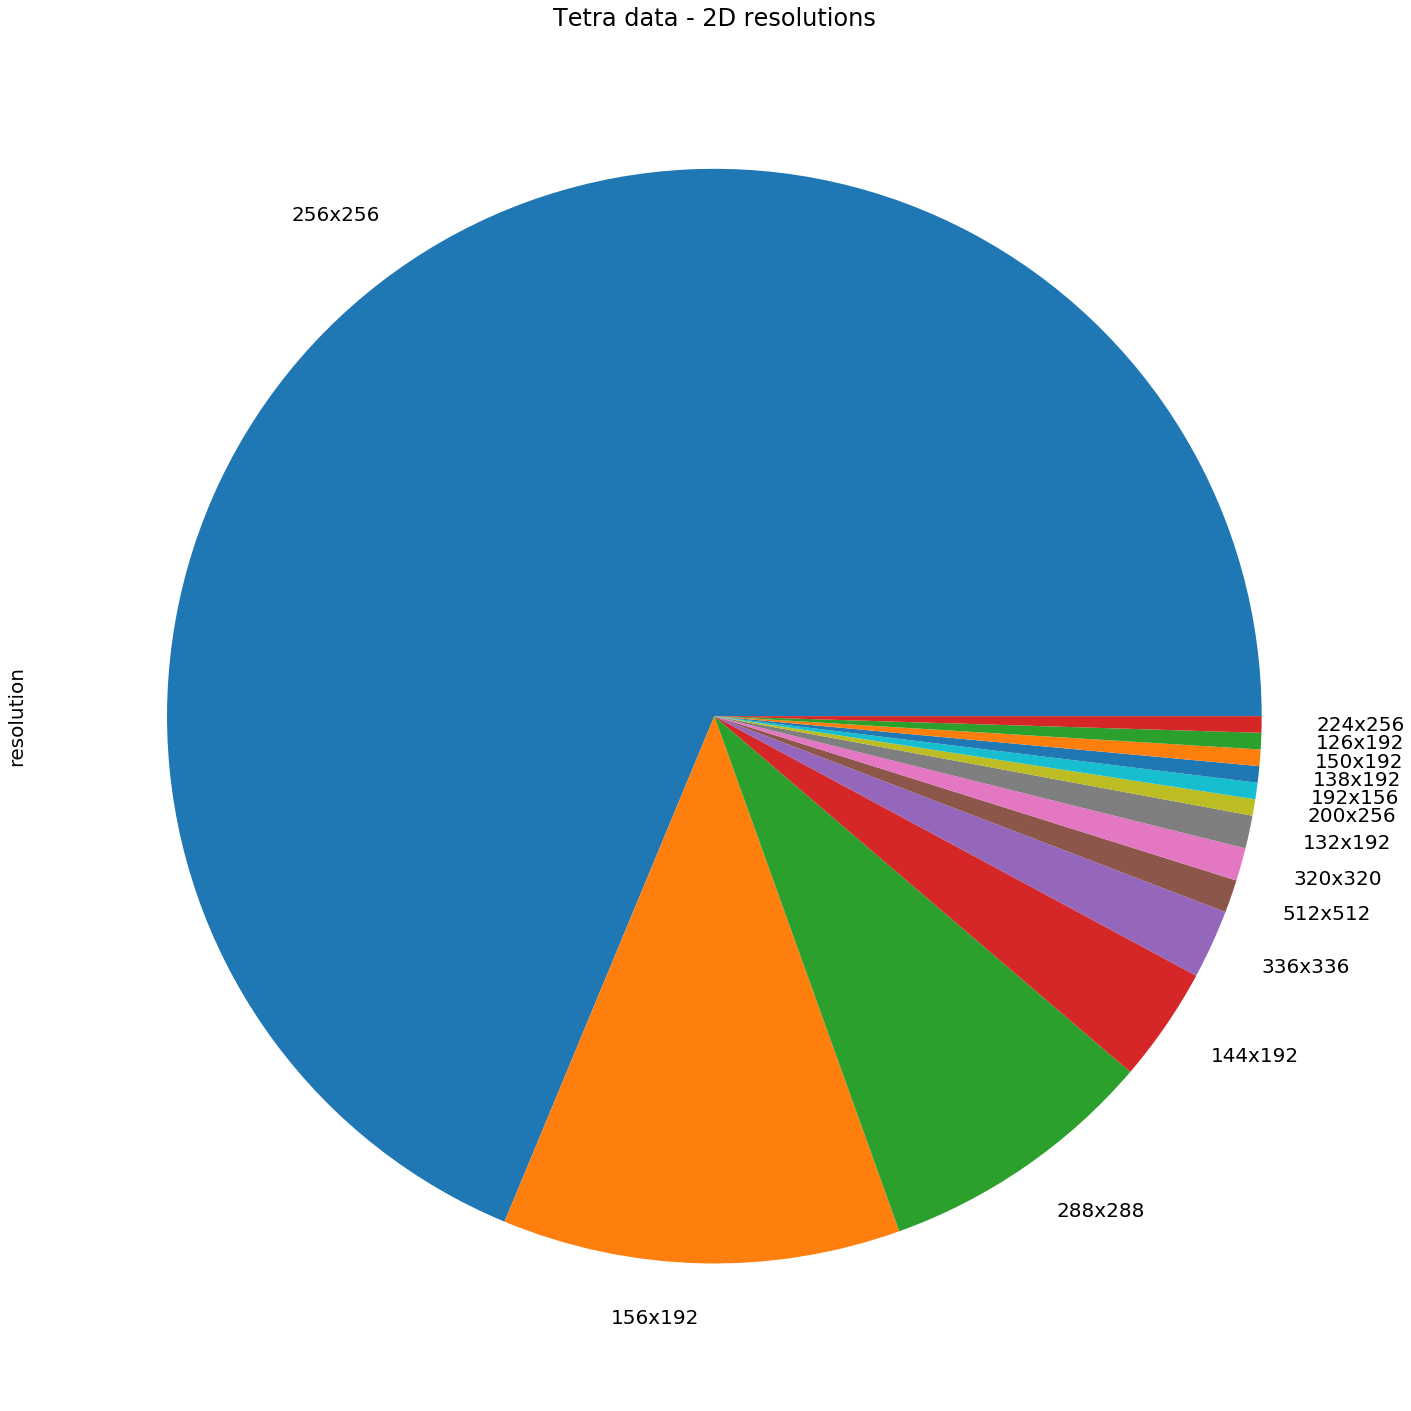

In [51]:
plt.rcParams.update({'font.size': 20})
df_shapes['resolution'].value_counts().plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['Tetra data - 2D resolutions'])
plt.tight_layout()

In [52]:
df_shapes.head()

z    y    x resolution
0  12  256  256    256x256
1  12  256  256    256x256
2  12  256  256    256x256
3  12  256  256    256x256
4  12  256  256    256x256

In [53]:
# create a new columns with x * y as categorical field
df_shapes['spacings_2d'] = [str(x) + 'x' + str(y) for x,y in zip(df_shapes['x'], df_shapes['y'])]

In [ ]:
plt.rcParams.update({'font.size': 20})
df_shapes['resolution'].value_counts().plot(kind='pie', subplots=True, sharex=False, figsize=(20,20), title=['Tetra data - 2D resolutions'])
plt.tight_layout()

## Scatterplot shapes (x vs y, colormap = z)

In [ ]:
# nearly all are squared shaped
fig, ax = plt.subplots()
df_shapes.plot.scatter(x='x',y='y',c='z',colormap='viridis', grid=True, use_index=True, figsize=(15,10), ax=ax)

## Scatterplot shapes (x vs z, colormap = z)

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
df_shapes.plot.scatter(x='x',y='z',c='z',colormap='viridis', grid=True, use_index=True, ax=ax1)

## Scatterplot shapes (y vs z, colormap = z)

In [ ]:
fig, ax2 = plt.subplots(figsize=(15,10))
df_shapes.plot.scatter(x='y',y='z',c='z',colormap='viridis', grid=True, use_index=True, ax=ax2)

In [ ]:
df_size = df_shapes[['x', 'y', 'z']] * df_spacing[['x', 'y', 'z']]

## Distribution of volume sizes

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Volume sizes in mm')
df_size[['z','x', 'y']].hist(grid=True, bins=20, ax=ax)

In [ ]:
# cover most z slices, cut as less as possible, 95 % do have a smaller z size than 132
np.quantile(df_size['z'], q=.95)

In [ ]:
# inverse the quantile, 85 % do have a greater z size than 80
np.quantile(df_size['z']*-1, q=.95)

## Boxplot X,Y, Z physical size (shape*spacing)

In [ ]:
print('Z-size mean: {:06.2f}'.format(df_size['z'].mean()))
print('Z-size std: {:06.2f}'.format(df_size['z'].std()))
print('X-size mean: {:06.2f}'.format(df_size['x'].mean()))
print('X-size std: {:06.2f}'.format(df_size['x'].std()))
print('Y-size mean: {:06.2f}'.format(df_size['y'].mean()))
print('Y-size std: {:06.2f}'.format(df_size['y'].std()))
fig, ax = plt.subplots(figsize=(15,10))
df_size[['z', 'x', 'y']].plot(kind='box',subplots=True, grid=True, ax=ax)
plt.tight_layout()

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
df_shapes.plot.scatter(x='x',y='z',c='z',colormap='viridis', grid=True, use_index=True, ax=ax1, s=90)

## Get one df with size, shape and spacing of the z axis

In [ ]:
df_z =pd.DataFrame(columns=['z_size', 'z_shape', 'z_spacing'])

In [ ]:
df_z['z_size'] = df_size['z']

In [ ]:
df_z['z_shape'] = df_shapes['z']

In [ ]:
df_z['z_spacing'] = df_spacing['z']

## Scatterplot z- size, shape and spacing

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
df_z.plot.scatter(x='z_size',y='z_spacing',c='z_shape',colormap='viridis', grid=True, use_index=True, ax=ax1, s=90)

fig, ax1 = plt.subplots(figsize=(15,10))
df_z.plot.scatter(x='z_size',y='z_shape',c='z_spacing',colormap='viridis', grid=True, use_index=True, ax=ax1, s=90)

# Find the best resample size for z

In [ ]:
# resample with spacing = 6 (lowest represented spacing) --> increase shape of nearly all volumes  
df_z['resample_shape'] = df_z['z_size'] / 8

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
df_z.plot.scatter(x='resample_shape',y='z_shape',c='z_size',colormap='viridis', grid=True, use_index=True, ax=ax1, s=90)

## Comparison of z shape distribution before resampling and after

In [ ]:
print('resample_shape mean: {:06.2f}'.format(df_z['resample_shape'].mean()))
print('resample_shape std: {:06.2f}'.format(df_z['resample_shape'].std()))
print('z_shape mean: {:06.2f}'.format(df_z['z_shape'].mean()))
print('z_shape std: {:06.2f}'.format(df_z['z_shape'].std()))

fig, ax1 = plt.subplots(figsize=(10,10))
df_z[['resample_shape','z_shape']].hist(grid=True, bins=20, ax=ax1)
fig, ax2 = plt.subplots(figsize=(15,10))
df_z[['resample_shape','z_shape']].plot(kind='box',subplots=True, grid=True, ax=ax2)
plt.tight_layout()

## Comparison of z shape distribution before resampling and after - in one plot

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
df_z[['resample_shape','z_shape']].plot(kind='hist',grid=True, stacked=True,bins=20, ax=ax)